# Traitement des données pour le polluant NO2

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import importlib
import NO2

# Recharger le module pour prendre en compte les modifications
importlib.reload(NO2)

# Importer la fonction depuis le fichier Python
from NO2 import fetch_and_process_no2_data

# Utilisation de la fonction importée
dfNO2 = fetch_and_process_no2_data()

# Vérifier si le DataFrame a été correctement récupéré et traité
if dfNO2 is not None:
    # Afficher les premières lignes du DataFrame dfNO2 pour vérifier les modifications
    print(dfNO2.head())

    # Afficher les types de colonnes pour vérifier les conversions
    print(dfNO2.dtypes)


Total records retrieved: 50186
                                 id code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_NO2_A            03               FR23003_NO2   
1  2024-03-31 23:00:00FR23068_NO2_A            03               FR23068_NO2   
2  2024-03-31 23:00:00FR23070_NO2_A            03               FR23070_NO2   
3  2024-03-31 23:00:00FR23075_NO2_A            03               FR23075_NO2   
4  2024-03-31 23:00:00FR23078_NO2_A            03               FR23078_NO2   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
3      FR23075               JULES VERNE                   Trignac   
4      FR23078             SAINT EXUPERY                    Cholet   

  code_commune departement_code   departement_nom  code_zone_affichage  \

## Comparaison avec les valeurs de seuils

De plus de même manière que pour le NO2, nous décidons de diviser par 2 les valeurs de seuils officielles de manière à rendre l'exercice plus intéressant pour avoir des résultats

De plus nous allons créer des valeurs mensuelles pour visualiser ces données sur une échelle trimestrielle

In [3]:
# Définition des nouveaux seuils pour les particules NO2 en µg/m3 annuelle
OBJECTIF_QUALITE_NO2 = 20  # en moyenne mensuel, 40 officiels
VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2 = 20  # en moyenne mensuel, 40 officiels
NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2 = 15  # en moyenne mensuel d'oxydes d'azotes, 30 officiels
SEUIL_INFO_RECO = 100 #en moyenne horaire, 200 valeur d'origine
SEUIL_ALERTE = 40 #en moyenne horaire sur 3H consécutives, 'àà valeur d'origine

print(f"Objectif de qualité NO2 : {OBJECTIF_QUALITE_NO2} µg/m3 (en moyenne annuelle)")
print(f"Valeur limite pour la protection de la santé humaine NO2 : {VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2} µg/m3 (en moyenne mensuel)")
print(f"Niveau critique pour la protection de la végétation NO2 : {NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2} µg/m3 (en moyenne mensuel d'oxydes d'azotes)")
print(f"Seuil d'information et de recommandation : {SEUIL_INFO_RECO} µg/m3 (en moyenne horaire)")
print(f"Seuils d'alerte : {SEUIL_ALERTE} µg/m3 (en moyenne horaire sur 3H consécutives)")


Objectif de qualité NO2 : 20 µg/m3 (en moyenne annuelle)
Valeur limite pour la protection de la santé humaine NO2 : 20 µg/m3 (en moyenne mensuel)
Niveau critique pour la protection de la végétation NO2 : 15 µg/m3 (en moyenne mensuel d'oxydes d'azotes)
Seuil d'information et de recommandation : 100 µg/m3 (en moyenne horaire)
Seuils d'alerte : 40 µg/m3 (en moyenne horaire sur 3H consécutives)


Création d’une variable cible qui vaut 1 si la valeur est supérieure au seuil et 0 sinon On ajoute ces colonnes au dataframe

In [4]:
# Convertir les colonnes de date en format datetime
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Ajouter des colonnes de comparaison avec les seuils (variable cible)
dfNO2['cible_objectif_qualite_NO2'] = (dfNO2['valeur'] > OBJECTIF_QUALITE_NO2).astype(int)
dfNO2['cible_valeur_limite_protection_sante_humaine_NO2'] = (dfNO2['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2).astype(int)
dfNO2['cible_niveau_critique_protection_vegetation_NO2'] = (dfNO2['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2).astype(int)
dfNO2['cible_seuil_info_reco'] = (dfNO2['valeur'] > SEUIL_INFO_RECO).astype(int)

# Calculer la moyenne horaire sur 3 heures consécutives pour le seuil d'alerte
dfNO2['moyenne_3h'] = dfNO2['valeur'].rolling(window=3).mean()
dfNO2['cible_seuil_alerte'] = (dfNO2['moyenne_3h'] > SEUIL_ALERTE).astype(int)

# Sauvegarder le DataFrame avec les nouvelles colonnes de comparaison
dfNO2.to_pickle('NO2_with_comparison.pkl')

# Grouper les données par année, mois et département pour les valeurs mensuelles
dfNO2['année'] = dfNO2['date_heure_tu'].dt.year
dfNO2['mois'] = dfNO2['date_heure_tu'].dt.month
grouped = dfNO2.groupby(['année', 'mois', 'departement_nom'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped['valeur'] = grouped['valeur'].round(1)

# Créer les colonnes indiquant si la moyenne mensuelle dépasse les seuils
grouped['depasse_objectif_qualite'] = (grouped['valeur'] > OBJECTIF_QUALITE_NO2).astype(int)
grouped['depasse_valeur_limite_protection_sante'] = (grouped['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2).astype(int)
grouped['depasse_niveau_critique_vegetation'] = (grouped['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2).astype(int)

# Sauvegarder le DataFrame groupé avec les nouvelles colonnes de comparaison
grouped.to_pickle('NO2_grouped_with_comparison.pkl')

# Afficher les premières lignes du DataFrame avec les nouvelles colonnes de comparaison
print(dfNO2.head())
print(grouped.head())


                                 id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_NO2_A              3               FR23003_NO2   
1  2024-03-31 23:00:00FR23068_NO2_A              3               FR23068_NO2   
2  2024-03-31 23:00:00FR23070_NO2_A              3               FR23070_NO2   
3  2024-03-31 23:00:00FR23075_NO2_A              3               FR23075_NO2   
4  2024-03-31 23:00:00FR23078_NO2_A              3               FR23078_NO2   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    donges   
1      FR23068                   FROSSAY                   frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  saint-etienne-de-montluc   
3      FR23075               JULES VERNE                   trignac   
4      FR23078             SAINT EXUPERY                    cholet   

   code_commune  departement_code   departement_nom  code_zone_affichage  ...  \
0         44052  

### Distribution des variables cibles

In [5]:
# Afficher le nombre de valeurs 0 et 1 dans la colonne 'cible_objectif_qualite_NO2'
print(dfNO2['cible_objectif_qualite_NO2'].value_counts())
print(dfNO2['cible_valeur_limite_protection_sante_humaine_NO2'].value_counts())
print(dfNO2['cible_niveau_critique_protection_vegetation_NO2'].value_counts())
print(dfNO2['cible_seuil_info_reco'].value_counts())
print(dfNO2['cible_seuil_alerte'].value_counts())


cible_objectif_qualite_NO2
0    43139
1     6751
Name: count, dtype: int64
cible_valeur_limite_protection_sante_humaine_NO2
0    43139
1     6751
Name: count, dtype: int64
cible_niveau_critique_protection_vegetation_NO2
0    39821
1    10069
Name: count, dtype: int64
cible_seuil_info_reco
0    49886
1        4
Name: count, dtype: int64
cible_seuil_alerte
0    49222
1      668
Name: count, dtype: int64


Observations : 
- Equilibré (alerte sur les seuils) : cible_niveau_critique_protection_vegetation
- Déséquilibré (indice semble correcte) : cible_objectif_qualite_NO2, cible_valeur_limite_protection_sante_humaine_NO2, cible_seuil_info_reco, cible_seuils_alerte

#### Graphique pour voir trimestriel par département, quand est-ce qu'on à dépassé le seuil de cible_objectif_qualité_NO2_mensuel (valeur de seuil = 18, en rouge quand depassé)


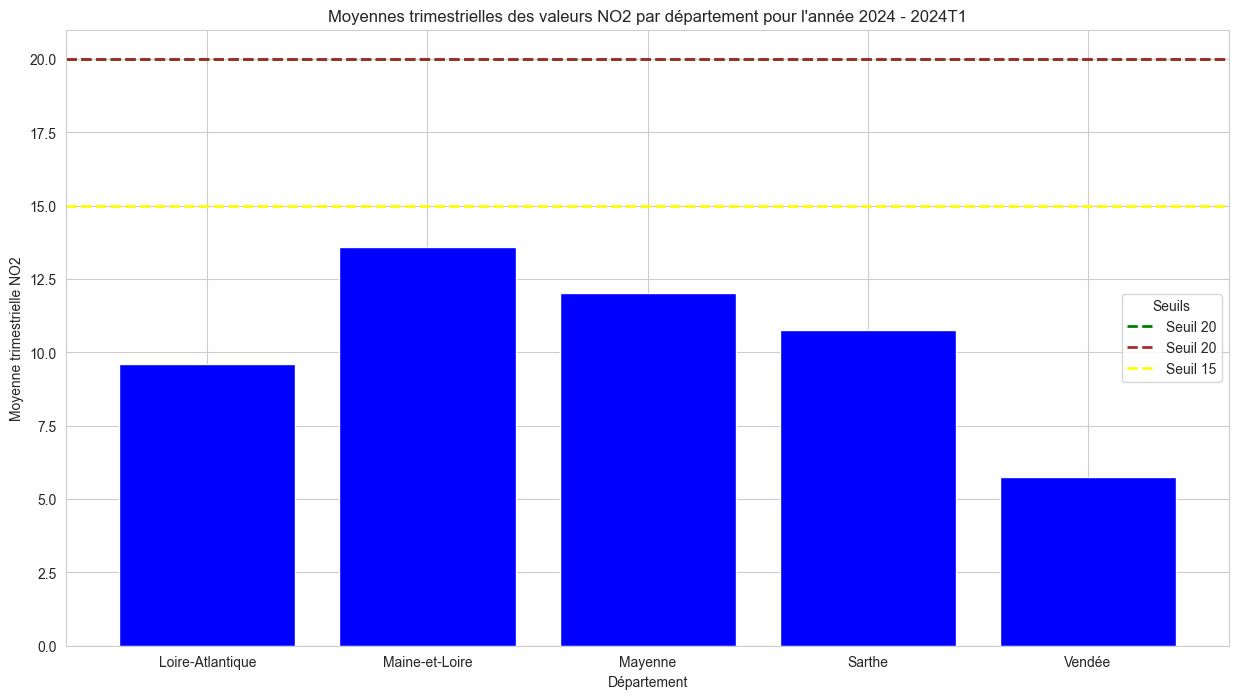

In [6]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Supprimer le fuseau horaire avant la conversion en périodes trimestrielles
dfNO2['date_heure_tu'] = dfNO2['date_heure_tu'].dt.tz_localize(None)

# Ajouter les colonnes 'année' et 'trimestre'
dfNO2['année'] = dfNO2['date_heure_tu'].dt.year
dfNO2['trimestre'] = dfNO2['date_heure_tu'].dt.to_period('Q').astype(str).str.replace('Q', 'T')

# Calculer la moyenne trimestrielle de NO2 pour chaque département et chaque année
quarterly_means = dfNO2.groupby(['année', 'trimestre', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne trimestrielle dépasse le seuil
quarterly_means['depasse_seuil'] = ((quarterly_means['valeur'] > OBJECTIF_QUALITE_NO2).astype(int) |
                                (quarterly_means['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2).astype(int) |
                                (quarterly_means['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2).astype(int))


# Créer la palette de couleurs
quarterly_means['color'] = ['red' if x else 'blue' for x in quarterly_means['depasse_seuil']]

# Créer un graphique en bâtons pour chaque année et trimestre
years = quarterly_means['année'].unique()

for year in years:
    annual_data = quarterly_means[quarterly_means['année'] == year]
    trimesters = annual_data['trimestre'].unique()

    for quarter in trimesters:
        plt.figure(figsize=(15, 8))
        quarterly_data = annual_data[annual_data['trimestre'] == quarter]
        colors = quarterly_data['color']
        plt.bar(quarterly_data['departement_nom'], quarterly_data['valeur'], color=colors)

        # Ajouter des lignes horizontales pour les seuils
        plt.axhline(y=OBJECTIF_QUALITE_NO2, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_NO2}')
        plt.axhline(y=VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2, color='brown', linestyle='--', linewidth=2, label=f'Seuil {VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2}')
        plt.axhline(y=NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2, color='yellow', linestyle='--', linewidth=2, label=f'Seuil {NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2}')
        

        plt.xlabel('Département')
        plt.ylabel('Moyenne trimestrielle NO2')
        plt.title(f'Moyennes trimestrielles des valeurs NO2 par département pour l\'année {year} - {quarter}')
        plt.legend(title='Seuils')
        plt.xticks(rotation=0)  # Rotation pour mieux afficher les noms des départements
        plt.show()


#### Graphique pour voir trimestriel par département, par ville quand est-ce qu'on à dépassé le seuil de cible_objectif_qualité_NO2_mensuel (valeur de seuil = 18, en rouge quand depassé)


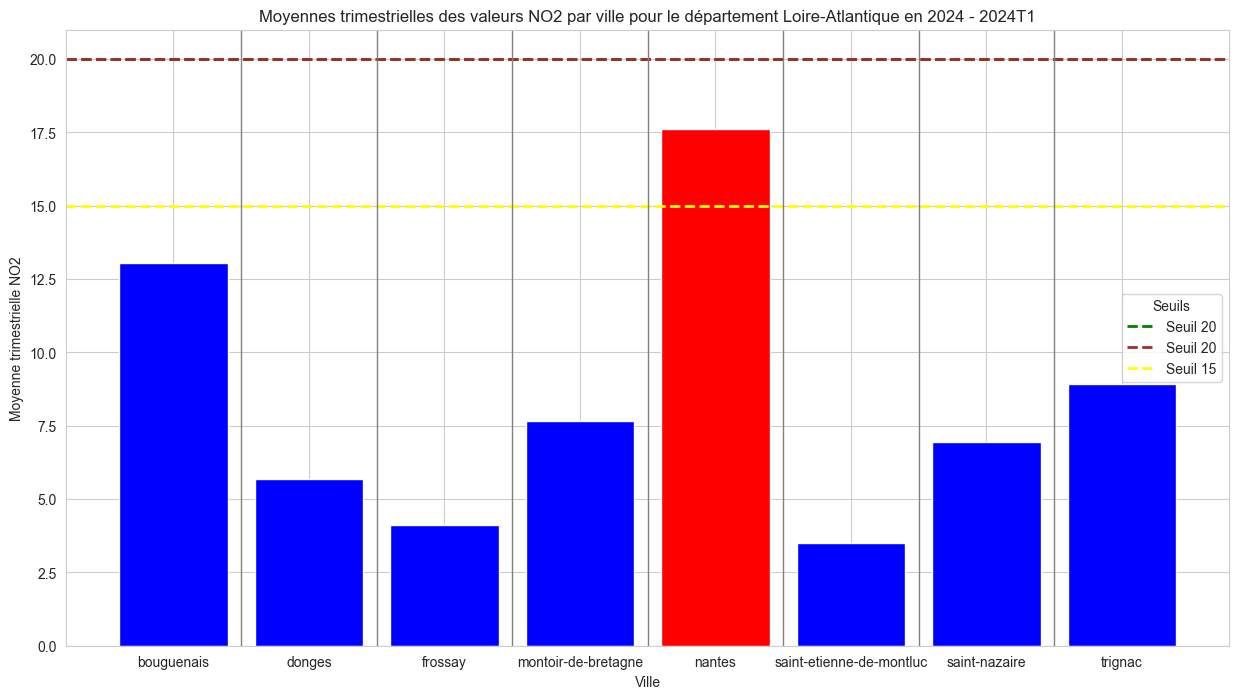

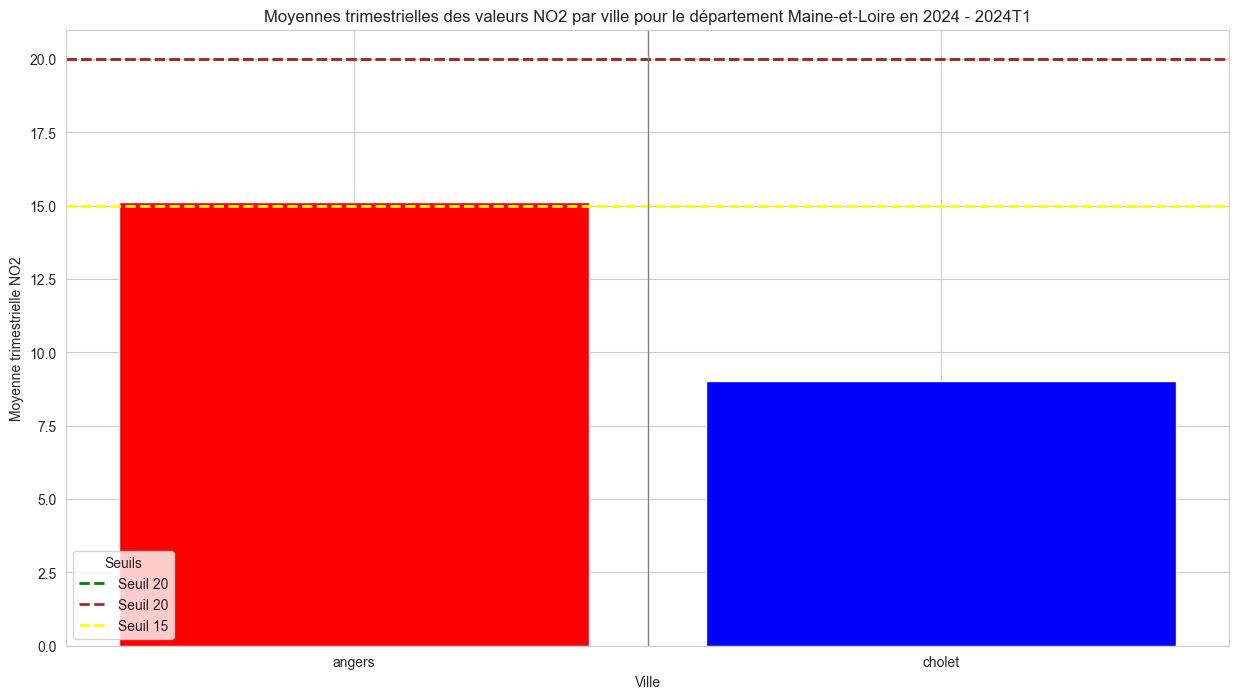

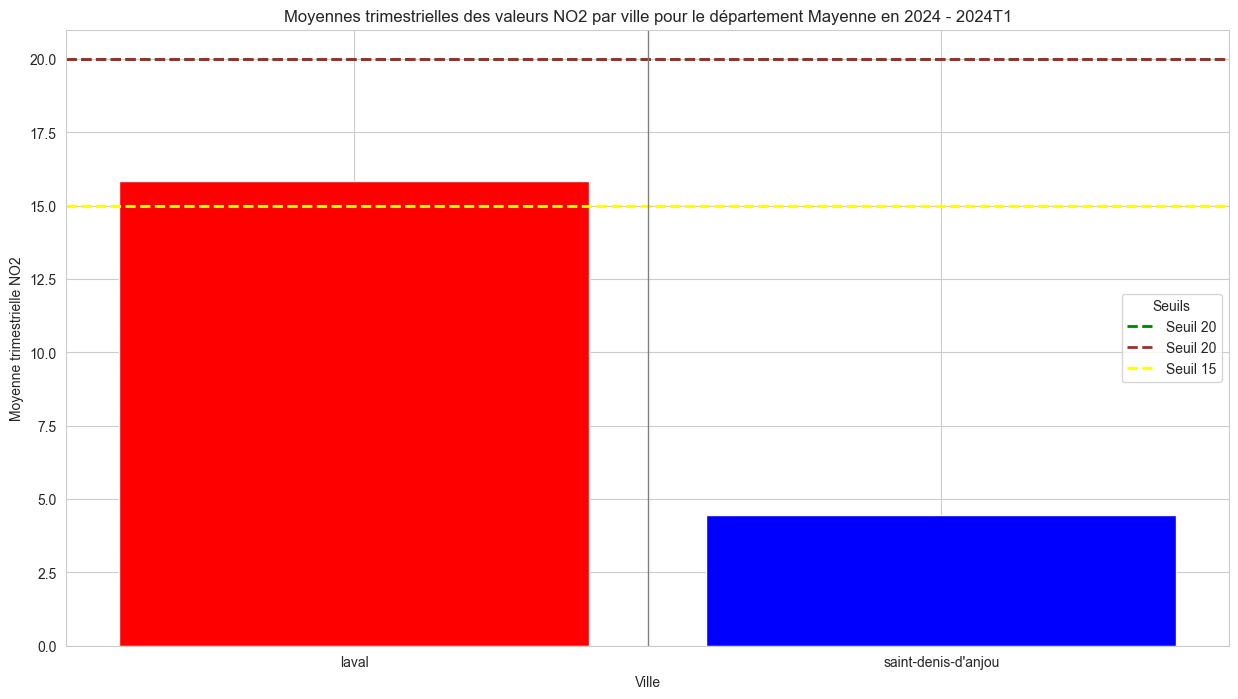

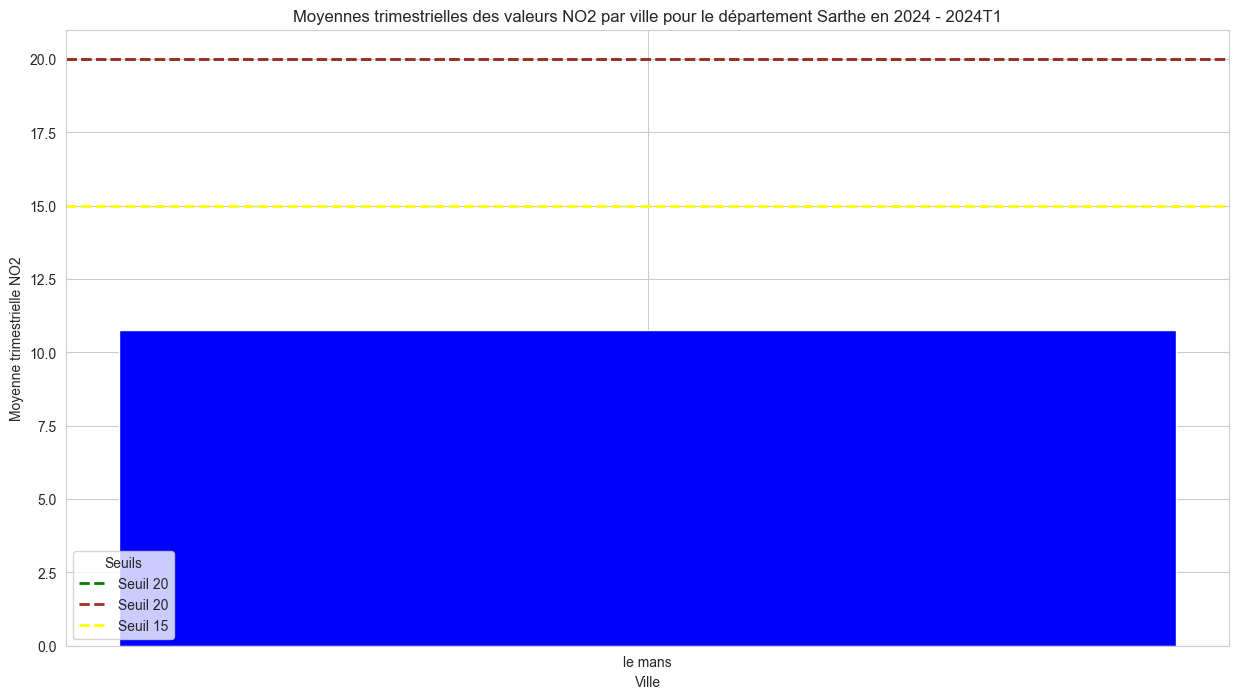

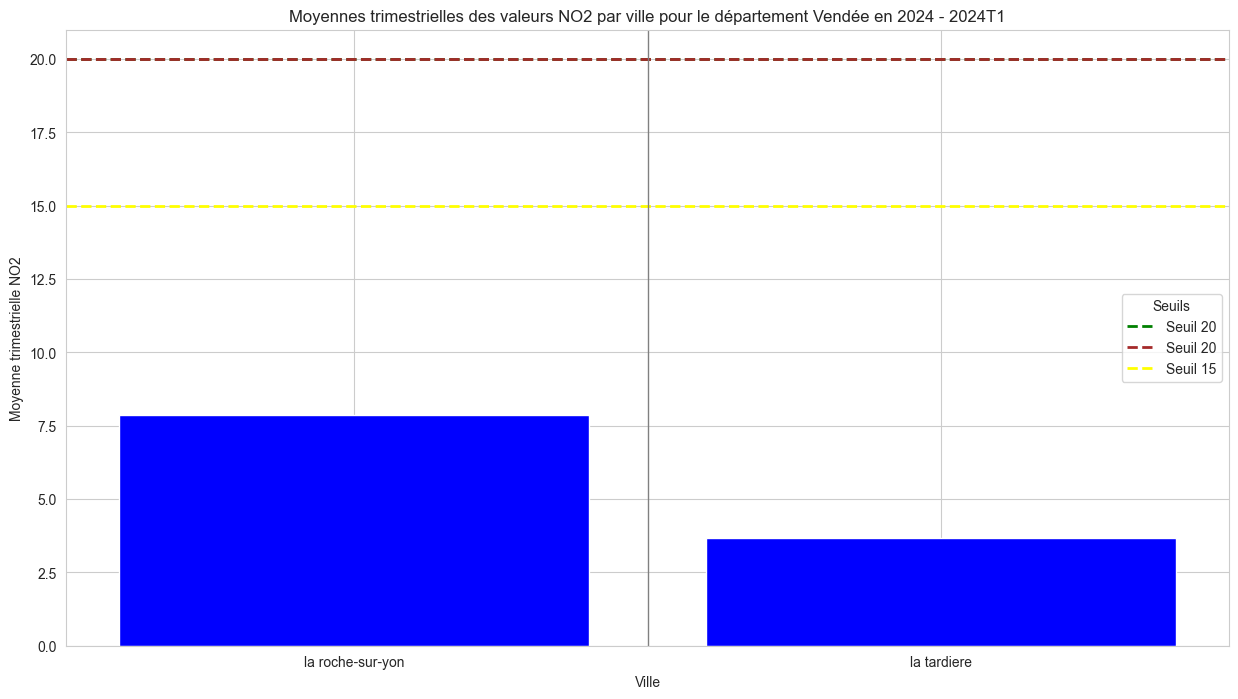

In [7]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Supprimer le fuseau horaire avant la conversion en périodes trimestrielles
dfNO2['date_heure_tu'] = dfNO2['date_heure_tu'].dt.tz_localize(None)

# Ajouter les colonnes 'année' et 'trimestre'
dfNO2['année'] = dfNO2['date_heure_tu'].dt.year
dfNO2['trimestre'] = dfNO2['date_heure_tu'].dt.to_period('Q').astype(str).str.replace('Q', 'T')

# Calculer la moyenne trimestrielle de NO2 pour chaque département, chaque ville et chaque année
quarterly_means = dfNO2.groupby(['année', 'trimestre', 'departement_nom', 'nom_commune'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne trimestrielle dépasse les seuils
quarterly_means['depasse_seuil'] = ((quarterly_means['valeur'] > OBJECTIF_QUALITE_NO2).astype(int) |
                                (quarterly_means['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2).astype(int) |
                                (quarterly_means['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2).astype(int))
# Créer la palette de couleurs
quarterly_means['color'] = ['red' if x else 'blue' for x in quarterly_means['depasse_seuil']]

# Créer un graphique en bâtons pour chaque année et chaque département
years = quarterly_means['année'].unique()
departments = quarterly_means['departement_nom'].unique()

for year in years:
    for department in departments:
        annual_dept_data = quarterly_means[(quarterly_means['année'] == year) & (quarterly_means['departement_nom'] == department)]
        
        if not annual_dept_data.empty:
            for quarter in annual_dept_data['trimestre'].unique():
                plt.figure(figsize=(15, 8))
                quarterly_data = annual_dept_data[annual_dept_data['trimestre'] == quarter]
                colors = quarterly_data['color']
                plt.bar(quarterly_data['nom_commune'], quarterly_data['valeur'], color=colors)

                # Ajouter des lignes horizontales pour les seuils
                plt.axhline(y=OBJECTIF_QUALITE_NO2, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_NO2}')
                plt.axhline(y=VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2, color='brown', linestyle='--', linewidth=2, label=f'Seuil {VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2}')
                plt.axhline(y=NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2, color='yellow', linestyle='--', linewidth=2, label=f'Seuil {NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2}')


                # Ajouter des lignes verticales pour séparer les trimestres
                for i in range(1, len(quarterly_data['nom_commune'])):
                    plt.axvline(x=i - 0.5, color='grey', linestyle='-', linewidth=1)

                plt.xlabel('Ville')
                plt.ylabel('Moyenne trimestrielle NO2')
                plt.title(f'Moyennes trimestrielles des valeurs NO2 par ville pour le département {department} en {year} - {quarter}')
                plt.legend(title='Seuils')
                plt.xticks(rotation=0)  # Rotation pour mieux afficher les noms des villes
                plt.show()


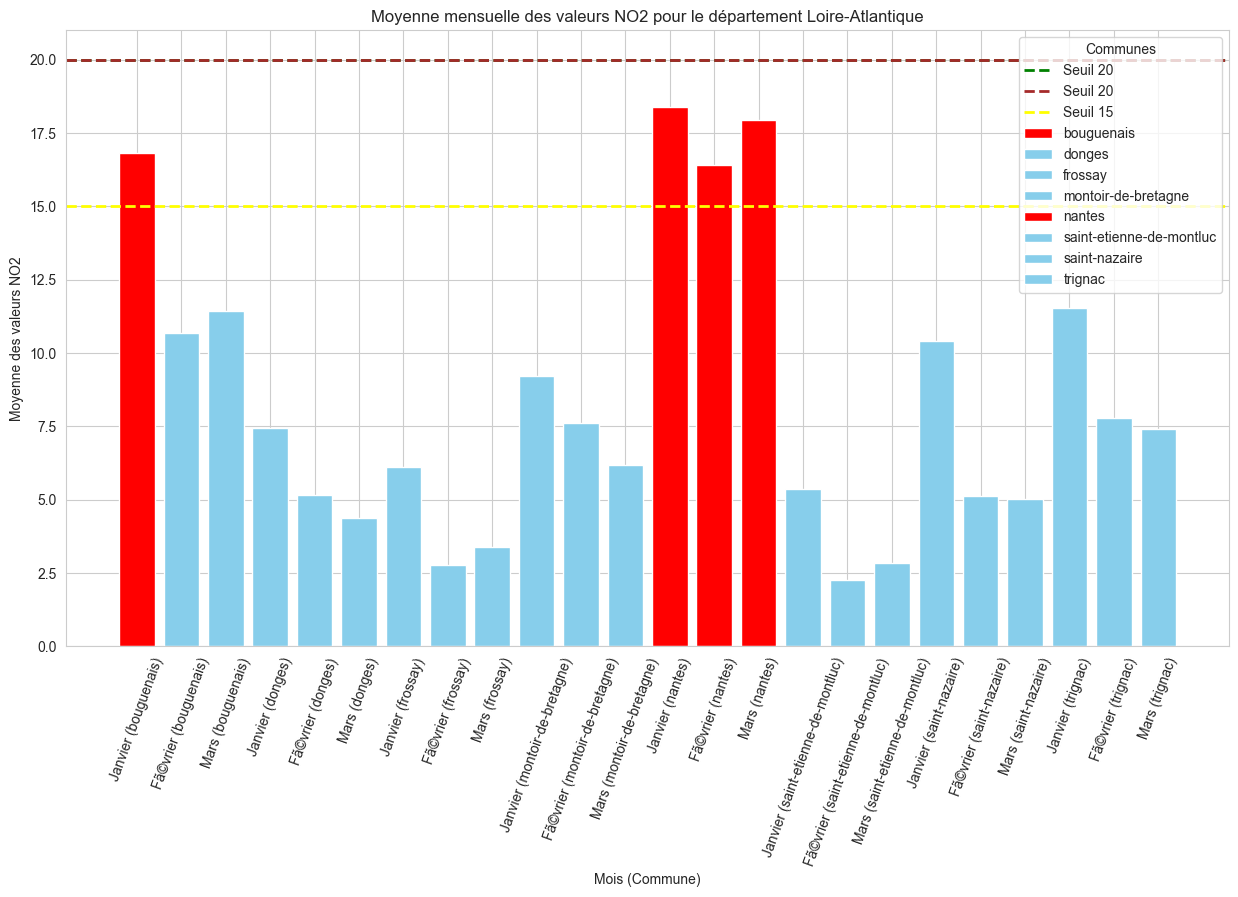

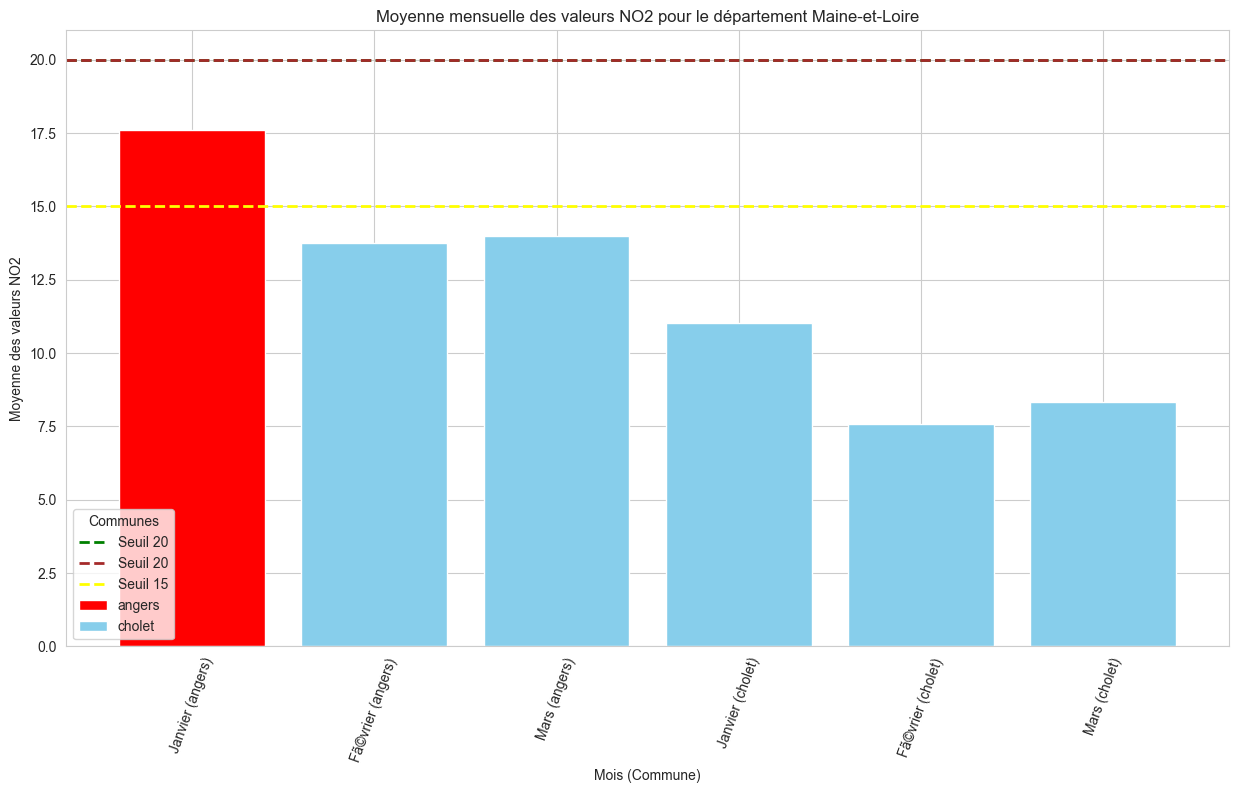

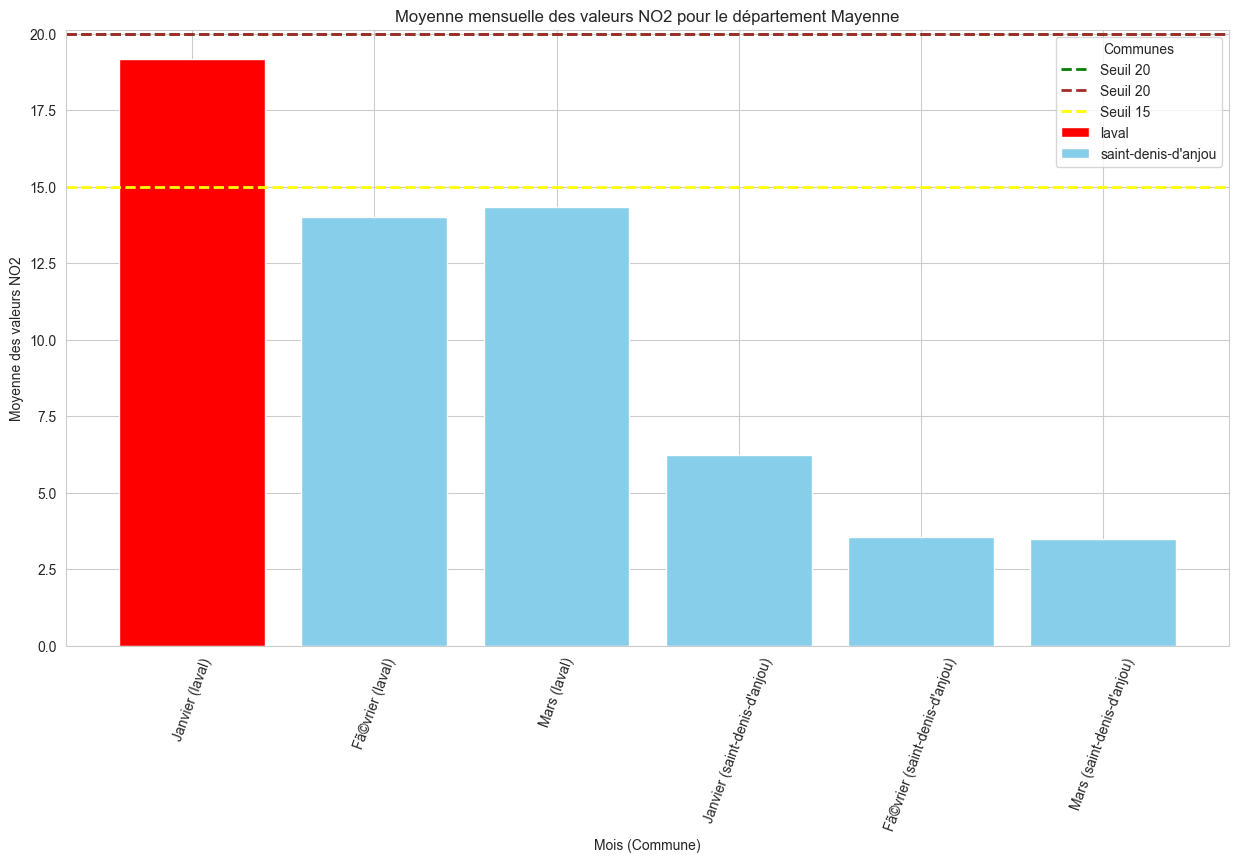

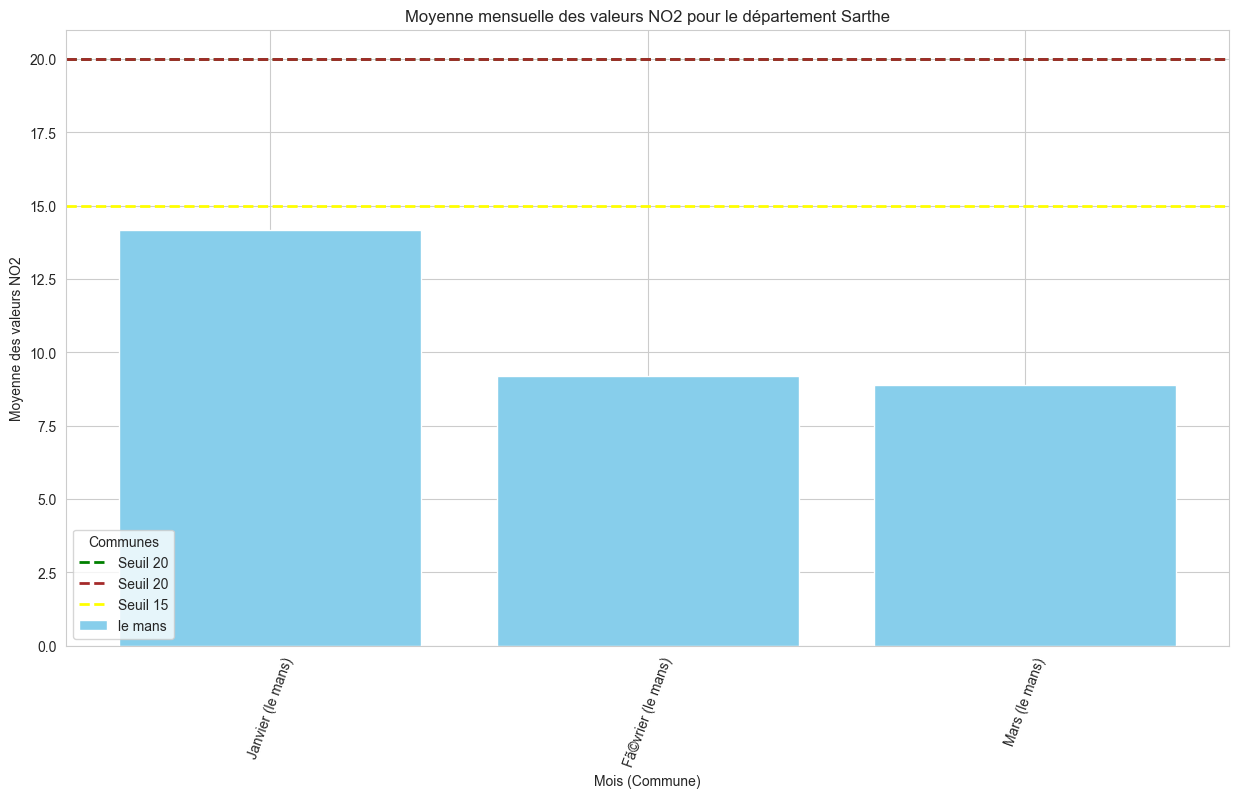

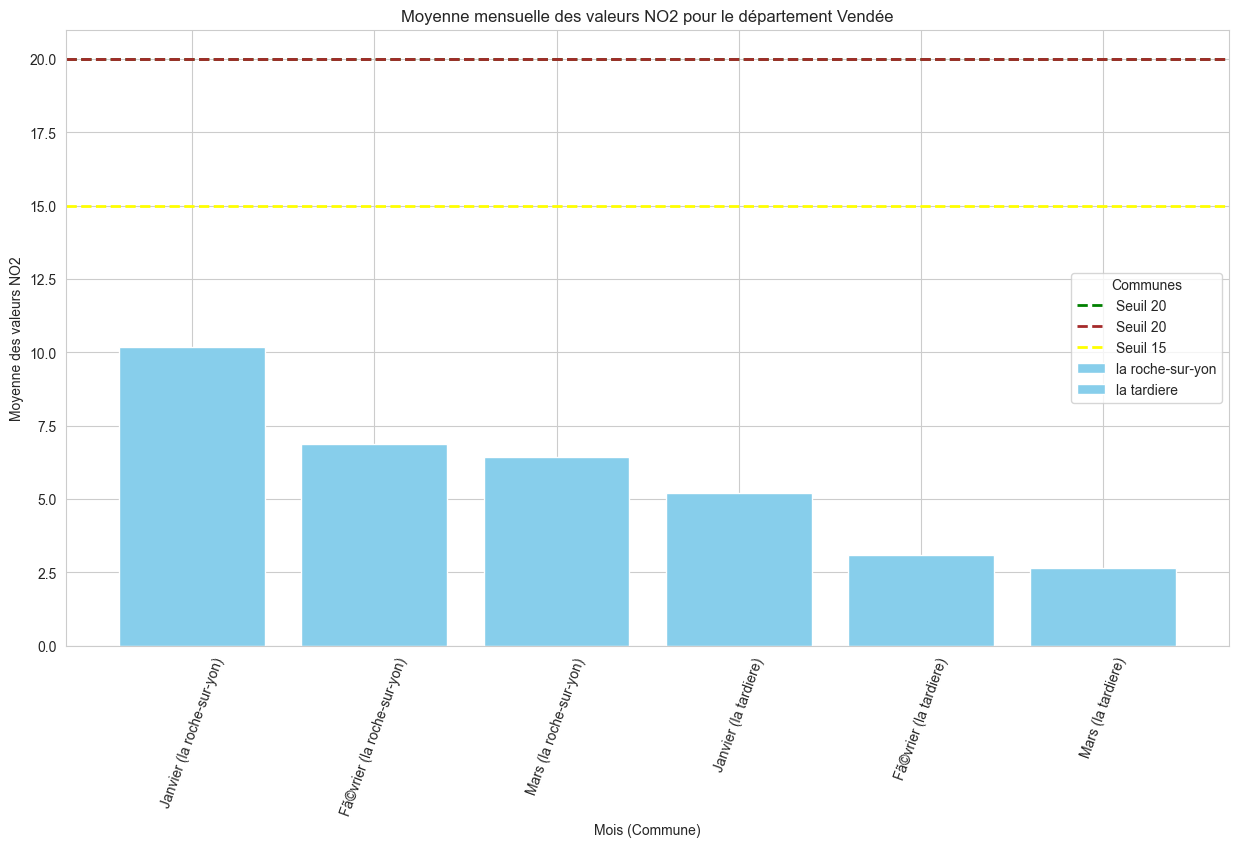

In [8]:
import locale
import calendar
import matplotlib.pyplot as plt

# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Ajouter la colonne 'mois' pour grouper par mois
dfNO2['mois'] = dfNO2['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de NO2 pour chaque département et chaque commune
monthly_means = dfNO2.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = (
    (monthly_means['valeur'] > OBJECTIF_QUALITE_NO2) |
    (monthly_means['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2) |
    (monthly_means['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2)
)

# Obtenir la liste des départements uniques
departments = monthly_means['departement_nom'].unique()

# Créer un graphique en barres pour chaque département regroupant les communes
for department in departments:
    dept_data = monthly_means[monthly_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Grouper les communes dans le département
    communes = dept_data['nom_commune'].unique()
    for commune in communes:
        commune_data = dept_data[dept_data['nom_commune'] == commune]
        colors = ['red' if x else 'skyblue' for x in commune_data['depasse_seuil']]
        bars = plt.bar(commune_data['mois_lettres'] + " (" + commune + ")", commune_data['valeur'], color=colors, label=commune)
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=OBJECTIF_QUALITE_NO2, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_NO2}')
    plt.axhline(y=VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2, color='brown', linestyle='--', linewidth=2, label=f'Seuil {VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2}')
    plt.axhline(y=NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2, color='yellow', linestyle='--', linewidth=2, label=f'Seuil {NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2}')
    
    plt.xlabel('Mois (Commune)')
    plt.ylabel('Moyenne des valeurs NO2')
    plt.title(f'Moyenne mensuelle des valeurs NO2 pour le département {department}')
    plt.legend(title='Communes')
    plt.xticks(rotation=70)  # Rotation pour mieux afficher les noms des communes et des mois
    plt.show()


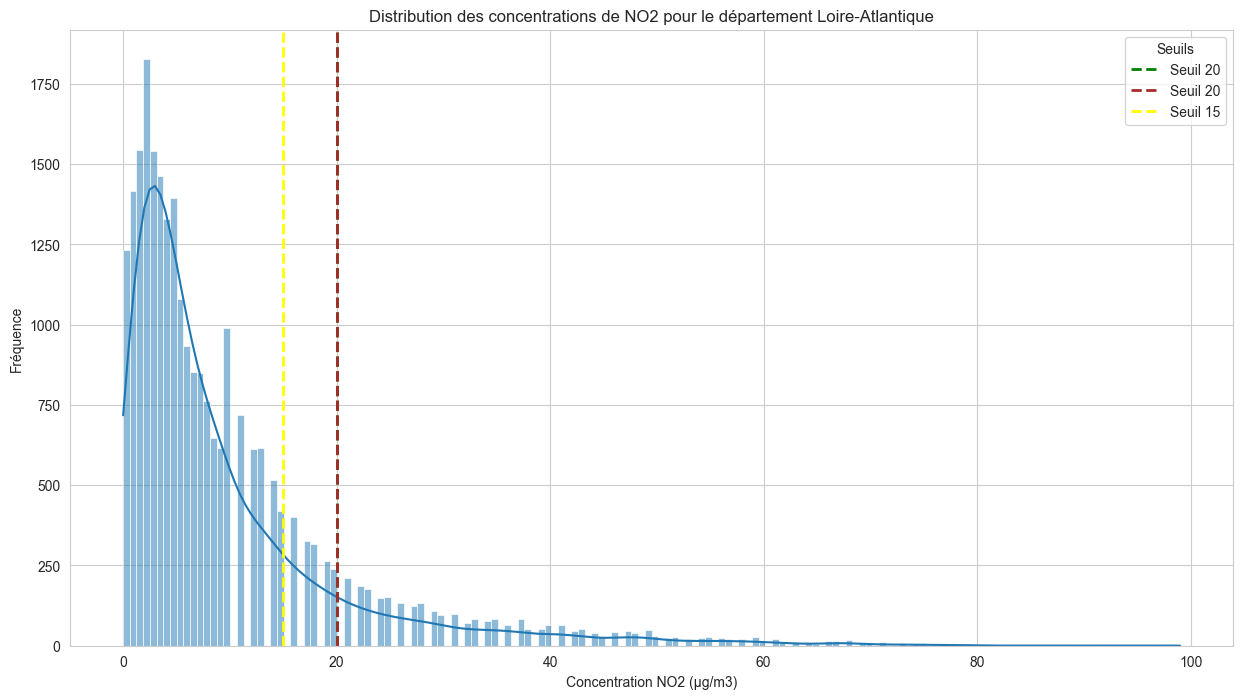

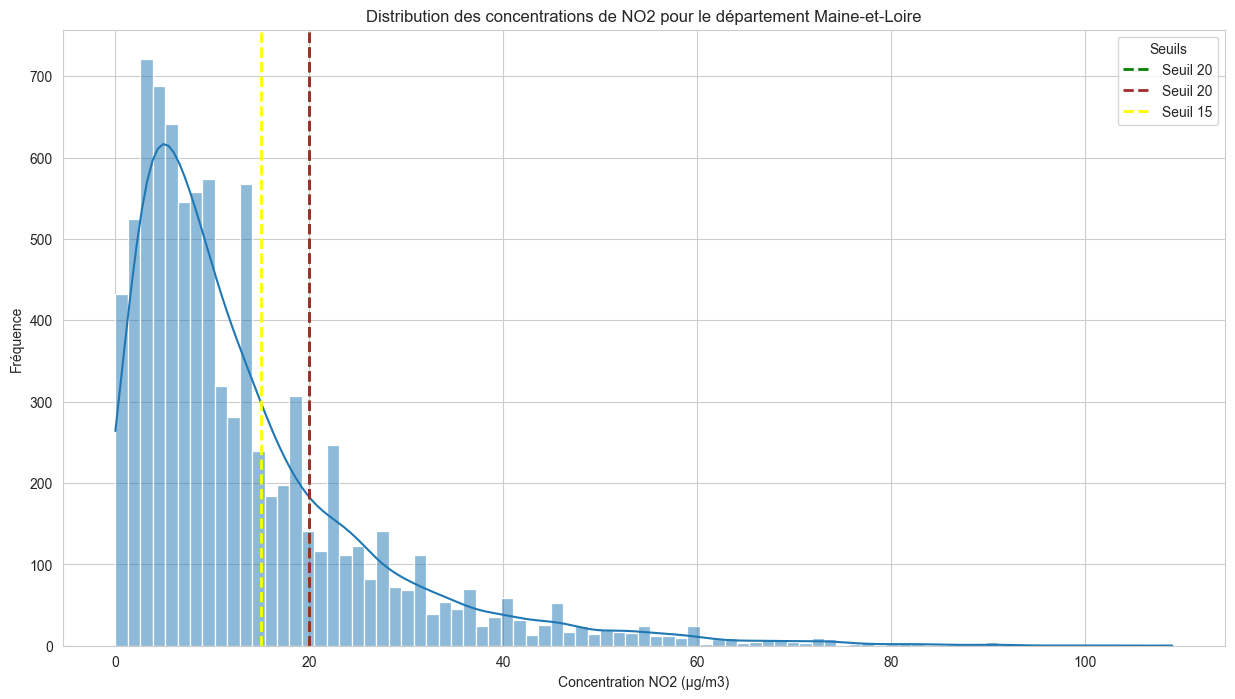

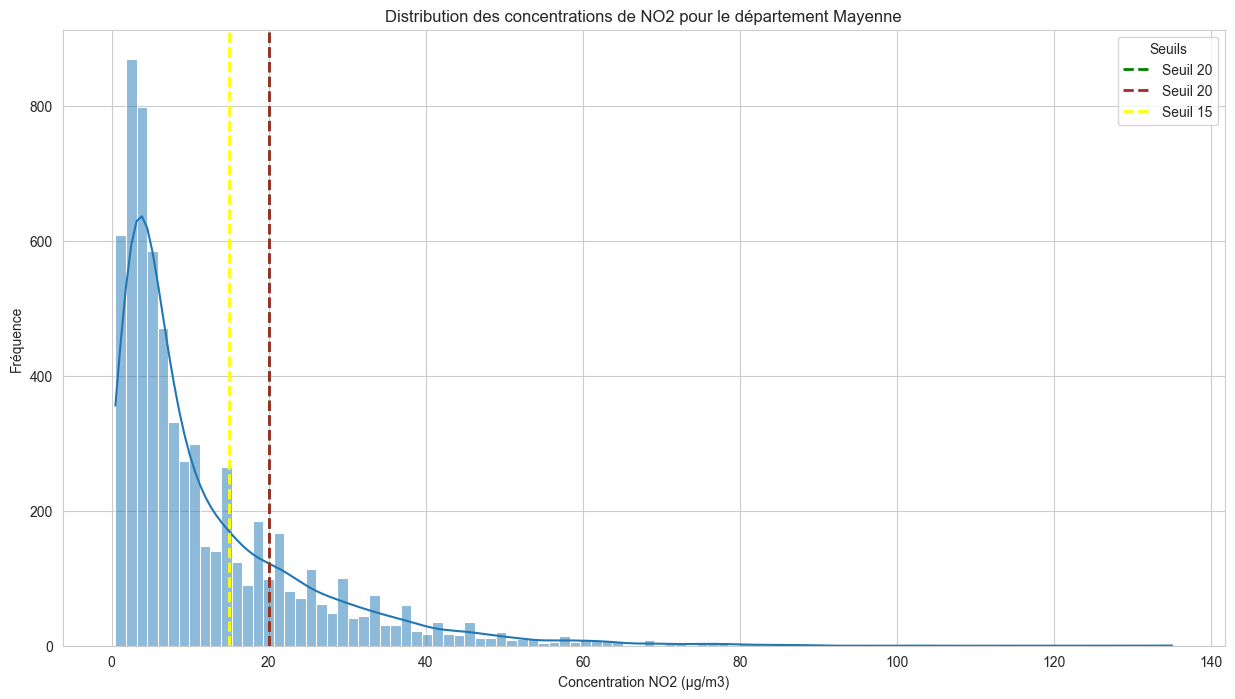

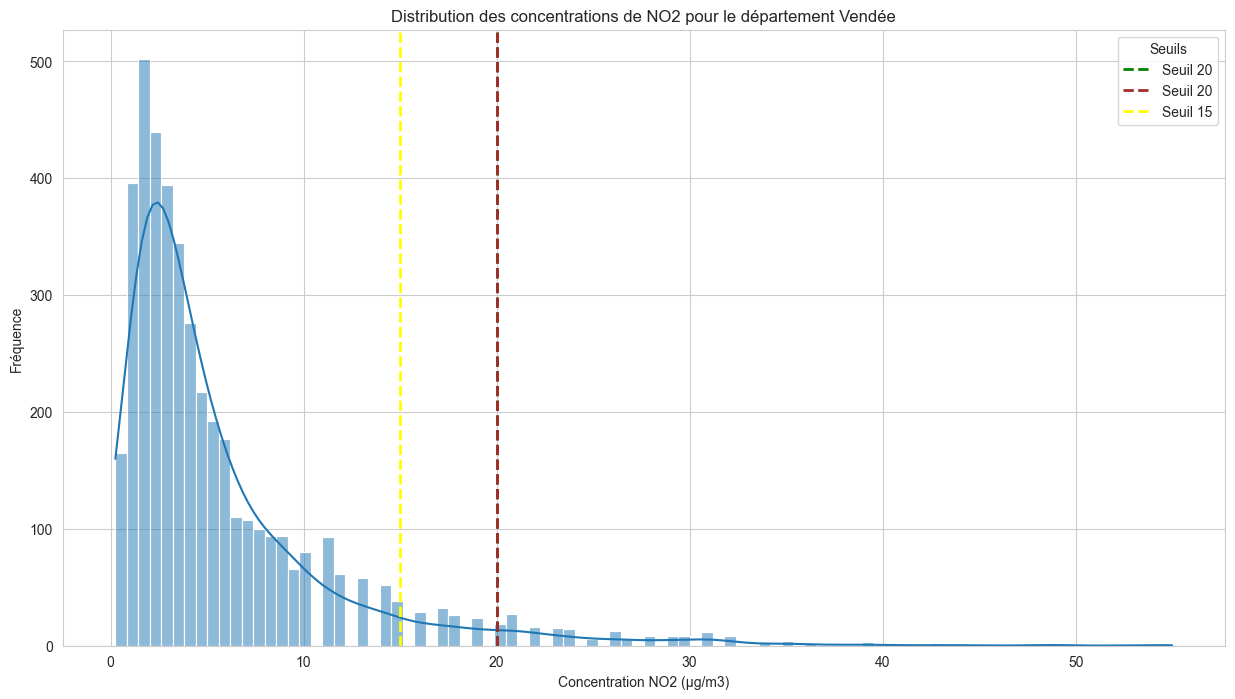

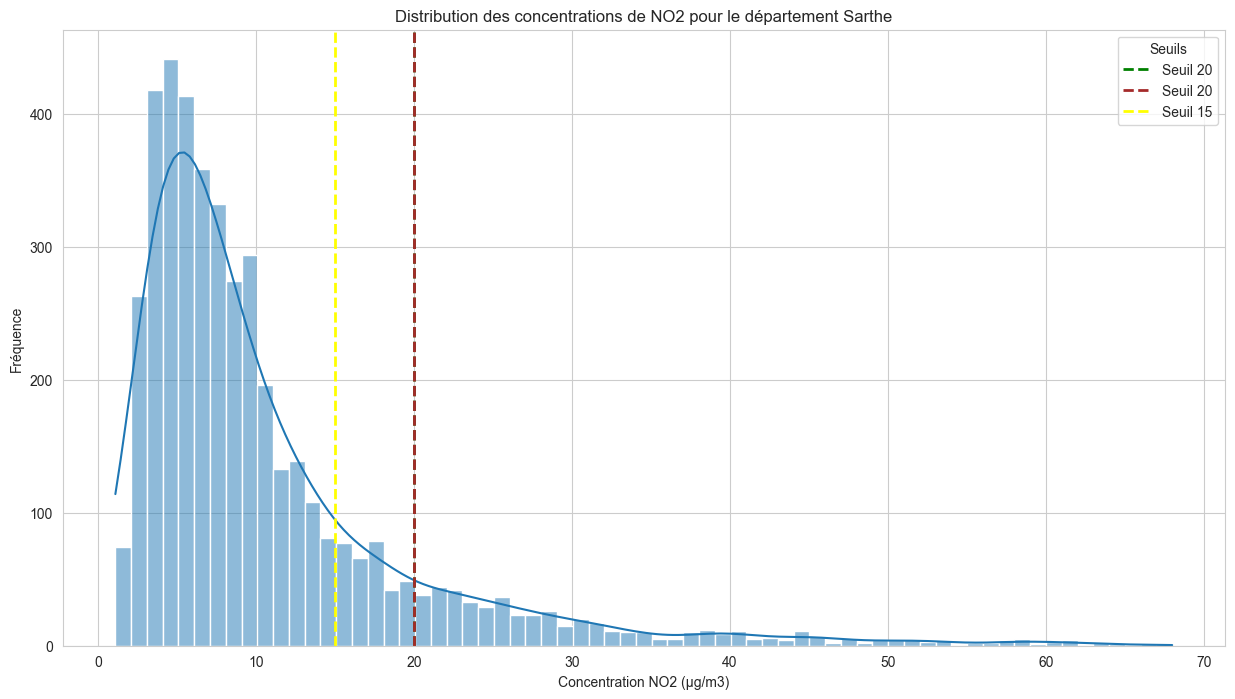

In [9]:
# Assurez-vous que 'departments' est une liste contenant les noms des départements à tracer
departments = dfNO2['departement_nom'].unique()

# Créer un histogramme pour chaque département
for department in departments:
    plt.figure(figsize=(15, 8))
    dept_data = dfNO2[dfNO2['departement_nom'] == department]
    
    sns.histplot(dept_data['valeur'], kde=True)
    
    plt.axvline(x=OBJECTIF_QUALITE_NO2, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_NO2}')
    plt.axvline(x=VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2, color='brown', linestyle='--', linewidth=2, label=f'Seuil {VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2}')
    plt.axvline(x=NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2, color='yellow', linestyle='--', linewidth=2, label=f'Seuil {NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2}')

    plt.xlabel('Concentration NO2 (µg/m3)')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des concentrations de NO2 pour le département {department}')
    plt.legend(title='Seuils')
    plt.show()


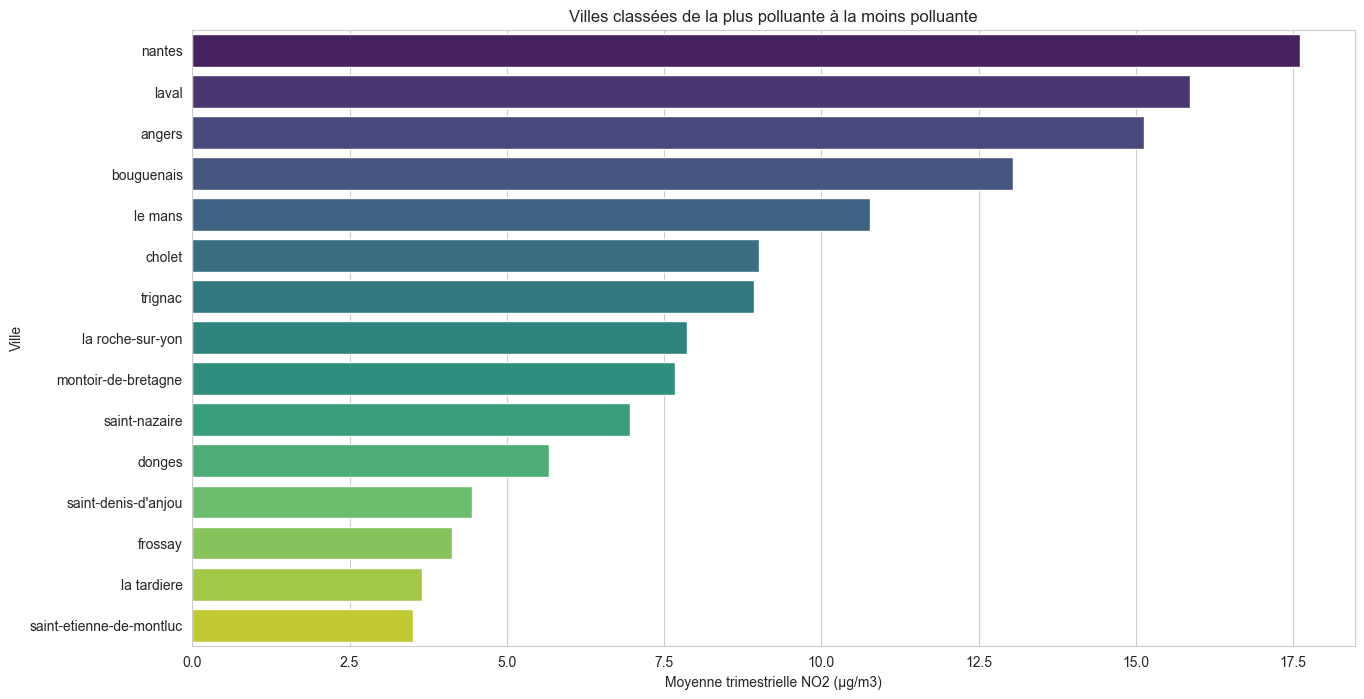

In [10]:
# Calculer la moyenne annuelle de NO2 pour chaque ville
city_means = dfNO2.groupby('nom_commune')['valeur'].mean().reset_index()

# Trier les villes de la plus polluante à la moins polluante
city_means = city_means.sort_values(by='valeur', ascending=False)

# Créer un graphique en bâtons pour les villes
plt.figure(figsize=(15, 8))
sns.barplot(data=city_means, x='valeur', y='nom_commune', hue='nom_commune', dodge=False, palette='viridis', legend=False)

plt.xlabel('Moyenne trimestrielle NO2 (µg/m3)')
plt.ylabel('Ville')
plt.title('Villes classées de la plus polluante à la moins polluante')
plt.show()


### les valeurs pour le premier trimestre 2024 dépassent le seuil d'information et de recommandation (SEUIL_INFO_RECO),


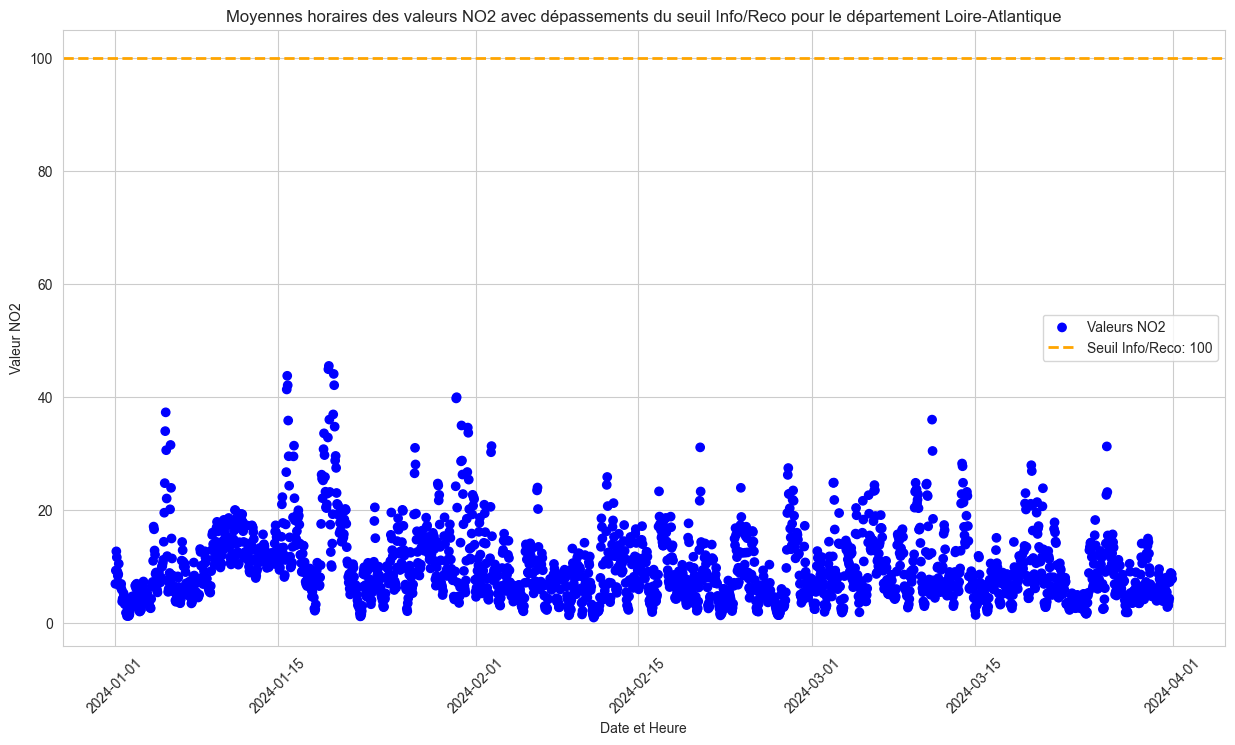

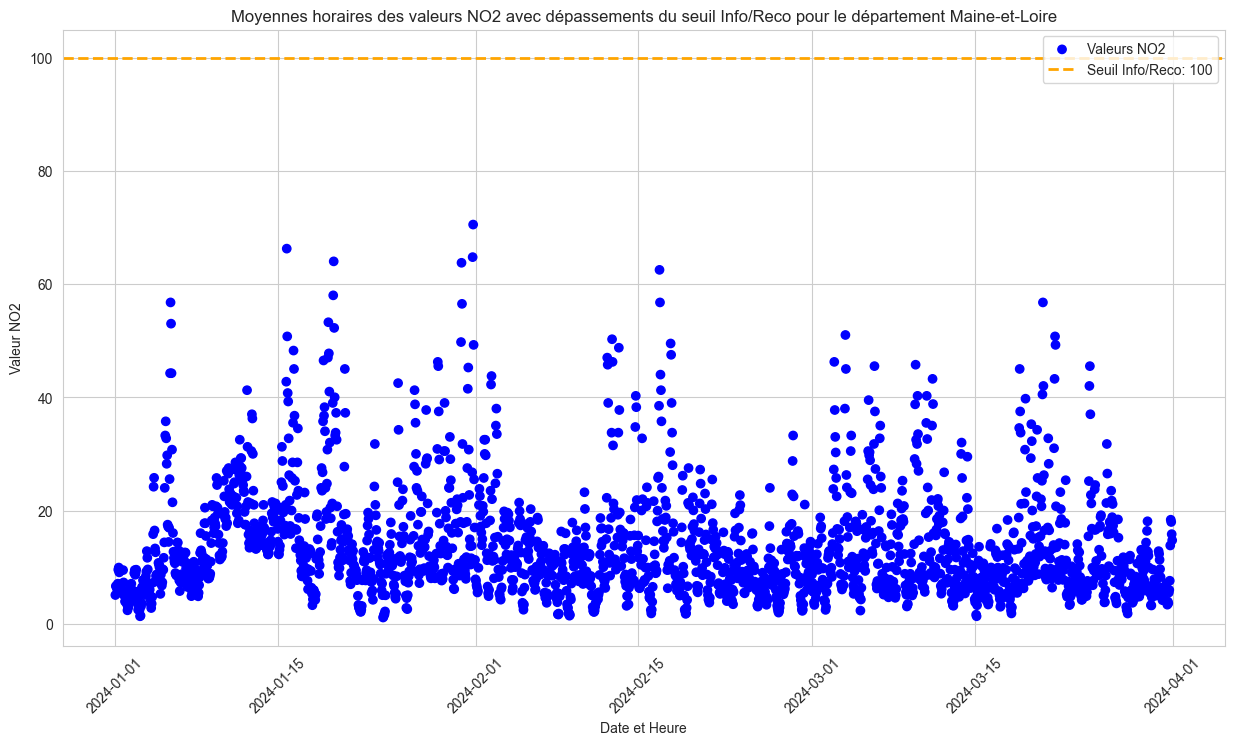

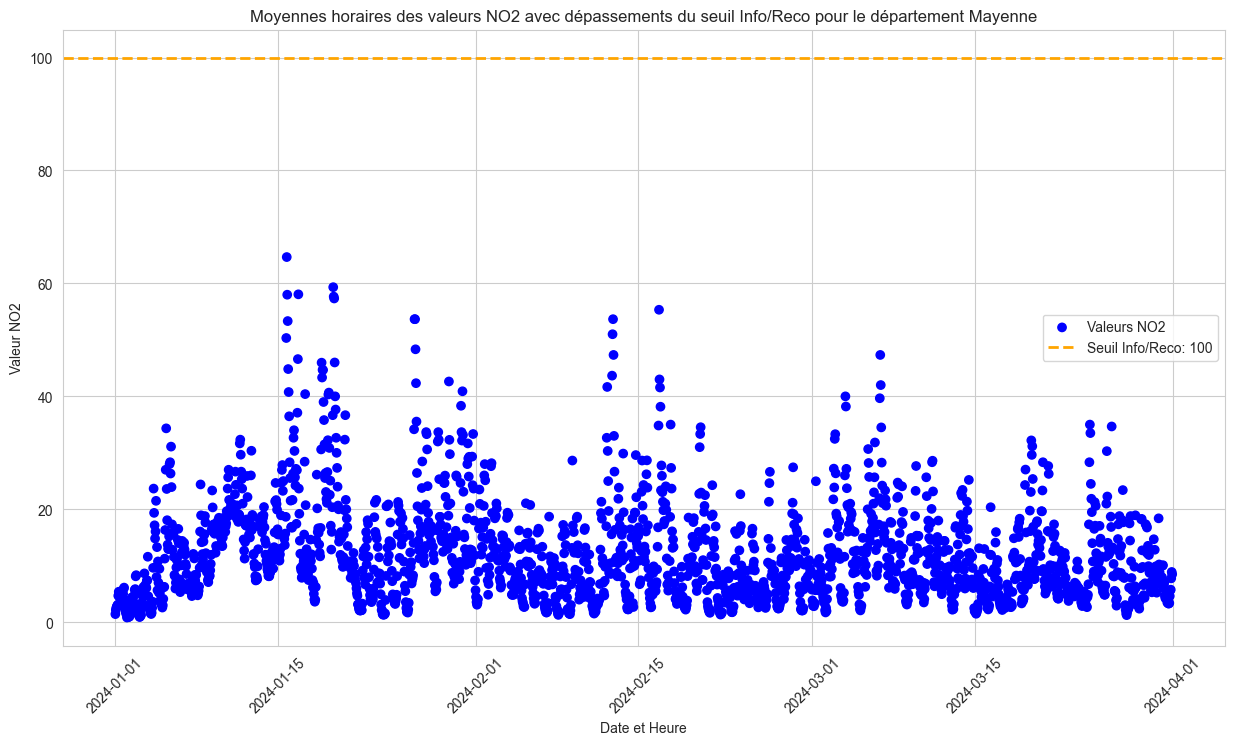

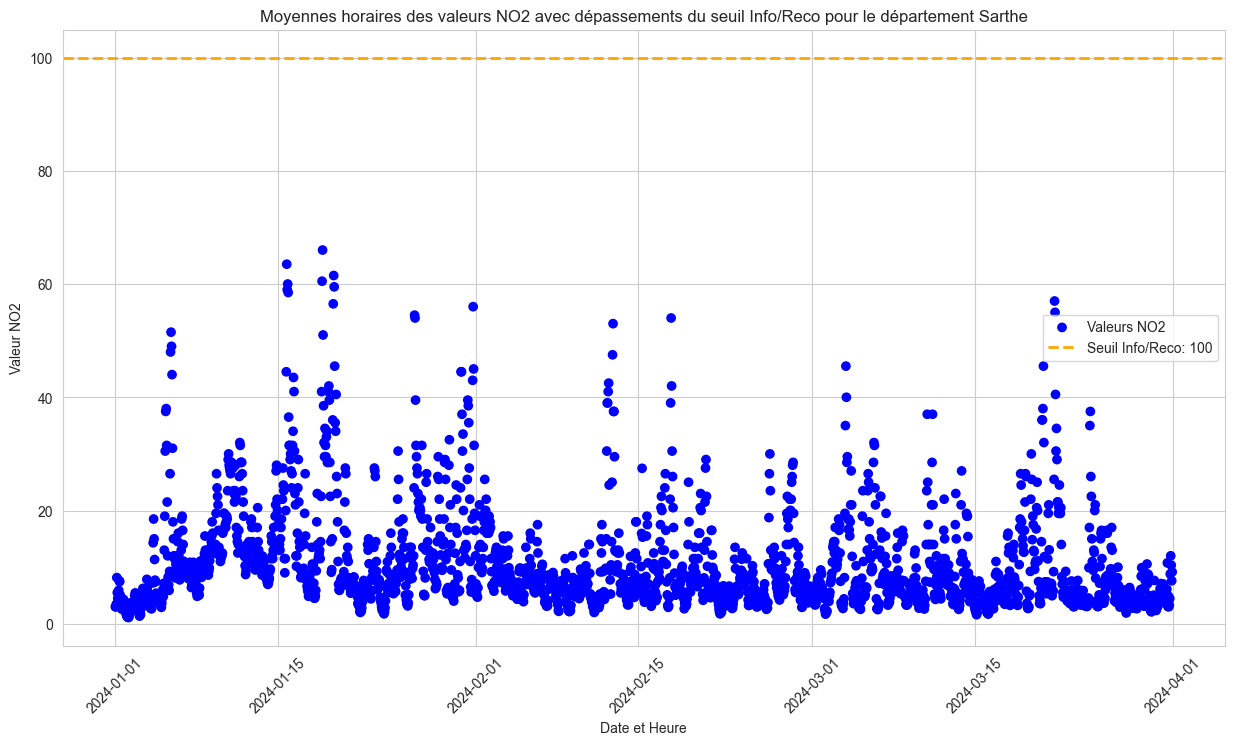

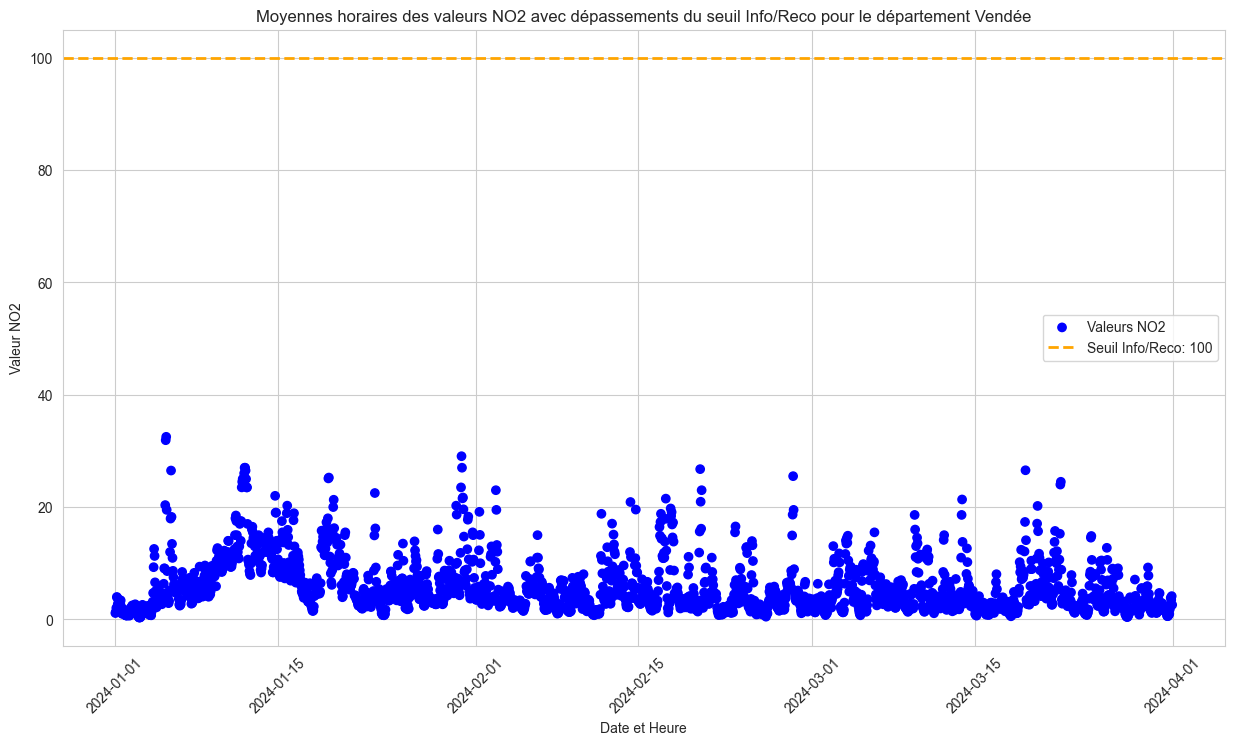

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Ajouter la colonne 'heure' pour grouper par heure
dfNO2['heure'] = dfNO2['date_heure_tu'].dt.floor('h')

# Calculer la moyenne horaire des valeurs de NO2 par département
hourly_means = dfNO2.groupby(['heure', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne horaire dépasse le seuil d'information et de recommandation
hourly_means['depasse_seuil_info_reco'] = hourly_means['valeur'] > SEUIL_INFO_RECO

# Obtenir la liste des départements uniques
departments = hourly_means['departement_nom'].unique()

# Créer un graphique pour chaque département
for department in departments:
    dept_data = hourly_means[hourly_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Tracer les valeurs avec une couleur différente pour celles qui dépassent le seuil
    colors = ['red' if x else 'blue' for x in dept_data['depasse_seuil_info_reco']]
    plt.scatter(dept_data['heure'], dept_data['valeur'], c=colors, label='Valeurs NO2')
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=SEUIL_INFO_RECO, color='orange', linestyle='--', linewidth=2, label=f'Seuil Info/Reco: {SEUIL_INFO_RECO}')
    
    plt.xlabel('Date et Heure')
    plt.ylabel('Valeur NO2')
    plt.title(f'Moyennes horaires des valeurs NO2 avec dépassements du seuil Info/Reco pour le département {department}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


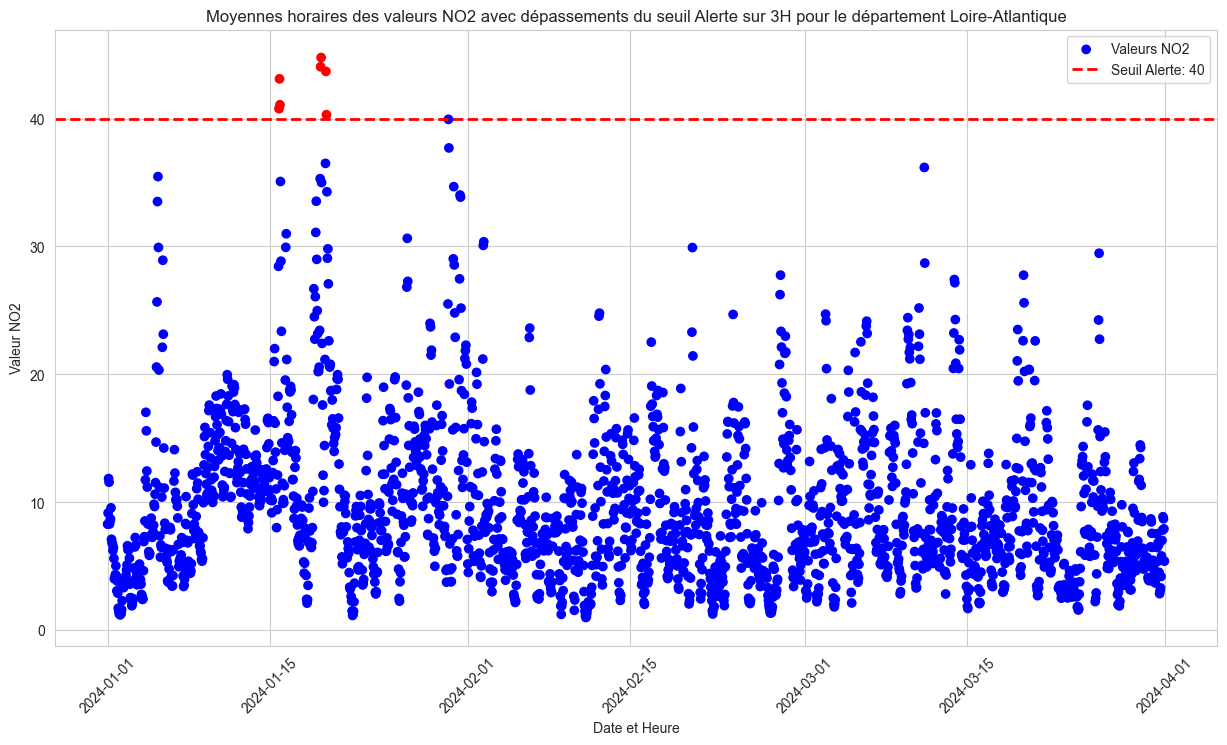

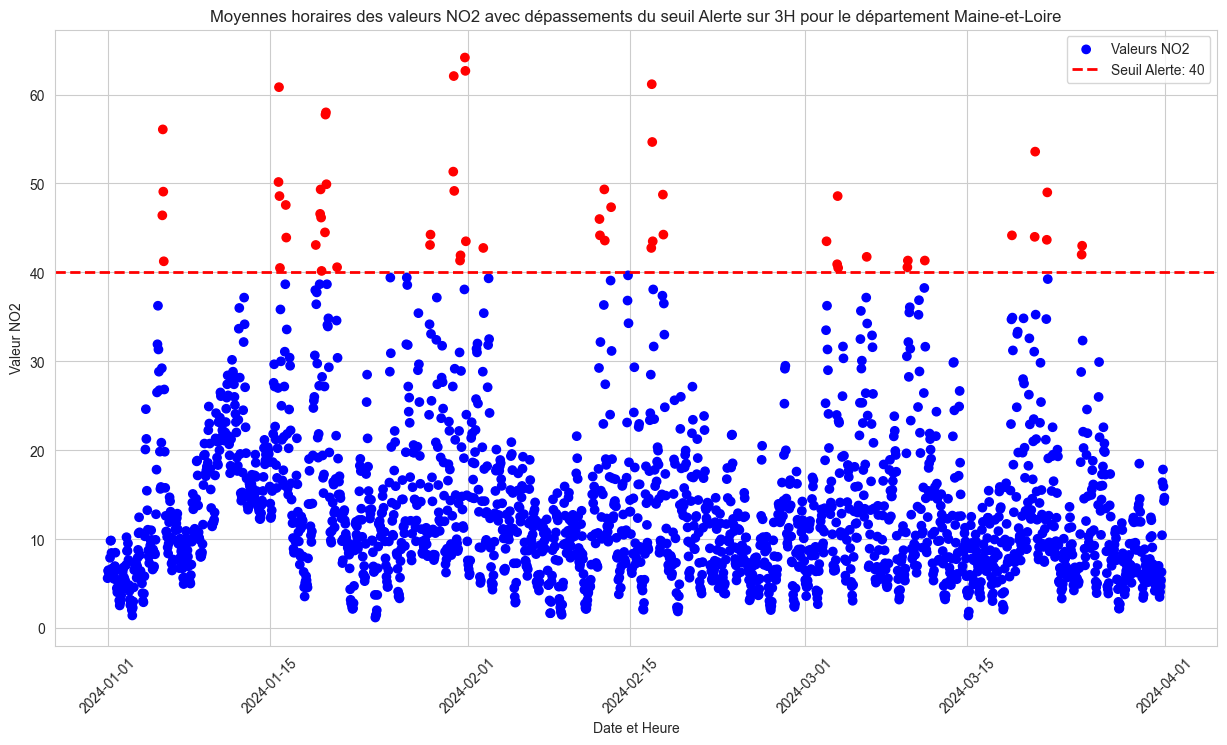

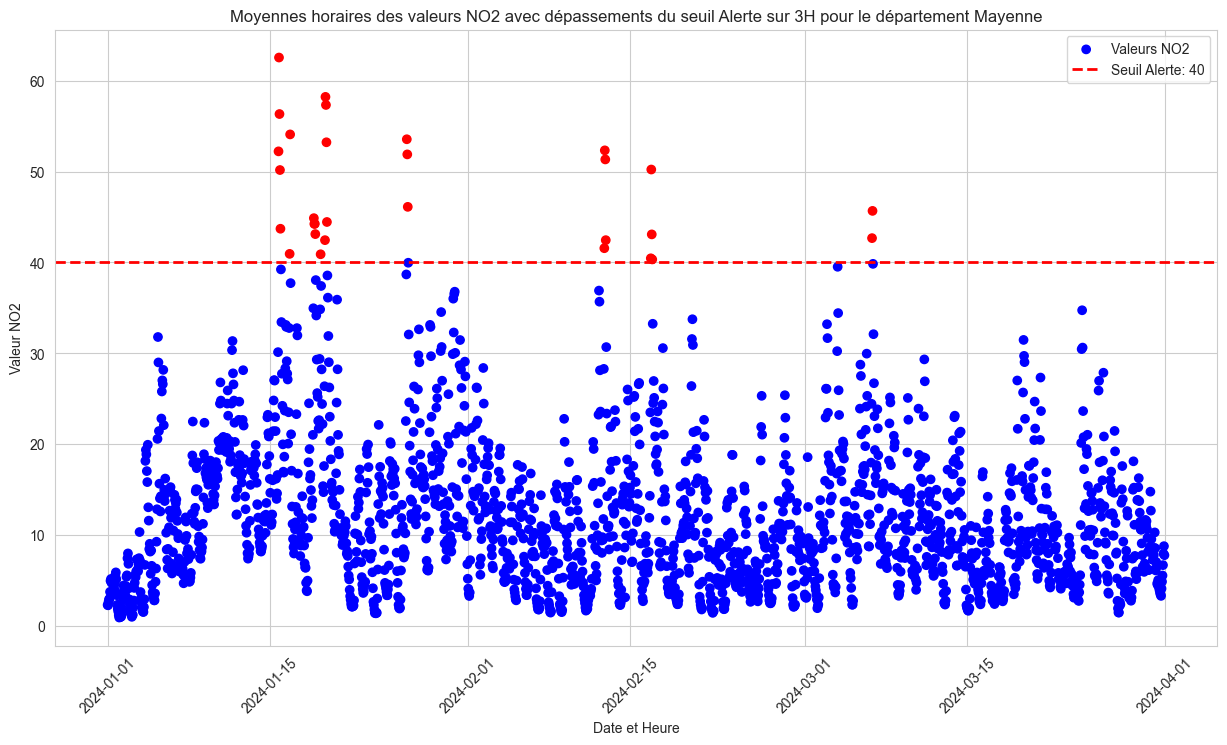

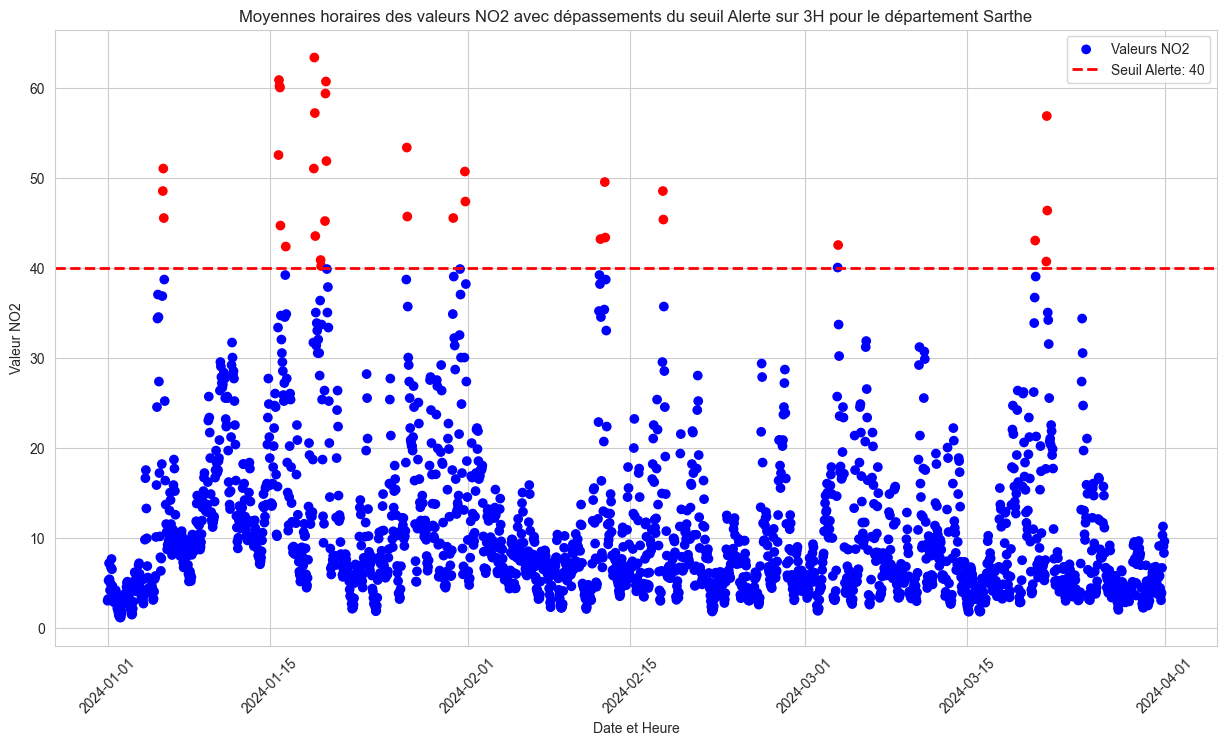

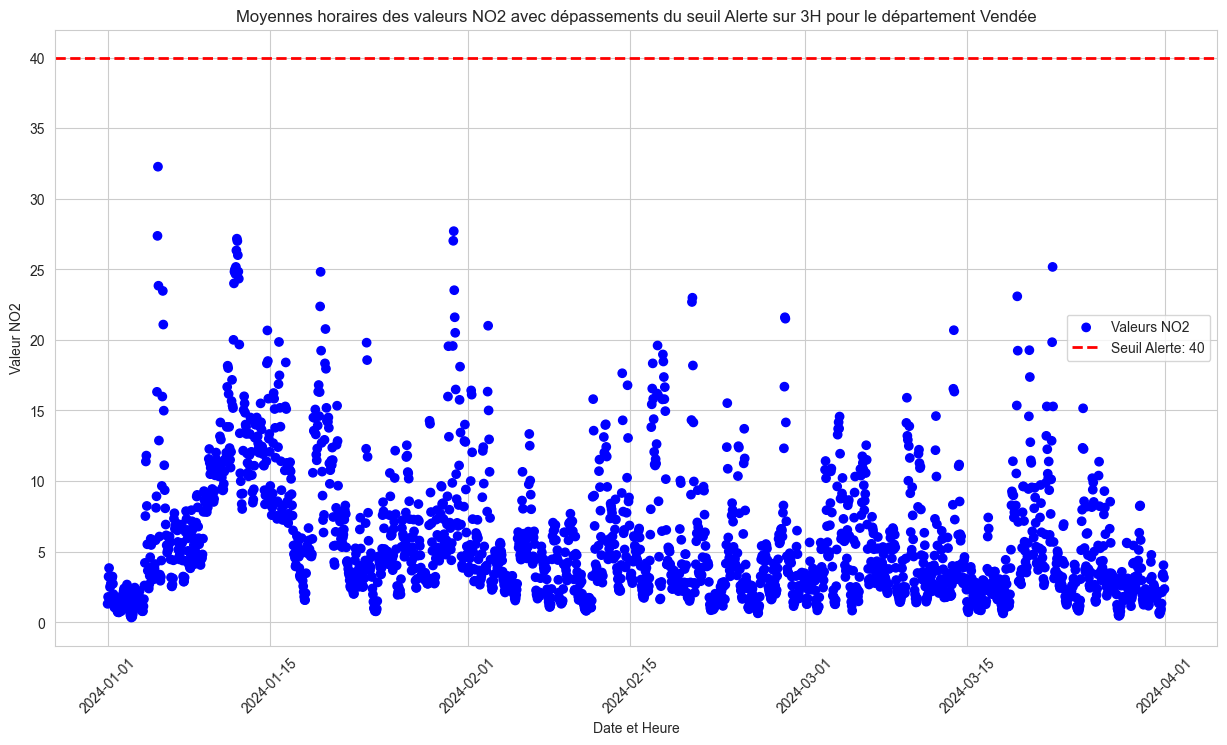

In [12]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Ajouter la colonne 'heure' pour grouper par heure
dfNO2['heure'] = dfNO2['date_heure_tu'].dt.floor('h')

# Calculer la moyenne mobile sur 3 heures des valeurs de NO2
dfNO2['moyenne_3h'] = dfNO2.groupby('departement_nom')['valeur'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

# Calculer la moyenne horaire des valeurs de NO2
hourly_means = dfNO2.groupby(['heure', 'departement_nom'])['moyenne_3h'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne mobile sur 3 heures dépasse le seuil d'alerte
hourly_means['depasse_seuil_alerte'] = hourly_means['moyenne_3h'] > SEUIL_ALERTE

# Créer un graphique pour chaque département
departments = hourly_means['departement_nom'].unique()
for department in departments:
    dept_data = hourly_means[hourly_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Tracer les valeurs avec une couleur différente pour celles qui dépassent le seuil
    colors = ['red' if x else 'blue' for x in dept_data['depasse_seuil_alerte']]
    plt.scatter(dept_data['heure'], dept_data['moyenne_3h'], c=colors, label='Valeurs NO2')
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=SEUIL_ALERTE, color='red', linestyle='--', linewidth=2, label=f'Seuil Alerte: {SEUIL_ALERTE}')
    
    plt.xlabel('Date et Heure')
    plt.ylabel('Valeur NO2')
    plt.title(f'Moyennes horaires des valeurs NO2 avec dépassements du seuil Alerte sur 3H pour le département {department}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


## Fusion des données avec le jeu de données dfPopulation

In [13]:
import importlib
import population

# Recharger le module pour prendre en compte les modifications
importlib.reload(population)

# Importer la fonction depuis le fichier Python
from population import fetch_and_process_population_data

# Utilisation de la fonction importée
base_url = "https://data.paysdelaloire.fr/api/explore/v2.1/catalog/datasets/12002701600563_population_pays_de_la_loire_2019_communes_epci/records"
dfPopulation = fetch_and_process_population_data(base_url)

# Afficher les premières lignes du DataFrame dfPopulation pour vérifier les modifications
print(dfPopulation.head())

# Afficher les types de colonnes pour vérifier les conversions
print(dfPopulation.dtypes)

Total records retrieved: 1238
   code_region  nom_de_la_region  code_departement  code_arrondissement  \
0           52  Pays de la Loire                44                    3   
1           52  Pays de la Loire                44                    2   
2           52  Pays de la Loire                44                    3   
3           52  Pays de la Loire                44                    2   
4           52  Pays de la Loire                44                    3   

   code_canton  code_commune nom_de_la_commune  population_municipale  \
0            9         44006           asserac                 1790.0   
1           21         44018            bouaye                 7844.0   
2           89         44005   chaumes-en-retz                 6759.0   
3           24         44047           coueron                21372.0   
4            2         44049        le croisic                 4093.0   

   population_comptee_a_part  population_totale  \
0                       32.0 

In [14]:
# Fusionner les deux DataFrames en utilisant les colonnes 'nom_commune' et 'nom_de_la_commune' avec une jointure externe gauche
if 'nom_commune' in dfNO2.columns and 'nom_de_la_commune' in dfPopulation.columns:
    dfMerged = pd.merge(dfNO2, dfPopulation, left_on='nom_commune', right_on='nom_de_la_commune', how='left', suffixes=('_NO2', '_pop'))
    
    # Sauvegarder le DataFrame fusionné pour utilisation ultérieure
    dfMerged.to_pickle('MergedData.pkl')

    # Afficher les premières lignes du DataFrame fusionné
    print("dfMerged:")
    print(dfMerged.head())
else:
    print("Les colonnes de fusion 'nom_commune' et 'nom_de_la_commune' ne sont pas présentes dans les DataFrames. Vérifiez les colonnes disponibles.")

# Charger le DataFrame depuis le fichier sauvegardé
dfNO2 = pd.read_pickle('MergedData.pkl')

# Afficher les types de chaque colonne
print(dfNO2.dtypes)

dfMerged:
                                 id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_NO2_A              3               FR23003_NO2   
1  2024-03-31 23:00:00FR23068_NO2_A              3               FR23068_NO2   
2  2024-03-31 23:00:00FR23070_NO2_A              3               FR23070_NO2   
3  2024-03-31 23:00:00FR23075_NO2_A              3               FR23075_NO2   
4  2024-03-31 23:00:00FR23078_NO2_A              3               FR23078_NO2   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    donges   
1      FR23068                   FROSSAY                   frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  saint-etienne-de-montluc   
3      FR23075               JULES VERNE                   trignac   
4      FR23078             SAINT EXUPERY                    cholet   

   code_commune_NO2  departement_code   departement_nom  code_zone_affichage  \
0       

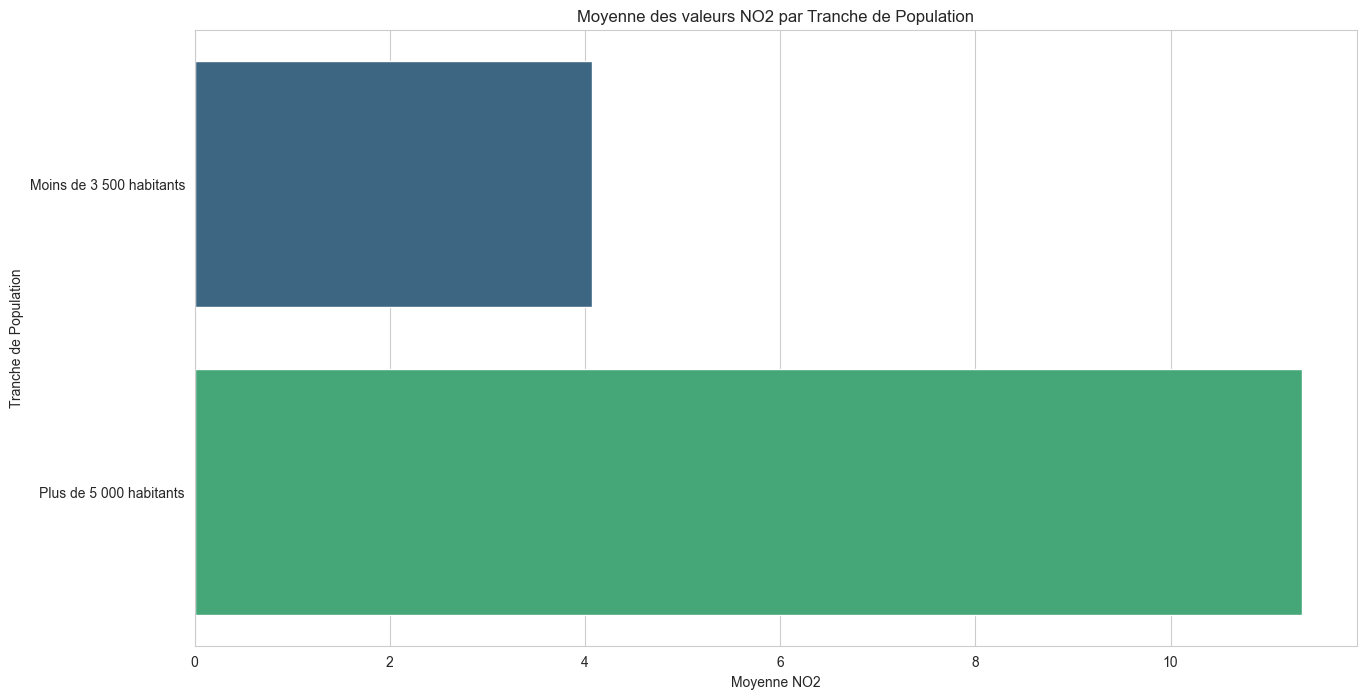

In [15]:
# Vérifier si la colonne 'tranche_population' existe
if 'tranche_population' in dfNO2.columns:
    # Calculer la moyenne de NO2 pour chaque tranche de population
    population_means = dfNO2.groupby('tranche_population')['valeur'].mean().reset_index()

    # Trier les tranches de population pour un affichage ordonné
    population_means = population_means.sort_values('tranche_population')

    # Créer un graphique en barres
    plt.figure(figsize=(15, 8))
    sns.barplot(data=population_means, x='valeur', y='tranche_population', palette='viridis', hue='tranche_population', dodge=False, legend=False)

    plt.xlabel('Moyenne NO2')
    plt.ylabel('Tranche de Population')
    plt.title('Moyenne des valeurs NO2 par Tranche de Population')
    plt.show()
else:
    print("La colonne 'tranche_population' n'existe pas dans le DataFrame.")


## Ajout d'alerte quand les variables de seuils sont dépassées
### Pour les valeurs de l'objectif de la qualité mensuel

In [16]:
import pandas as pd
import calendar

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Grouper les données par année, mois, département et commune
dfNO2['année'] = dfNO2['date_heure_tu'].dt.year
dfNO2['mois'] = dfNO2['date_heure_tu'].dt.month
grouped = dfNO2.groupby(['année', 'mois', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped['valeur'] = grouped['valeur'].round(1)

# Créer les colonnes indiquant si la moyenne mensuelle dépasse les seuils
grouped['depasse_objectif_qualite'] = grouped['valeur'] > OBJECTIF_QUALITE_NO2
grouped['depasse_valeur_limite_sante'] = grouped['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2
grouped['depasse_niveau_critique_vegetation'] = grouped['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2

# Extraire les mois en lettres
grouped['mois_lettres'] = grouped['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_qualite = grouped[grouped['depasse_objectif_qualite']]
alertes_sante = grouped[grouped['depasse_valeur_limite_sante']]
alertes_vegetation = grouped[grouped['depasse_niveau_critique_vegetation']]

# Afficher les alertes par type pour les moyennes mensuelles avec le département et la commune
if not alertes_qualite.empty:
    print("Alertes pour l'Objectif de Qualité mensuel:")
    for index, row in alertes_qualite.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse l'Objectif de Qualité mensuel ({OBJECTIF_QUALITE_NO2} µg/m3) en {row['mois_lettres']} {row['année']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour l'Objectif de Qualité mensuel.")

if not alertes_sante.empty:
    print("Alertes pour la Valeur Limite de Protection de la Santé Humaine:")
    for index, row in alertes_sante.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse la Valeur Limite de Protection de la Santé Humaine ({VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2} µg/m3) en {row['mois_lettres']} {row['année']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour la Valeur Limite de Protection de la Santé Humaine.")

if not alertes_vegetation.empty:
    print("Alertes pour le Niveau Critique de Protection de la Végétation:")
    for index, row in alertes_vegetation.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse le Niveau Critique de Protection de la Végétation ({NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2} µg/m3) en {row['mois_lettres']} {row['année']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Niveau Critique de Protection de la Végétation.")


Aucune alerte pour l'Objectif de Qualité mensuel.
Aucune alerte pour la Valeur Limite de Protection de la Santé Humaine.
Alertes pour le Niveau Critique de Protection de la Végétation:
Alerte: Valeur moyenne 16.8 µg/m3 dépasse le Niveau Critique de Protection de la Végétation (15 µg/m3) en janvier 2024 dans la commune bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 18.4 µg/m3 dépasse le Niveau Critique de Protection de la Végétation (15 µg/m3) en janvier 2024 dans la commune nantes du département Loire-Atlantique
Alerte: Valeur moyenne 17.6 µg/m3 dépasse le Niveau Critique de Protection de la Végétation (15 µg/m3) en janvier 2024 dans la commune angers du département Maine-et-Loire
Alerte: Valeur moyenne 19.2 µg/m3 dépasse le Niveau Critique de Protection de la Végétation (15 µg/m3) en janvier 2024 dans la commune laval du département Mayenne
Alerte: Valeur moyenne 16.4 µg/m3 dépasse le Niveau Critique de Protection de la Végétation (15 µg/m3) en fÃ©vrier 2024 dans la

### Pour les valeurs du seuil d’information et de recommandation 

In [17]:
import pandas as pd
import calendar

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Grouper les données par département, commune et par heure
dfNO2['date_heure'] = dfNO2['date_heure_tu'].dt.floor('h')  # Utiliser 'h' au lieu de 'H'
grouped_hourly = dfNO2.groupby(['date_heure', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped_hourly['valeur'] = grouped_hourly['valeur'].round(1)

# Créer la colonne indiquant si la moyenne horaire dépasse le seuil
grouped_hourly['depasse_seuil_info_reco'] = grouped_hourly['valeur'] > SEUIL_INFO_RECO

# Extraire l'année, le mois, le jour et l'heure pour l'affichage
grouped_hourly['année'] = grouped_hourly['date_heure'].dt.year
grouped_hourly['mois'] = grouped_hourly['date_heure'].dt.month
grouped_hourly['jour'] = grouped_hourly['date_heure'].dt.day
grouped_hourly['heure'] = grouped_hourly['date_heure'].dt.hour
grouped_hourly['mois_lettres'] = grouped_hourly['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_seuil_info_reco = grouped_hourly[grouped_hourly['depasse_seuil_info_reco']]

# Afficher les alertes par type pour les moyennes horaires avec le département et la commune
if not alertes_seuil_info_reco.empty:
    print("Alertes pour le Seuil d'Information et de Recommandation horaire:")
    for index, row in alertes_seuil_info_reco.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse le Seuil d'Information et de Recommandation ({SEUIL_INFO_RECO} µg/m3) le {row['jour']} {row['mois_lettres']} {row['année']} à {row['heure']}h dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Seuil d'Information et de Recommandation horaire.")


Aucune alerte pour le Seuil d'Information et de Recommandation horaire.


In [18]:
import pandas as pd
import calendar

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Grouper les données par département, commune et par heure
dfNO2['date_heure'] = dfNO2['date_heure_tu'].dt.floor('h')
grouped_hourly = dfNO2.groupby(['date_heure', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Calculer la moyenne sur 3 heures glissantes
grouped_hourly['moyenne_3h'] = grouped_hourly.groupby(['departement_nom', 'nom_commune'])['valeur'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped_hourly['valeur'] = grouped_hourly['valeur'].round(1)
grouped_hourly['moyenne_3h'] = grouped_hourly['moyenne_3h'].round(1)

# Créer la colonne indiquant si la moyenne sur 3 heures dépasse le seuil
grouped_hourly['depasse_seuil_alerte'] = grouped_hourly['moyenne_3h'] > SEUIL_ALERTE

# Extraire l'année, le mois, le jour et l'heure pour l'affichage
grouped_hourly['année'] = grouped_hourly['date_heure'].dt.year
grouped_hourly['mois'] = grouped_hourly['date_heure'].dt.month
grouped_hourly['jour'] = grouped_hourly['date_heure'].dt.day
grouped_hourly['heure'] = grouped_hourly['date_heure'].dt.hour
grouped_hourly['mois_lettres'] = grouped_hourly['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_seuil_alerte = grouped_hourly[grouped_hourly['depasse_seuil_alerte']]

# Afficher les alertes par type pour les moyennes horaires avec le département et la commune
if not alertes_seuil_alerte.empty:
    print("Alertes pour le Seuil d'Alerte sur 3 heures:")
    for index, row in alertes_seuil_alerte.iterrows():
        print(f"Alerte: Valeur moyenne sur 3h {row['moyenne_3h']} µg/m3 dépasse le Seuil d'Alerte ({SEUIL_ALERTE} µg/m3) le {row['jour']} {row['mois_lettres']} {row['année']} à {row['heure']}h dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Seuil d'Alerte sur 3 heures.")


Alertes pour le Seuil d'Alerte sur 3 heures:
Alerte: Valeur moyenne sur 3h 43.9 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 5 janvier 2024 à 7h dans la commune nantes du département Loire-Atlantique
Alerte: Valeur moyenne sur 3h 50.4 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 5 janvier 2024 à 8h dans la commune nantes du département Loire-Atlantique
Alerte: Valeur moyenne sur 3h 50.7 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 5 janvier 2024 à 9h dans la commune nantes du département Loire-Atlantique
Alerte: Valeur moyenne sur 3h 40.3 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 5 janvier 2024 à 9h dans la commune trignac du département Loire-Atlantique
Alerte: Valeur moyenne sur 3h 48.0 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 5 janvier 2024 à 9h dans la commune la roche-sur-yon du département Vendée
Alerte: Valeur moyenne sur 3h 43.0 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 5 janvier 2024 à 10h dans la commune bouguenais du département Loire-Atlantique
Alerte: Valeu

## Visualisation sur une carte des alertes

In [30]:
import folium
# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Conversion de la colonne date en datetime
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Ajouter la colonne 'mois' pour grouper par mois
dfNO2['mois'] = dfNO2['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de NO2 pour chaque département et chaque commune
monthly_means = dfNO2.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = monthly_means['valeur'] > OBJECTIF_QUALITE_NO2

# Dictionnaire des villes et leurs coordonnées
coordonnees_villes = {
    "angers": [47.4724, -0.5532],
    "bouguenais": [47.1769, -1.6234],
    "cholet": [47.0657, -0.8779],
    "donges": [47.3178, -2.0759],
    "frossay": [47.2443, -1.9347],
    "la roche-sur-yon": [46.6705, -1.4266],
    "la tardiere": [46.6614, -0.7323],
    "laval": [48.0706, -0.7727],
    "le mans": [48.0061, 0.1996],
    "montoir-de-bretagne": [47.3286, -2.1561],
    "nantes": [47.2181, -1.5528],
    "saint-denis-d'anjou": [47.7905, -0.4434],
    "saint-etienne-de-montluc": [47.2745, -1.7782],
    "saint-nazaire": [47.2758, -2.2137]
}

# Créer une carte centrée sur une certaine position
m = folium.Map(location=[47.25291196744293, -1.5732745401793513], zoom_start=8)

# Coordonnées du contour de la région
contour_region = [
    [48.139820571640215, 0.917897461937213],
[48.136825379279045, 0.915487204109416],
[48.13395928423762, 0.851617967417126],
[48.12473593740404, 0.856241390135176],
[48.1068882561031, 0.844559292965461],
[48.10394308999934, 0.842462142768628],
[48.101798738958344, 0.838476779234808],
[48.09856267702027, 0.81916383199803],
[48.09550562828954, 0.817394730809342],
[48.092021393940925, 0.831540178728538],
[48.09365069806012, 0.846254465240597],
[48.07352183339798, 0.844266630102142],
[48.07219468366506, 0.839619195545604],
[48.07031923821323, 0.795237603949035],
[48.06750693024778, 0.797946906787912],
[48.038121369742775, 0.798792970730339],
[48.03746241747608, 0.808365078197161],
[48.032330099920614, 0.814589762707546],
[48.0335022685125, 0.839574558711975],
[48.01989658136905, 0.841833228552399],
[48.01002186177535, 0.837015907297354],
[48.0012807558693, 0.833590711913315],
[47.98813419819548, 0.820730622774396],
[47.98261552965844, 0.825597885524443],
[47.97344661014555, 0.830277346602219],
[47.969818382352585, 0.838093464430197],
[47.95747779284636, 0.844078700083444],
[47.95478226460014, 0.846814389205951],
[47.94480489972413, 0.849618506912329],
[47.94207236500615, 0.846433385852257],
[47.935156869436454, 0.817588265763019],
[47.92903111873998, 0.813473594924141],
[47.90911102995887, 0.81177671259338],
[47.89603802449877, 0.817054674846225],
[47.89270850531292, 0.818075542028047],
[47.89037174959481, 0.814476362771566],
[47.898845035618855, 0.799105805098443],
[47.90832599071949, 0.795312449173505],
[47.91263136858946, 0.788236878281388],
[47.902271606417386, 0.769307013576806],
[47.90085612255094, 0.764974740516186],
[47.89897198087088, 0.761037671689732],
[47.889010880839436, 0.758512804192202],
[47.86601539181144, 0.764635645427447],
[47.86010059185327, 0.760402016543799],
[47.85362893988953, 0.771335571723372],
[47.85152941080331, 0.775088876503266],
[47.841476695197336, 0.775269981256232],
[47.831978749883476, 0.769650524279934],
[47.834464339134534, 0.760225964462629],
[47.83170342292335, 0.757573518501858],
[47.82871948212086, 0.748941412530688],
[47.81344195699722, 0.741515166834662],
[47.80857143519425, 0.735025185836938],
[47.806348901217135, 0.731351510659766],
[47.79137224722905, 0.714058844043487],
[47.78809445364278, 0.713144606439799],
[47.79052538284027, 0.703927460310863],
[47.78441253316707, 0.692981737510349],
[47.77055365612444, 0.703867768695203],
[47.76506476855462, 0.698575335869012],
[47.76522078995653, 0.693680292354113],
[47.76965677123472, 0.676218396273268],
[47.76818131887721, 0.672195847645746],
[47.75600001850613, 0.652433089516439],
[47.7558097997224, 0.651506699033582],
[47.75393393938052, 0.647329314139482],
[47.752238783318155, 0.627576632025602],
[47.747047679718555, 0.621132205017031],
[47.73751772013911, 0.619181635036125],
[47.73292095848016, 0.611899905462158],
[47.729013453752685, 0.612821664986086],
[47.726172988293385, 0.609959905924394],
[47.723918391564986, 0.595314672364795],
[47.7137066221446, 0.581738935892146],
[47.713252064526, 0.581546113114206],
[47.703063628228875, 0.59402784344525],
[47.690133424563506, 0.597132530924578],
[47.687564292245725, 0.605770285870988],
[47.69253647201864, 0.612442868239426],
[47.69509613336529, 0.615662072570479],
[47.689711001044074, 0.619183548377998],
[47.68380463546474, 0.613926366325183],
[47.67093643756273, 0.590184782493164],
[47.67167867151768, 0.560021420820582],
[47.66705793883061, 0.560831841231957],
[47.66485296911657, 0.557013790581417],
[47.65804982663019, 0.546462435367108],
[47.654819750912544, 0.526965550862463],
[47.65710541213525, 0.517955077030444],
[47.64563802899048, 0.499646183644741],
[47.64596312855871, 0.494647358550483],
[47.64505661875247, 0.479724250161372],
[47.64776527821037, 0.476691577536137],
[47.64469083985046, 0.462405053158118],
[47.64147909509871, 0.460465352582851],
[47.622341714714366, 0.452623723578038],
[47.61920034096014, 0.432968264428388],
[47.62046703126597, 0.423396532981239],
[47.64173151220147, 0.397476813648857],
[47.64188639366555, 0.392738341114078],
[47.64397918149021, 0.384014504843753],
[47.64056257602143, 0.382662558728484],
[47.62295461064668, 0.365768321069734],
[47.61422458805021, 0.374457846642041],
[47.610855344690485, 0.383640246658407],
[47.595468779860305, 0.396310206838812],
[47.592246327036236, 0.398024717025753],
[47.57939761006902, 0.403801918766712],
[47.57842003438731, 0.399137744921761],
[47.56941078498642, 0.379707462506238],
[47.57139714786303, 0.375883409145042],
[47.58061542993861, 0.340330814728303],
[47.584064585383324, 0.340704276373166],
[47.5961136451465, 0.32332778962614],
[47.599987366804825, 0.276634662934619],
[47.61317873312447, 0.260338506476615],
[47.6129089448832, 0.255770316231395],
[47.61178137196868, 0.233932467236308],
[47.60928501822992, 0.231223910810554],
[47.60621654535301, 0.233607343319304],
[47.58589039227937, 0.231784388226315],
[47.57949109378813, 0.235790634571625],
[47.5781983981304, 0.231784365366029],
[47.57448108704655, 0.220158505904678],
[47.5696727374431, 0.215310873441863],
[47.54404642179804, 0.201308524177551],
[47.53892446286513, 0.194340226502062],
[47.533821304211926, 0.206870458870147],
[47.52755340337726, 0.208395965543357],
[47.52816437639886, 0.22606448498058],
[47.50607312823616, 0.220934538074542],
[47.502839840989544, 0.221328759074798],
[47.48749731169648, 0.205368859494294],
[47.48538690982457, 0.201878794795904],
[47.47730038903029, 0.200069130183308],
[47.45663602599452, 0.185465049089882],
[47.45411285080643, 0.182092897694502],
[47.43047516247728, 0.18569817094169],
[47.427104401568, 0.186367753066238],
[47.41748959455712, 0.182161188137468],
[47.40233657364222, 0.158000809315165],
[47.39961702622068, 0.155080278015628],
[47.397040044073215, 0.169465354730488],
[47.386899873027374, 0.169948138783309],
[47.382829872968784, 0.183358569823791],
[47.36620008197363, 0.158882515037754],
[47.363981029765355, 0.155075408106944],
[47.36268694048586, 0.141620835549202],
[47.3596031945026, 0.144065511809201],
[47.346264119016354, 0.148514091370897],
[47.343707167771775, 0.145654588374585],
[47.336244478134674, 0.136708745782207],
[47.333230890174946, 0.1186764236036],
[47.32972856285752, 0.119103514322312],
[47.316615219994205, 0.112322498640579],
[47.30908496558589, 0.101522849734771],
[47.287753832149114, 0.083594791628841],
[47.283269502500445, 0.089769977165821],
[47.27640560530264, 0.088698552938568],
[47.27503610350161, 0.084391906233149],
[47.272571188001194, 0.08132240516636],
[47.25281096059379, 0.077579700791038],
[47.24421307914356, 0.070308094326588],
[47.234405698987516, 0.075049089561055],
[47.22076680798951, 0.073662016486019],
[47.21723574482959, 0.077609260442693],
[47.21537237768369, 0.074087577486209],
[47.21507657538758, 0.069502626212988],
[47.199744270459256, 0.055004378965193],
[47.19184205452336, 0.063102584022559],
[47.19068246876732, 0.067803843441243],
[47.1772794630794, 0.064729331477807],
[47.168257797607254, 0.057849820958676],
[47.165499749553916, 0.054949001424109],
[47.16801679230477, 0.052275175817596],
[47.16124345066838, 0.037852431327343],
[47.16377884361873, 0.034832267675691],
[47.17664730537202, 0.020224721848942],
[47.17418809294513, 0.016740613182785],
[47.158356068491734, -0.009434104197849],
[47.12811429906696, -0.032800055940574],
[47.121507419699846, -0.033232340604998],
[47.11563543984541, -0.038300192582744],
[47.10903063358266, -0.036277740093622],
[47.10691666178501, -0.026842785010823],
[47.10356378749231, -0.025862470613764],
[47.08760790761312, -0.034108693569511],
[47.08850483821024, -0.038722722281214],
[47.09404079902318, -0.043019556095268],
[47.09426611452605, -0.06655618403234],
[47.097420632317075, -0.067527587438126],
[47.101325166219894, -0.08433492782579],
[47.09916364595058, -0.087681422838655],
[47.09224176242745, -0.096849954803265],
[47.08897306598159, -0.09877263796247],
[47.08547724752182, -0.099442760444508],
[47.07229345436816, -0.102879140398143],
[47.06568791471895, -0.100916136780966],
[47.06442159776369, -0.105774519797383],
[47.055126127511244, -0.127692249969233],
[47.05644050772846, -0.132079694570577],
[47.06524144830495, -0.136796569410565],
[47.07053410445394, -0.148591673981854],
[47.06976597252299, -0.157593459573589],
[47.06548709937373, -0.16478046583532],
[47.066961704637016, -0.169165690186055],
[47.068400419059586, -0.173549051754659],
[47.07067489880361, -0.177350457304671],
[47.08188313199359, -0.165531983450764],
[47.09766340402647, -0.139686676108224],
[47.104545983102405, -0.140048762525769],
[47.10359127554586, -0.145007360873292],
[47.10248213356913, -0.15494546875309],
[47.109307934681, -0.184035548497669],
[47.10301123949632, -0.185933320365056],
[47.094084729989014, -0.205065860774068],
[47.096798657811576, -0.207917535328636],
[47.10597206553226, -0.239226936785767],
[47.101175203317524, -0.256977412228265],
[47.10636833214428, -0.261672707498311],
[47.1038469807745, -0.264793256475039],
[47.10150006266244, -0.291307115391186],
[47.0929411647585, -0.311434867011801],
[47.09215159087085, -0.316043669272336],
[47.08816734433879, -0.338939859507877],
[47.091129899010475, -0.340864450593291],
[47.09554110616782, -0.353449125515514],
[47.09443015542544, -0.357905863075576],
[47.093413529334846, -0.362488082184614],
[47.0894472762484, -0.38075127406805],
[47.09328009796999, -0.385860391457205],
[47.092779893464574, -0.390645215870824],
[47.07166440027527, -0.399579084986863],
[47.067387413644994, -0.407421582444059],
[47.07313079568647, -0.42528734118896],
[47.06856579357149, -0.444254176759801],
[47.06923193249026, -0.459359239555193],
[47.05452373687248, -0.47918506432281],
[47.067432623303596, -0.482654876110124],
[47.07703699741445, -0.463236763207049],
[47.08275554438158, -0.462153678174083],
[47.08430048790036, -0.466553655844018],
[47.08374730720876, -0.490596494556346],
[47.078831149920035, -0.513932586595515],
[47.07693251727846, -0.518293210096924],
[47.062596247641466, -0.558519587675996],
[47.06014695046833, -0.554943259912694],
[47.04651328312459, -0.554874947076975],
[47.03600417676713, -0.54227831125939],
[47.02964979676978, -0.545815238127334],
[47.030402128726266, -0.560338443167685],
[47.02072330912225, -0.565577778973084],
[47.01578587144372, -0.578902234192775],
[47.00702921554581, -0.58605629327484],
[47.00153750917674, -0.594544970429118],
[46.99880467158448, -0.594297240133452],
[46.998436609933734, -0.599475732771284],
[46.994257263436936, -0.618982343694573],
[46.99423717725646, -0.623920616887966],
[46.99782247029206, -0.631722950691123],
[46.99515384816949, -0.64574391757922],
[47.002762414943966, -0.672106889532198],
[46.99413717142168, -0.679174248384655],
[46.988554235009836, -0.678991093546529],
[46.988894328003056, -0.683585925366378],
[46.99361185257543, -0.688544139194439],
[46.99545948380349, -0.69727229700466],
[46.993060002725855, -0.700980549180493],
[46.986887889452326, -0.713269383972424],
[46.997972188211875, -0.732607491664228],
[46.9931673387929, -0.75011114414536],
[46.99394874961538, -0.760190379006519],
[47.004256122109474, -0.771635026170852],
[47.006004739360925, -0.78565824060775],
[47.003342882222114, -0.788765010423177],
[46.992784516828706, -0.807205599677596],
[46.99034414936256, -0.803831978474553],
[46.989100272787596, -0.808486747308991],
[46.99394471567264, -0.81545474156638],
[46.993743651654135, -0.820446454293513],
[46.98841010562336, -0.833111030271379],
[46.98704378397127, -0.84652957412402],
[46.9788267282498, -0.853977978985586],
[46.97248445929324, -0.853063676674353],
[46.97135490750165, -0.857724081971509],
[46.97719372995497, -0.880886564717651],
[46.976716351008626, -0.890770214484932],
[46.975580373923556, -0.895060745741717],
[46.97120460643491, -0.901026781990027],
[46.96896887907786, -0.897032823585054],
[46.96942015870405, -0.882053708700812],
[46.96004845304999, -0.876613244360562],
[46.960259418161634, -0.866833042928056],
[46.953733805537546, -0.864128426579837],
[46.95078263132806, -0.881122298932506],
[46.947356515964515, -0.879809818141357],
[46.9461327946288, -0.874930830902427],
[46.945089522625125, -0.850650209006305],
[46.93915009495755, -0.851451476037111],
[46.932042622186366, -0.829403020889075],
[46.922604513902996, -0.823155859214429],
[46.92060350565321, -0.808725943797307],
[46.91487697394699, -0.812624106277025],
[46.90986495480794, -0.819150812655461],
[46.90347030307691, -0.817095017360922],
[46.885637769620445, -0.831272067693663],
[46.882019010880335, -0.81782939711216],
[46.86194354691265, -0.793887087993168],
[46.85874255674592, -0.792545945279728],
[46.855198896217296, -0.787107815231768],
[46.85281522952392, -0.785573947968235],
[46.841868964286355, -0.776637493295886],
[46.84125564669651, -0.77198457872594],
[46.83474858288497, -0.760379235324784],
[46.83221688568996, -0.756762456134179],
[46.829783090550286, -0.737391350379433],
[46.82244821723345, -0.728441655187446],
[46.822461934610196, -0.713800951656183],
[46.82246895163742, -0.708863797130853],
[46.81250218478489, -0.699831924811078],
[46.80975156795365, -0.697910211390026],
[46.80835299664725, -0.702436773497131],
[46.79977700106746, -0.717339570221197],
[46.79018176518123, -0.719424235602685],
[46.78381511862061, -0.723973591360042],
[46.769662994832196, -0.725375637275957],
[46.756623926458566, -0.718564541983328],
[46.75386847504379, -0.715411399652097],
[46.750585750174984, -0.706544448910891],
[46.752513950794764, -0.697050338903271],
[46.74626555319922, -0.694303424995997],
[46.736836077633235, -0.696872940717077],
[46.72674522800689, -0.687481798853296],
[46.72854021383817, -0.683211700977032],
[46.72171842634479, -0.671922303425386],
[46.70123141764858, -0.654657053375456],
[46.68769531332137, -0.676839995060661],
[46.67759122053869, -0.656550686505721],
[46.6753654604188, -0.652839254997351],
[46.66422567056281, -0.635801279697581],
[46.66202047057156, -0.639385195352136],
[46.657670507195334, -0.646634957002257],
[46.64502904170187, -0.649609083792163],
[46.64128935763164, -0.657484900604542],
[46.63484095011694, -0.655885450491306],
[46.6387031300507, -0.64190708731968],
[46.637218160728864, -0.631887686606283],
[46.621020333200946, -0.612778347103514],
[46.619370341848764, -0.616515975847476],
[46.60649719513679, -0.625965849770949],
[46.59977002304699, -0.615512395537671],
[46.59386824906524, -0.617735689274158],
[46.588506859991725, -0.612240494292515],
[46.57833441847722, -0.623513575564273],
[46.575176124224704, -0.621643683299859],
[46.562394958768046, -0.616767568895668],
[46.5632487229552, -0.612015726095854],
[46.56021283696182, -0.605383925232088],
[46.54369137737925, -0.601925746124754],
[46.54052448008034, -0.601716248738197],
[46.53417624873357, -0.600943667698501],
[46.52902250477753, -0.607472600214928],
[46.52906187634496, -0.627013117874804],
[46.525658993924324, -0.641048348140603],
[46.52018382777352, -0.637495417923693],
[46.51178208860887, -0.643175473637553],
[46.505610337609326, -0.633167511832702],
[46.50231405357172, -0.631654703152907],
[46.49766039482725, -0.624348385887348],
[46.48083417358076, -0.62737950277975],
[46.47400286371138, -0.616814257587714],
[46.463729494097116, -0.615036087327172],
[46.45510430506303, -0.607029746664474],
[46.452339394472524, -0.609794518428316],
[46.449842793666335, -0.616906317353127],
[46.44011191549392, -0.619051291964427],
[46.433202123034235, -0.635658863404896],
[46.42016687685347, -0.638231777356804],
[46.40420110665163, -0.631474096281231],
[46.39840156489961, -0.636689580419793],
[46.39134292135281, -0.619701624963008],
[46.3945113663333, -0.617865890728698],
[46.4139386248549, -0.609823110424746],
[46.4135260870258, -0.600060173680873],
[46.403126838341905, -0.580793949441914],
[46.401605902342084, -0.571207702884894],
[46.39546564158272, -0.567836425725489],
[46.39360069374568, -0.548447469529499],
[46.38983946358189, -0.540112516934165],
[46.38736045829866, -0.536617614255594],
[46.38469642638767, -0.539415551077713],
[46.36494091300987, -0.55610271277034],
[46.36183132699077, -0.558413090071349],
[46.35690610580039, -0.577256463636646],
[46.360472670267235, -0.601667908511436],
[46.347544284309265, -0.606868099318784],
[46.340603688706146, -0.618228199664344],
[46.33547517966896, -0.636068487310167],
[46.32554623198614, -0.635616219215255],
[46.3203456957781, -0.642362013670036],
[46.31859909484781, -0.646251924647994],
[46.31836952977579, -0.650895340125781],
[46.31669737226062, -0.654400142472041],
[46.31711573978775, -0.671093583755307],
[46.31895485032698, -0.67499020850568],
[46.32607690467074, -0.696157661564781],
[46.32365612823539, -0.699364453595327],
[46.31889946198248, -0.705926152068837],
[46.31777770509561, -0.715178137890243],
[46.31547432021737, -0.718624851240355],
[46.306087968815916, -0.717024272091719],
[46.30409436278947, -0.725070748228572],
[46.305156540958336, -0.749298668066526],
[46.307843533096026, -0.752279842319115],
[46.31936491348836, -0.774655277916708],
[46.31926096434417, -0.779670425952941],
[46.32521704656265, -0.791703438305437],
[46.32618399386526, -0.801634945555816],
[46.332260032306685, -0.805948581005712],
[46.33935328255201, -0.796549176595348],
[46.34335347115444, -0.802568033936817],
[46.33894023049087, -0.809993697023753],
[46.33725465723202, -0.824245521672296],
[46.34003139175909, -0.827211967204101],
[46.34225902242375, -0.835218007717535],
[46.33511112274197, -0.845622342741942],
[46.32551083329808, -0.843724360402802],
[46.31922374526511, -0.847823545739384],
[46.320038036559, -0.861842962122556],
[46.32637920079857, -0.859636141587029],
[46.326387913503474, -0.867339952125126],
[46.32335336770318, -0.869103739642722],
[46.327603144831535, -0.885672298003915],
[46.32476026744181, -0.887865142182324],
[46.31774477010198, -0.894248944929767],
[46.313648677629885, -0.91091041576048],
[46.3164317316409, -0.913868780572637],
[46.31354410964533, -0.932775259119109],
[46.32426980877975, -0.957609246472584],
[46.337855713511594, -0.942569789736537],
[46.35766070345722, -0.934298121764634],
[46.36100369716928, -0.933053962198875],
[46.36386004205248, -0.931801218723683],
[46.37183497070769, -0.926162516183424],
[46.36199325635698, -0.950315505013885],
[46.36630097035357, -0.963338430660937],
[46.36314115543541, -0.965804368240878],
[46.35209705962138, -0.977164197424229],
[46.35391022258035, -1.016464192244082],
[46.34415557423511, -1.049558627157768],
[46.3504791675023, -1.052515283858536],
[46.34731257054665, -1.054076794189975],
[46.327777947774855, -1.072164084813274],
[46.32322704088704, -1.078892372158293],
[46.32015814105555, -1.076971190710134],
[46.31469014340532, -1.094156764075881],
[46.31790025251211, -1.112927953882657],
[46.32414538809921, -1.116261297937825],
[46.32410543350355, -1.120619090069965],
[46.31557778451406, -1.122774252516374],
[46.31116899023532, -1.12823218130725],
[46.315477766936596, -1.143678628600771],
[46.31749080167893, -1.146837554174222],
[46.32333638242627, -1.158631365183303],
[46.32524668603996, -1.162603132461007],
[46.320432219717276, -1.16849613514987],
[46.316295051900106, -1.196200370168833],
[46.316988277031236, -1.20087394199618],
[46.30146864159262, -1.194789401288819],
[46.28704382980877, -1.20592196140558],
[46.28376047666313, -1.206450137577181],
[46.281808338534, -1.210709349907552],
[46.2723847496784, -1.205354109484841],
[46.27071774536665, -1.208958686888911],
[46.275752505601965, -1.222519595386435],
[46.301532506175214, -1.265365832320111],
[46.32343108721175, -1.29789742250904],
[46.321526658888494, -1.30223875363649],
[46.2979761388397, -1.293984849513713],
[46.28969663810287, -1.277242190152194],
[46.28917346968926, -1.282066014941888],
[46.2924444011753, -1.296242798428502],
[46.29506463504944, -1.299688779601389],
[46.32910837839238, -1.322778995853578],
[46.34189584270336, -1.340340975614771],
[46.3446913227124, -1.34980939716974],
[46.34674054211272, -1.353996026937539],
[46.34882954137197, -1.363501255777272],
[46.34689772091739, -1.370625609348958],
[46.34282907990635, -1.354414162967181],
[46.34047458784905, -1.352781591923697],
[46.344049732596375, -1.371752648178896],
[46.34178424196215, -1.396873227016439],
[46.34754147115885, -1.42076498368734],
[46.34194294992696, -1.439026375831977],
[46.343663806476464, -1.464221925084293],
[46.34897864649897, -1.470387072395416],
[46.36936629218964, -1.47854464078208],
[46.37263748298453, -1.480428879007031],
[46.40028209217181, -1.504000281063794],
[46.410138344338264, -1.536800188364419],
[46.40977942066164, -1.541960376582725],
[46.40636728972971, -1.549512715617122],
[46.40775402499535, -1.563110563529429],
[46.41391836805034, -1.618138078660985],
[46.42373844718298, -1.650170218055165],
[46.42679189534675, -1.647847852698387],
[46.430308263090325, -1.647651687566336],
[46.450902088908464, -1.705511612016315],
[46.459933639166756, -1.713118901049122],
[46.460185015307935, -1.72298220602194],
[46.47831144033806, -1.758296175707347],
[46.48154824247883, -1.759857562057991],
[46.48987041111425, -1.768813799485364],
[46.49520938021952, -1.781585354097262],
[46.49430456216604, -1.791328965299464],
[46.48997816419224, -1.798759739118323],
[46.495291728309525, -1.811401875223871],
[46.51550788272806, -1.817187162094662],
[46.518967489847235, -1.817309422032923],
[46.58223851325688, -1.845156900089639],
[46.58560826552052, -1.846530548731991],
[46.60931236, -1.85492847464928],
[46.618696026364006, -1.869540675631834],
[46.62849625501789, -1.874557049890241],
[46.642170859054836, -1.897213771739187],
[46.66958342490752, -1.918584608370544],
[46.672435194014085, -1.921516747205112],
[46.69261882912992, -1.940548834580859],
[46.69559673251397, -1.953682902552731],
[46.69487137085389, -1.958573766134732],
[46.6950689063154, -1.967769653796457],
[46.70393317624583, -1.976607581842309],
[46.72116685320305, -1.981758374659317],
[46.77302349270366, -2.05381223166542],
[46.77582975455945, -2.057082452891589],
[46.81730343627374, -2.137462696292781],
[46.81988651408145, -2.140823346617194],
[46.85501546382565, -2.144991691706321],
[46.85854557947952, -2.14535285540126],
[46.88906938314224, -2.153430978152701],
[46.89312803708505, -2.119122048136466],
[46.90039508073003, -2.108674368353186],
[46.90303302166178, -2.117730187240992],
[46.90985173127689, -2.115572061542174],
[46.93103831951993, -2.088853308550438],
[46.938759731283085, -2.073364645530597],
[46.93608168050636, -2.070044896708058],
[46.94275388467787, -2.071580054592346],
[46.95247433524339, -2.056734910146044],
[46.96778972407541, -2.044067013368078],
[46.98130320596853, -2.043470898268624],
[47.01047870250025, -2.026968835445004],
[47.026904670257466, -1.982125373961173],
[47.02981636752883, -1.979241775875335],
[47.06115717759077, -2.002375308770628],
[47.06743218227774, -2.014722135386574],
[47.06959038167881, -2.018831623371472],
[47.07502540638374, -2.032001490757419],
[47.09203366407153, -2.050116240878801],
[47.09515843084787, -2.052509210025062],
[47.10729147837867, -2.10035839082478],
[47.11300004473571, -2.103886141854656],
[47.11110866814747, -2.118891197763826],
[47.1127859485716, -2.144292723368462],
[47.12051815043137, -2.172365581977198],
[47.12289528255262, -2.176111075981088],
[47.125633965197736, -2.211920671639407],
[47.13606344526394, -2.242655107945574],
[47.14320344438455, -2.231237834001152],
[47.14578186776704, -2.227693791922055],
[47.15240399533207, -2.224713247791336],
[47.15699457367426, -2.211760003220349],
[47.159708438087094, -2.173449667879815],
[47.1625362729674, -2.170533786440871],
[47.168303652137226, -2.165426359488702],
[47.194935789603505, -2.159197422891316],
[47.19798152938366, -2.15705376846703],
[47.211918035935156, -2.158510118585856],
[47.23620543200279, -2.177507794746421],
[47.24450445100977, -2.169046857064235],
[47.26871560602965, -2.167322729867571],
[47.270528718490645, -2.147059302186196],
[47.27498986922516, -2.133117929313169],
[47.275522470201274, -2.128025171662248],
[47.28297248496009, -2.060966758894128],
[47.28695345356233, -2.04642780219205],
[47.290298886248266, -2.044580766844552],
[47.292639167570265, -2.041181286175857],
[47.28678337470236, -2.013772207983761],
[47.285487913137715, -2.00931623016754],
[47.2952296810285, -2.00931117412979],
[47.29848357151873, -2.009163670709195],
[47.31564417228801, -2.00909455744504],
[47.31621604666634, -2.014215310369022],
[47.305241320639, -2.031623506819746],
[47.314455648674446, -2.037356648702132],
[47.31483028567122, -2.042418524511616],
[47.30646290171122, -2.070677169577437],
[47.30696692985899, -2.106879992956104],
[47.306580767223785, -2.111949178563927],
[47.30094417504787, -2.141291080410038],
[47.290828728917695, -2.167901522424168],
[47.29947229706826, -2.180418536644192],
[47.29609019317219, -2.181816236843056],
[47.2830988596617, -2.183610761978397],
[47.27965651937721, -2.192386111297463],
[47.273416689177076, -2.197150242961027],
[47.26680390689606, -2.220619788540133],
[47.257910389762245, -2.227560192841727],
[47.25509751328386, -2.247655121997061],
[47.2404885257552, -2.268948069875969],
[47.23560097880676, -2.293413617967587],
[47.23815948864384, -2.301799493271889],
[47.254282974820015, -2.335782061924942],
[47.26648481464947, -2.34511991498111],
[47.273759955727286, -2.356398320340897],
[47.27548599911091, -2.360826272796567],
[47.282469865066695, -2.394649015853763],
[47.27505760253941, -2.422581153335465],
[47.26002366754565, -2.420081657800561],
[47.26451494876174, -2.448586461116357],
[47.26913701286657, -2.456214444062273],
[47.27624177659761, -2.490537692572687],
[47.2818668744477, -2.502649580543192],
[47.29284366438871, -2.545360340770071],
[47.29903588824385, -2.541755987467533],
[47.301174271107186, -2.516982484494539],
[47.299287210822364, -2.512635602094007],
[47.30294651017747, -2.510464870195306],
[47.31859080014594, -2.50028936925002],
[47.32559841484963, -2.499985946642578],
[47.342728560406115, -2.50601927695324],
[47.36080867746356, -2.521504540898448],
[47.36354041776162, -2.524774482965076],
[47.37449159692507, -2.555476223013645],
[47.377882155862814, -2.554591902859292],
[47.38518835284379, -2.532004473081838],
[47.4034548332509, -2.501765554569236],
[47.404805040356614, -2.49707991256448],
[47.41786105551255, -2.469584070155952],
[47.41371042772661, -2.462100924959099],
[47.413953936908136, -2.432854265419194],
[47.417328248336965, -2.431893621460378],
[47.42615007709507, -2.453531493927794],
[47.43824455002667, -2.445973267162475],
[47.44903668964157, -2.457315854857526],
[47.46187884414463, -2.451694361401425],
[47.466733398499635, -2.439175107821093],
[47.47670298818134, -2.426442181448578],
[47.478026867955194, -2.421851577520097],
[47.467815295451835, -2.418900005363543],
[47.459738572371975, -2.40923400983773],
[47.45748861428656, -2.394159323607822],
[47.46367016799569, -2.376407953725776],
[47.464094613568626, -2.366046411320826],
[47.45689273669322, -2.354747379705804],
[47.46341951681153, -2.314955864134811],
[47.48397753786733, -2.312249495773612],
[47.495759165455034, -2.301199984729569],
[47.50939122316986, -2.296068438598923],
[47.516388848801604, -2.296920924842283],
[47.51641842199595, -2.296271110317382],
[47.51179466146356, -2.278315565267667],
[47.51266175853639, -2.258347777487306],
[47.51026132112017, -2.254769687678432],
[47.501379196375716, -2.260486511554691],
[47.49620992408179, -2.247477845786384],
[47.49451343049778, -2.243105053323502],
[47.50797082375082, -2.215652144708486],
[47.51141075187702, -2.202074118529655],
[47.51204071308337, -2.197275407420766],
[47.509979253939505, -2.184425996559286],
[47.50028770995877, -2.187932255017103],
[47.494130875052136, -2.185205134674944],
[47.491788845322375, -2.16505312349825],
[47.49565440897757, -2.156614550014836],
[47.49871669653839, -2.154075211966637],
[47.50918102637195, -2.152435139824719],
[47.51963991251219, -2.153990965423104],
[47.52447208795107, -2.147532210480257],
[47.52587249618237, -2.14277888975306],
[47.53436047101024, -2.097670257322365],
[47.54113576151284, -2.095984967209468],
[47.55002366924734, -2.102709323978406],
[47.57013820848562, -2.096328863904611],
[47.573537391615496, -2.095547981934931],
[47.57607743045284, -2.102029306848115],
[47.57844946149794, -2.103882065111688],
[47.57976913246713, -2.099289198256981],
[47.596212757927404, -2.101340896788202],
[47.6041655632155, -2.085297385944362],
[47.607445887956025, -2.084116580033359],
[47.61087032499249, -2.082962987878419],
[47.62464673523159, -2.085369512859364],
[47.632271023946785, -2.095851694417596],
[47.65035883653706, -2.080868869336667],
[47.65131226183703, -2.050819360930872],
[47.66469666658824, -2.04622738033588],
[47.66660554287191, -2.04190888975824],
[47.66938583356206, -2.034133492965034],
[47.66774206258799, -2.01573984721631],
[47.6673551129229, -2.011096572130234],
[47.69256878129442, -1.975947908987314],
[47.69506393873372, -1.972213146984171],
[47.69494354072095, -1.971868461110301],
[47.68871997323863, -1.967854807888314],
[47.675145252780815, -1.968097632348792],
[47.671848454638834, -1.960151613807047],
[47.67209801033008, -1.955142101458224],
[47.687432589112206, -1.935251999075161],
[47.69639070436625, -1.886925071161008],
[47.69589751832632, -1.881884499624999],
[47.696107370028926, -1.877081214448107],
[47.70915841341603, -1.857126886236331],
[47.708943611952314, -1.852298847628254],
[47.70641021481593, -1.84033699561965],
[47.707665254521096, -1.836590259739185],
[47.71045186596695, -1.827223460156533],
[47.70651361259258, -1.81885080818152],
[47.70078666280257, -1.785084568820872],
[47.699591969989854, -1.77041735673716],
[47.70764930020865, -1.749057920196072],
[47.70505718246161, -1.734932639194443],
[47.70273874549547, -1.731401253764219],
[47.70024957419119, -1.728521845291103],
[47.70035510262019, -1.714518892289211],
[47.70083042933137, -1.709395913617812],
[47.700482204958114, -1.703783061283571],
[47.70599454578865, -1.704479995808956],
[47.708415309052704, -1.708780821040356],
[47.70720810926046, -1.704560823985057],
[47.70932151772992, -1.705141458560415],
[47.71443482535497, -1.707094292960217],
[47.714530580308974, -1.70187105423221],
[47.714137958574085, -1.695490877952282],
[47.71278208353705, -1.695042892653694],
[47.71105355245527, -1.694202208036827],
[47.71240022843645, -1.693359068708201],
[47.713397116260836, -1.68901012954054],
[47.713041563517095, -1.68526344314245],
[47.71155126092737, -1.684563157743662],
[47.712329255643176, -1.675425548279366],
[47.711639148529756, -1.673292900662553],
[47.71294458892777, -1.66764154814226],
[47.712513198874554, -1.664464905360388],
[47.71110938743429, -1.659963937850413],
[47.72121295030257, -1.647621332081499],
[47.722992962012675, -1.643193732348243],
[47.723115506826154, -1.636937049528293],
[47.74267024581175, -1.635606711912121],
[47.757465546960276, -1.624904204513451],
[47.7607329591352, -1.625936288015735],
[47.7644642930539, -1.618438125530371],
[47.7654386162435, -1.600590641825338],
[47.76743062290211, -1.596912150879273],
[47.77421952623986, -1.593714565617681],
[47.776926696608804, -1.592945382827528],
[47.77980686285408, -1.584111298304757],
[47.77914020918989, -1.574197112773703],
[47.78462212695189, -1.555231333510757],
[47.78567702917751, -1.52921072612854],
[47.79812701331422, -1.510992381995969],
[47.801986154932216, -1.502783380294531],
[47.79941007103337, -1.493801288302584],
[47.80397390970659, -1.469941820580075],
[47.80680856243901, -1.467250044815361],
[47.8249018124844, -1.473121400465888],
[47.829598641231954, -1.479487785359571],
[47.8327086290929, -1.480673640404532],
[47.83571370695608, -1.478451061092603],
[47.83575508530924, -1.463913915072885],
[47.83264549652393, -1.455378684686026],
[47.833074900408505, -1.426217053273771],
[47.82994748845371, -1.418084183321185],
[47.828401710611864, -1.413645228119237],
[47.829457375653405, -1.410762103185255],
[47.82831036873575, -1.407949724548259],
[47.825903750395476, -1.404335919813595],
[47.82944222736017, -1.390774645130917],
[47.822317249422284, -1.380027818198959],
[47.80973864499344, -1.373624021501908],
[47.8069392510953, -1.364336357683686],
[47.800570781094514, -1.363263890450718],
[47.7961170865912, -1.338792279934774],
[47.79552802532116, -1.335948430105971],
[47.7785238543256, -1.249807867709547],
[47.77761977520375, -1.244680356391089],
[47.8004990216007, -1.2358599533118],
[47.803179626940796, -1.238989487619147],
[47.80904361844647, -1.240849316369087],
[47.81089305240357, -1.237049789876975],
[47.821182553112436, -1.226669061533983],
[47.81991082543599, -1.221950542308902],
[47.82261578390928, -1.219676776211467],
[47.83704681902851, -1.214878497826129],
[47.8434063754793, -1.212974053759392],
[47.85126746039371, -1.220922094599967],
[47.85691167798393, -1.216362815503507],
[47.85811802655697, -1.211877487083252],
[47.85927967751634, -1.204899530716926],
[47.857748910517806, -1.201818453158627],
[47.86633701069413, -1.190778590950366],
[47.86860974028247, -1.187958093099061],
[47.883215553304304, -1.19664003699597],
[47.889662352641096, -1.194538004277648],
[47.89648062984072, -1.178726963795572],
[47.89861555456358, -1.174969023348764],
[47.91184414609035, -1.174509170944195],
[47.916366604413184, -1.167437773560469],
[47.928999093242076, -1.161926607534808],
[47.935074493103095, -1.165944328958258],
[47.938825253212066, -1.161585716586085],
[47.94012239582469, -1.158307767075133],
[47.95037808275695, -1.159809536137113],
[47.95383882362323, -1.160081188433981],
[47.96724505253886, -1.151257304731807],
[47.96911706093725, -1.147498620156062],
[47.97212062295253, -1.128731269202204],
[47.98728089072045, -1.120946893254273],
[47.989813873094, -1.106243316301269],
[47.98787296305841, -1.096790029812416],
[47.98839910940297, -1.091783310240305],
[47.98659812446791, -1.082154351643042],
[47.98530873955804, -1.077504378536927],
[47.98297365189515, -1.071042720468041],
[47.98384057653408, -1.067620381921307],
[47.98549653752491, -1.049157024691012],
[47.99299311117022, -1.033984010371684],
[47.993372731071794, -1.029205896954683],
[47.99630241309753, -1.020501234325836],
[48.00241451337131, -1.016992353686654],
[48.01529589809043, -1.018411764835702],
[48.01833453662891, -1.020201347176774],
[48.03339154188623, -1.03203815402618],
[48.03948790616128, -1.027411028376081],
[48.05238642762944, -1.032022214507705],
[48.061928885154, -1.027009215693158],
[48.06930387055519, -1.020284423439681],
[48.07073518245756, -1.024292060982479],
[48.078976556407696, -1.039118192302279],
[48.08750609195447, -1.046050405227492],
[48.090487353318004, -1.047920541360171],
[48.10380697177213, -1.049922312493106],
[48.10694391364028, -1.05172276133893],
[48.12335575468786, -1.055807943067901],
[48.126377456195726, -1.058072407094446],
[48.14962979150994, -1.059470144734888],
[48.1603818473421, -1.06773072426842],
[48.160200713862125, -1.072711758692912],
[48.16667631740554, -1.071487690882918],
[48.17777467905057, -1.078609399969407],
[48.180865986426625, -1.077015581490257],
[48.20404992234455, -1.076435975044507],
[48.20604820744618, -1.080673736991316],
[48.20860636728508, -1.083055681647694],
[48.210939750481245, -1.085905290948991],
[48.21712585378388, -1.081315430068938],
[48.22040041525721, -1.079385986418082],
[48.25221005659036, -1.097457131576862],
[48.26926653804336, -1.098716672850841],
[48.27378201830393, -1.092426821945917],
[48.29102525097996, -1.087247839030357],
[48.310579788859435, -1.064657956488822],
[48.31199155508153, -1.059743843487019],
[48.31308670951214, -1.058004758769635],
[48.33055433683377, -1.044611680815623],
[48.33902784832594, -1.052384773910705],
[48.342034054974754, -1.054562091221583],
[48.36771803247501, -1.05851732451711],
[48.36812771861151, -1.063618880939959],
[48.37672123810044, -1.056035075541743],
[48.3800866628885, -1.05536191501151],
[48.38182003884778, -1.051573723344573],
[48.400819897658856, -1.063103822576985],
[48.41480313689086, -1.078258997986085],
[48.41827158808534, -1.078514532474272],
[48.41938782540758, -1.077234603292163],
[48.422908645471686, -1.07700736490028],
[48.436135582551, -1.08137851168115],
[48.44280236845284, -1.079013411671129],
[48.44957567516983, -1.067500546083182],
[48.4521509595725, -1.06411247350333],
[48.46123185678253, -1.065939185314071],
[48.46781312188742, -1.063429156106203],
[48.47580325920965, -1.072353432288975],
[48.4919853468963, -1.076170302023179],
[48.50203315331147, -1.07369873770187],
[48.506514040845154, -1.06623814412724],
[48.509393476648825, -1.068942541135696],
[48.51398095515634, -1.061761055622827],
[48.51628187594611, -1.059539539241498],
[48.49388529152454, -1.010616211628852],
[48.489968661961406, -1.001752676453896],
[48.49572426456067, -0.972553266770113],
[48.50358539779318, -0.9626436152982],
[48.51367369638172, -0.961006696640212],
[48.51769011882008, -0.952660430279557],
[48.515540083596726, -0.942818311292706],
[48.51403767091362, -0.922641587496451],
[48.501618774201276, -0.916860784181059],
[48.49816817524554, -0.908131996109889],
[48.498380424839766, -0.89813297599619],
[48.49575998230734, -0.894807655067925],
[48.50078899274161, -0.863278203991145],
[48.50235633445737, -0.859138745295826],
[48.49873831953887, -0.844601723052908],
[48.47808371604496, -0.825748961970427],
[48.47697410560723, -0.820763581537233],
[48.475028444248096, -0.816856464561647],
[48.4693278942187, -0.817376103538448],
[48.458363153929966, -0.813869822274482],
[48.45581751599987, -0.811518595473368],
[48.46616417614873, -0.792198714878364],
[48.46630862450285, -0.77664936577246],
[48.4467140200465, -0.774846364042662],
[48.443601884412864, -0.77274104544987],
[48.437308657569005, -0.759592759203828],
[48.437833311671305, -0.755258020388007],
[48.45178273522891, -0.714704792097547],
[48.460784570627894, -0.730358743315477],
[48.466804585735744, -0.733956689095095],
[48.472944948137126, -0.72885366288606],
[48.47435757339786, -0.724024010551047],
[48.47123075694129, -0.715743613600315],
[48.473773171946625, -0.702108145700033],
[48.470589655025165, -0.700814003459104],
[48.469170213346786, -0.691435779366168],
[48.47032400068068, -0.686764103234428],
[48.47158610287524, -0.682382583572337],
[48.47783469677352, -0.682443114050337],
[48.48418547598493, -0.667850542609217],
[48.48735326690632, -0.66761245713055],
[48.475741184587214, -0.656926874022133],
[48.45834442201474, -0.652761981826956],
[48.45479925906208, -0.652678091345538],
[48.44544105647559, -0.652988412163751],
[48.46150735302541, -0.612401295173207],
[48.47163538072262, -0.597700207418782],
[48.47341423169646, -0.593081605934835],
[48.47173616083349, -0.591978659534367],
[48.47097415462534, -0.574578605926581],
[48.4698204196832, -0.570409772446835],
[48.47544828239524, -0.566228785816249],
[48.477742280399234, -0.563025377593576],
[48.47469297209811, -0.561098777029791],
[48.47386026667895, -0.551926959284794],
[48.48977822943518, -0.536653335145046],
[48.49244260914946, -0.533677206972506],
[48.49844620794585, -0.517401754330893],
[48.5074248937994, -0.511567755175236],
[48.50973533039809, -0.508062904387566],
[48.503012269175606, -0.491434705796437],
[48.50246374733587, -0.476980383579986],
[48.51361034726063, -0.459762103420032],
[48.51371076959754, -0.449495281502307],
[48.515829915711564, -0.445650357918501],
[48.51109516257721, -0.427233742177668],
[48.50908532811213, -0.423240047453445],
[48.50825622360703, -0.424216061374881],
[48.50878279800444, -0.399628434137692],
[48.51140404577346, -0.396423368126041],
[48.51052543311593, -0.392205799145015],
[48.50196480568243, -0.392113254590267],
[48.500263160179486, -0.388020144674358],
[48.49699225634152, -0.374518569749587],
[48.49644035637151, -0.369850134649165],
[48.488432146298585, -0.36458052562178],
[48.48466604276419, -0.351918737273427],
[48.497389000323984, -0.35254277769014],
[48.50331357460256, -0.335591387278454],
[48.50997532719924, -0.333738124035427],
[48.52381253765487, -0.319003800525028],
[48.52116127097367, -0.311069991986892],
[48.51921959750506, -0.307721159294474],
[48.51776285830253, -0.288846249529604],
[48.51606069184147, -0.28464627746153],
[48.50954024003973, -0.284048727468335],
[48.50834393567744, -0.270315486816303],
[48.52154903969041, -0.267140989237886],
[48.528980602301544, -0.249601948882269],
[48.53795410498305, -0.241807201766666],
[48.550024914471436, -0.259341791896929],
[48.552846694164, -0.256235297784137],
[48.560045405132854, -0.245845820700632],
[48.56888205396514, -0.241401965570843],
[48.56284250337058, -0.229444398963994],
[48.560680030205404, -0.214554597940653],
[48.56341071309712, -0.20610856753166],
[48.55911813929258, -0.198345572751501],
[48.55679625725319, -0.19462465881238],
[48.5548839644588, -0.19207997818152],
[48.552568107451826, -0.190487952397676],
[48.54951354685271, -0.188254154884056],
[48.54254038117704, -0.17801379960684],
[48.52864229592459, -0.143366418655209],
[48.52205038047413, -0.144150599026523],
[48.51559634752876, -0.165431875874539],
[48.50302827123197, -0.170851169723999],
[48.50386224612032, -0.166240835441168],
[48.49420088263863, -0.154455202171481],
[48.49102844152576, -0.154210647512642],
[48.48805001074526, -0.153814893702027],
[48.47984300988514, -0.148933431003676],
[48.477836815666464, -0.152279182530043],
[48.47249616550773, -0.146894876804348],
[48.4596805737394, -0.147723879580853],
[48.4551877411076, -0.140944457686845],
[48.4537089480736, -0.136605168732156],
[48.449123073399136, -0.117235040286489],
[48.44891402079684, -0.107018983152585],
[48.45059591816577, -0.07910354482673],
[48.458118149626976, -0.066089833324181],
[48.45740393318774, -0.061310333743087],
[48.45439980329286, -0.052108572283334],
[48.44474096627378, -0.049273257169374],
[48.43146598385056, -0.053980896588416],
[48.42997397600405, -0.056343908990372],
[48.394386113436546, -0.052421532123761],
[48.39107684389784, -0.052243165863657],
[48.38566770227582, -0.056011673198323],
[48.382892729151116, -0.053295444018409],
[48.37602228514848, -0.048437457585541],
[48.379056714658766, -0.050166780972617],
[48.388676379749846, -0.02086495054689],
[48.39482001740245, -0.018932554534447],
[48.39816386692856, -0.005],
[48.39687603710439, 0.00460728442271],
[48.390531854182335, 0.006482606251089],
[48.38246147393948, 0.019918631116443],
[48.381095007217645, 0.02432043202584],
[48.381270192066474, 0.036690105710927],
[48.38129519895117, 0.040919485639489],
[48.383915665681904, 0.06376248083504],
[48.39236807734237, 0.055719703303292],
[48.4042682144847, 0.06543734724802],
[48.40694814490912, 0.068599980626518],
[48.40961169949163, 0.080960134310734],
[48.41101701724696, 0.085020032980346],
[48.41191433626596, 0.084915018116364],
[48.41184246712492, 0.100687032651135],
[48.423903868855604, 0.110572046113295],
[48.42701311480813, 0.108141891415278],
[48.43319571031872, 0.112832932099735],
[48.43704281898593, 0.118899681626994],
[48.436865362829636, 0.123076976668668],
[48.43507022792837, 0.12701730791062],
[48.43799081653368, 0.149938304606632],
[48.43882185402151, 0.154559752586388],
[48.44396486060325, 0.159557540267962],
[48.44618683604176, 0.156122721902591],
[48.453055366010425, 0.147089126027431],
[48.45582612426189, 0.145166535762174],
[48.45751874915119, 0.153762896920092],
[48.45037971710709, 0.170308218999636],
[48.451766621807025, 0.174888843541855],
[48.458087579971455, 0.171529707879489],
[48.464715844668675, 0.173568381316133],
[48.463691662956144, 0.188025840347593],
[48.463219577435595, 0.193194304298681],
[48.46462230058584, 0.19619238103109],
[48.473720644453586, 0.21480840338813],
[48.47468789646533, 0.219210085654329],
[48.47402769723792, 0.222900817673166],
[48.47374694642373, 0.226706567362109],
[48.4775275193719, 0.260027925855566],
[48.48022147868379, 0.262893577507789],
[48.483748333431755, 0.263967826063438],
[48.485462126012244, 0.268049608830788],
[48.481768501271546, 0.280035469819329],
[48.4823269245461, 0.284799565903504],
[48.480701585405036, 0.299153211514723],
[48.47416273701574, 0.310874369285166],
[48.474071031390025, 0.315983093601241],
[48.47278851865576, 0.325768021350223],
[48.46370392331402, 0.338073776730916],
[48.46185277812196, 0.342241573398641],
[48.459535424240386, 0.351330941329593],
[48.46057024120398, 0.354134852088993],
[48.452446615357594, 0.364450007258322],
[48.44218626278109, 0.368942104867364],
[48.438615193661974, 0.369053462314159],
[48.43375930782778, 0.374557815652049],
[48.43119935776245, 0.377256343524243],
[48.425672610779614, 0.382969031229012],
[48.41580382233779, 0.380755718440786],
[48.41101662346559, 0.373909921944557],
[48.39098343198405, 0.376964011028228],
[48.38785480008655, 0.375106736819777],
[48.386281140882986, 0.378023560213238],
[48.38410843894955, 0.37990286846732],
[48.37367924750865, 0.382110300047646],
[48.37016097735152, 0.381799502275204],
[48.35147910457602, 0.388590412328271],
[48.34819738105189, 0.388725710010098],
[48.343941234074755, 0.381875359204189],
[48.33375971368034, 0.385136073955958],
[48.322183873403766, 0.396603013834757],
[48.31720735746604, 0.409807259472095],
[48.32236437965638, 0.41677444238196],
[48.31840341949935, 0.427509133919167],
[48.31574221601486, 0.428894808511443],
[48.309563064444426, 0.431206853776601],
[48.30692978234282, 0.439728341653563],
[48.305511260496104, 0.444035035954209],
[48.30616735263864, 0.464512230698496],
[48.30093000179519, 0.477231369971127],
[48.30804944316594, 0.492826659238274],
[48.29454166746292, 0.507067611778364],
[48.29068119900907, 0.499048346740874],
[48.28437113192761, 0.495665938172593],
[48.268469390917005, 0.513816067330157],
[48.26682987843924, 0.527052744226293],
[48.26638355261958, 0.531549824911591],
[48.26066253828455, 0.537803122228942],
[48.25368424681575, 0.538574115777813],
[48.25011974022426, 0.538578433200213],
[48.25103644703653, 0.548038871095692],
[48.24579966195988, 0.575654448615329],
[48.24529502298453, 0.580434807786013],
[48.24542932956411, 0.594970747679993],
[48.24361760664491, 0.614379370874603],
[48.2457949761156, 0.623700295087689],
[48.23839249697778, 0.630732032923022],
[48.23549747328375, 0.633152275261678],
[48.23638891636157, 0.636306031107843],
[48.236492994603644, 0.639724459919054],
[48.25233885789421, 0.63266532940452],
[48.255634241362195, 0.633152045040044],
[48.26241288747847, 0.643995383458137],
[48.26427194347505, 0.653714272072268],
[48.255966088564236, 0.680342180721262],
[48.2548727796579, 0.685161882585394],
[48.24167259798964, 0.688625008163259],
[48.207161953821824, 0.721594401940365],
[48.20364988740648, 0.721504638525132],
[48.20139951940281, 0.723392364386787],
[48.199025017617544, 0.724881961435929],
[48.19903493038571, 0.733363396292751],
[48.190067769992886, 0.739873532019411],
[48.18479685616754, 0.752349603991239],
[48.18299585452997, 0.75657119888813],
[48.18097277021713, 0.760453723045942],
[48.19394407638512, 0.794436418303009],
[48.19533264233466, 0.798901524048189],
[48.18903892777195, 0.798772950990217],
[48.185602751523305, 0.812484611549048],
[48.17391932294814, 0.829105305052849],
[48.1699202862947, 0.834355528107891],
[48.16849853264889, 0.837804793530737],
[48.166411938934985, 0.84181997478491],
[48.16753284154528, 0.861878219877659],
[48.1627227123463, 0.885698380429024],
[48.150951668484005, 0.910610579654384],
[48.14784731196719, 0.912711226080377],
[48.1444033167431, 0.910857336712615],
[48.139820571640215, 0.917897461937213]
]

# Créer un polygone représentant le contour de la région à contourner
folium.Polygon(locations=contour_region, color='red', fill=True, fill_color='blue', fill_opacity=0.2).add_to(m)

# Ajouter les marqueurs à la carte
for ville, coordonnees in coordonnees_villes.items():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > OBJECTIF_QUALITE_NO2
        color = 'red' if depasse_seuil else 'green'
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: {moyenne_ville:.2f} µg/m³", color=color, fill=True, fill_color=color, fill_opacity=1).add_to(m)
    else:
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: Données non disponibles", color='black', fill=True, fill_color='black', fill_opacity=1).add_to(m)

# Afficher la carte
m.save('map_NO2_objectif_qualite.html')

# Affichage textuel des communes et de leurs valeurs mensuelles
print("Liste des communes et de leurs valeurs mensuelles de NO2 pour l'objectif de qualité NO2 (20µg/m³):\n")
for ville in coordonnees_villes.keys():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > OBJECTIF_QUALITE_NO2
        statut = "Dépasse le seuil" if depasse_seuil else "Ne dépasse pas le seuil"
        print(f"{ville} : {moyenne_ville:.2f} µg/m³ - {statut}")
    else:
        print(f"{ville} : Données non disponibles")
m

Liste des communes et de leurs valeurs mensuelles de NO2 pour l'objectif de qualité NO2 (20µg/m³):

angers : 15.11 µg/m³ - Ne dépasse pas le seuil
bouguenais : 12.98 µg/m³ - Ne dépasse pas le seuil
cholet : 8.98 µg/m³ - Ne dépasse pas le seuil
donges : 5.66 µg/m³ - Ne dépasse pas le seuil
frossay : 4.10 µg/m³ - Ne dépasse pas le seuil
la roche-sur-yon : 7.83 µg/m³ - Ne dépasse pas le seuil
la tardiere : 3.64 µg/m³ - Ne dépasse pas le seuil
laval : 15.83 µg/m³ - Ne dépasse pas le seuil
le mans : 10.74 µg/m³ - Ne dépasse pas le seuil
montoir-de-bretagne : 7.67 µg/m³ - Ne dépasse pas le seuil
nantes : 17.58 µg/m³ - Ne dépasse pas le seuil
saint-denis-d'anjou : 4.43 µg/m³ - Ne dépasse pas le seuil
saint-etienne-de-montluc : 3.48 µg/m³ - Ne dépasse pas le seuil
saint-nazaire : 6.85 µg/m³ - Ne dépasse pas le seuil


In [31]:
import folium
# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Conversion de la colonne date en datetime
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Ajouter la colonne 'mois' pour grouper par mois
dfNO2['mois'] = dfNO2['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de NO2 pour chaque département et chaque commune
monthly_means = dfNO2.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = monthly_means['valeur'] > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2

# Dictionnaire des villes et leurs coordonnées
coordonnees_villes = {
    "angers": [47.4724, -0.5532],
    "bouguenais": [47.1769, -1.6234],
    "cholet": [47.0657, -0.8779],
    "donges": [47.3178, -2.0759],
    "frossay": [47.2443, -1.9347],
    "la roche-sur-yon": [46.6705, -1.4266],
    "la tardiere": [46.6614, -0.7323],
    "laval": [48.0706, -0.7727],
    "le mans": [48.0061, 0.1996],
    "montoir-de-bretagne": [47.3286, -2.1561],
    "nantes": [47.2181, -1.5528],
    "saint-denis-d'anjou": [47.7905, -0.4434],
    "saint-etienne-de-montluc": [47.2745, -1.7782],
    "saint-nazaire": [47.2758, -2.2137]
}

# Créer une carte centrée sur une certaine position
m = folium.Map(location=[47.25291196744293, -1.5732745401793513], zoom_start=8)

# Coordonnées du contour de la région
contour_region = [
    [48.139820571640215, 0.917897461937213],
[48.136825379279045, 0.915487204109416],
[48.13395928423762, 0.851617967417126],
[48.12473593740404, 0.856241390135176],
[48.1068882561031, 0.844559292965461],
[48.10394308999934, 0.842462142768628],
[48.101798738958344, 0.838476779234808],
[48.09856267702027, 0.81916383199803],
[48.09550562828954, 0.817394730809342],
[48.092021393940925, 0.831540178728538],
[48.09365069806012, 0.846254465240597],
[48.07352183339798, 0.844266630102142],
[48.07219468366506, 0.839619195545604],
[48.07031923821323, 0.795237603949035],
[48.06750693024778, 0.797946906787912],
[48.038121369742775, 0.798792970730339],
[48.03746241747608, 0.808365078197161],
[48.032330099920614, 0.814589762707546],
[48.0335022685125, 0.839574558711975],
[48.01989658136905, 0.841833228552399],
[48.01002186177535, 0.837015907297354],
[48.0012807558693, 0.833590711913315],
[47.98813419819548, 0.820730622774396],
[47.98261552965844, 0.825597885524443],
[47.97344661014555, 0.830277346602219],
[47.969818382352585, 0.838093464430197],
[47.95747779284636, 0.844078700083444],
[47.95478226460014, 0.846814389205951],
[47.94480489972413, 0.849618506912329],
[47.94207236500615, 0.846433385852257],
[47.935156869436454, 0.817588265763019],
[47.92903111873998, 0.813473594924141],
[47.90911102995887, 0.81177671259338],
[47.89603802449877, 0.817054674846225],
[47.89270850531292, 0.818075542028047],
[47.89037174959481, 0.814476362771566],
[47.898845035618855, 0.799105805098443],
[47.90832599071949, 0.795312449173505],
[47.91263136858946, 0.788236878281388],
[47.902271606417386, 0.769307013576806],
[47.90085612255094, 0.764974740516186],
[47.89897198087088, 0.761037671689732],
[47.889010880839436, 0.758512804192202],
[47.86601539181144, 0.764635645427447],
[47.86010059185327, 0.760402016543799],
[47.85362893988953, 0.771335571723372],
[47.85152941080331, 0.775088876503266],
[47.841476695197336, 0.775269981256232],
[47.831978749883476, 0.769650524279934],
[47.834464339134534, 0.760225964462629],
[47.83170342292335, 0.757573518501858],
[47.82871948212086, 0.748941412530688],
[47.81344195699722, 0.741515166834662],
[47.80857143519425, 0.735025185836938],
[47.806348901217135, 0.731351510659766],
[47.79137224722905, 0.714058844043487],
[47.78809445364278, 0.713144606439799],
[47.79052538284027, 0.703927460310863],
[47.78441253316707, 0.692981737510349],
[47.77055365612444, 0.703867768695203],
[47.76506476855462, 0.698575335869012],
[47.76522078995653, 0.693680292354113],
[47.76965677123472, 0.676218396273268],
[47.76818131887721, 0.672195847645746],
[47.75600001850613, 0.652433089516439],
[47.7558097997224, 0.651506699033582],
[47.75393393938052, 0.647329314139482],
[47.752238783318155, 0.627576632025602],
[47.747047679718555, 0.621132205017031],
[47.73751772013911, 0.619181635036125],
[47.73292095848016, 0.611899905462158],
[47.729013453752685, 0.612821664986086],
[47.726172988293385, 0.609959905924394],
[47.723918391564986, 0.595314672364795],
[47.7137066221446, 0.581738935892146],
[47.713252064526, 0.581546113114206],
[47.703063628228875, 0.59402784344525],
[47.690133424563506, 0.597132530924578],
[47.687564292245725, 0.605770285870988],
[47.69253647201864, 0.612442868239426],
[47.69509613336529, 0.615662072570479],
[47.689711001044074, 0.619183548377998],
[47.68380463546474, 0.613926366325183],
[47.67093643756273, 0.590184782493164],
[47.67167867151768, 0.560021420820582],
[47.66705793883061, 0.560831841231957],
[47.66485296911657, 0.557013790581417],
[47.65804982663019, 0.546462435367108],
[47.654819750912544, 0.526965550862463],
[47.65710541213525, 0.517955077030444],
[47.64563802899048, 0.499646183644741],
[47.64596312855871, 0.494647358550483],
[47.64505661875247, 0.479724250161372],
[47.64776527821037, 0.476691577536137],
[47.64469083985046, 0.462405053158118],
[47.64147909509871, 0.460465352582851],
[47.622341714714366, 0.452623723578038],
[47.61920034096014, 0.432968264428388],
[47.62046703126597, 0.423396532981239],
[47.64173151220147, 0.397476813648857],
[47.64188639366555, 0.392738341114078],
[47.64397918149021, 0.384014504843753],
[47.64056257602143, 0.382662558728484],
[47.62295461064668, 0.365768321069734],
[47.61422458805021, 0.374457846642041],
[47.610855344690485, 0.383640246658407],
[47.595468779860305, 0.396310206838812],
[47.592246327036236, 0.398024717025753],
[47.57939761006902, 0.403801918766712],
[47.57842003438731, 0.399137744921761],
[47.56941078498642, 0.379707462506238],
[47.57139714786303, 0.375883409145042],
[47.58061542993861, 0.340330814728303],
[47.584064585383324, 0.340704276373166],
[47.5961136451465, 0.32332778962614],
[47.599987366804825, 0.276634662934619],
[47.61317873312447, 0.260338506476615],
[47.6129089448832, 0.255770316231395],
[47.61178137196868, 0.233932467236308],
[47.60928501822992, 0.231223910810554],
[47.60621654535301, 0.233607343319304],
[47.58589039227937, 0.231784388226315],
[47.57949109378813, 0.235790634571625],
[47.5781983981304, 0.231784365366029],
[47.57448108704655, 0.220158505904678],
[47.5696727374431, 0.215310873441863],
[47.54404642179804, 0.201308524177551],
[47.53892446286513, 0.194340226502062],
[47.533821304211926, 0.206870458870147],
[47.52755340337726, 0.208395965543357],
[47.52816437639886, 0.22606448498058],
[47.50607312823616, 0.220934538074542],
[47.502839840989544, 0.221328759074798],
[47.48749731169648, 0.205368859494294],
[47.48538690982457, 0.201878794795904],
[47.47730038903029, 0.200069130183308],
[47.45663602599452, 0.185465049089882],
[47.45411285080643, 0.182092897694502],
[47.43047516247728, 0.18569817094169],
[47.427104401568, 0.186367753066238],
[47.41748959455712, 0.182161188137468],
[47.40233657364222, 0.158000809315165],
[47.39961702622068, 0.155080278015628],
[47.397040044073215, 0.169465354730488],
[47.386899873027374, 0.169948138783309],
[47.382829872968784, 0.183358569823791],
[47.36620008197363, 0.158882515037754],
[47.363981029765355, 0.155075408106944],
[47.36268694048586, 0.141620835549202],
[47.3596031945026, 0.144065511809201],
[47.346264119016354, 0.148514091370897],
[47.343707167771775, 0.145654588374585],
[47.336244478134674, 0.136708745782207],
[47.333230890174946, 0.1186764236036],
[47.32972856285752, 0.119103514322312],
[47.316615219994205, 0.112322498640579],
[47.30908496558589, 0.101522849734771],
[47.287753832149114, 0.083594791628841],
[47.283269502500445, 0.089769977165821],
[47.27640560530264, 0.088698552938568],
[47.27503610350161, 0.084391906233149],
[47.272571188001194, 0.08132240516636],
[47.25281096059379, 0.077579700791038],
[47.24421307914356, 0.070308094326588],
[47.234405698987516, 0.075049089561055],
[47.22076680798951, 0.073662016486019],
[47.21723574482959, 0.077609260442693],
[47.21537237768369, 0.074087577486209],
[47.21507657538758, 0.069502626212988],
[47.199744270459256, 0.055004378965193],
[47.19184205452336, 0.063102584022559],
[47.19068246876732, 0.067803843441243],
[47.1772794630794, 0.064729331477807],
[47.168257797607254, 0.057849820958676],
[47.165499749553916, 0.054949001424109],
[47.16801679230477, 0.052275175817596],
[47.16124345066838, 0.037852431327343],
[47.16377884361873, 0.034832267675691],
[47.17664730537202, 0.020224721848942],
[47.17418809294513, 0.016740613182785],
[47.158356068491734, -0.009434104197849],
[47.12811429906696, -0.032800055940574],
[47.121507419699846, -0.033232340604998],
[47.11563543984541, -0.038300192582744],
[47.10903063358266, -0.036277740093622],
[47.10691666178501, -0.026842785010823],
[47.10356378749231, -0.025862470613764],
[47.08760790761312, -0.034108693569511],
[47.08850483821024, -0.038722722281214],
[47.09404079902318, -0.043019556095268],
[47.09426611452605, -0.06655618403234],
[47.097420632317075, -0.067527587438126],
[47.101325166219894, -0.08433492782579],
[47.09916364595058, -0.087681422838655],
[47.09224176242745, -0.096849954803265],
[47.08897306598159, -0.09877263796247],
[47.08547724752182, -0.099442760444508],
[47.07229345436816, -0.102879140398143],
[47.06568791471895, -0.100916136780966],
[47.06442159776369, -0.105774519797383],
[47.055126127511244, -0.127692249969233],
[47.05644050772846, -0.132079694570577],
[47.06524144830495, -0.136796569410565],
[47.07053410445394, -0.148591673981854],
[47.06976597252299, -0.157593459573589],
[47.06548709937373, -0.16478046583532],
[47.066961704637016, -0.169165690186055],
[47.068400419059586, -0.173549051754659],
[47.07067489880361, -0.177350457304671],
[47.08188313199359, -0.165531983450764],
[47.09766340402647, -0.139686676108224],
[47.104545983102405, -0.140048762525769],
[47.10359127554586, -0.145007360873292],
[47.10248213356913, -0.15494546875309],
[47.109307934681, -0.184035548497669],
[47.10301123949632, -0.185933320365056],
[47.094084729989014, -0.205065860774068],
[47.096798657811576, -0.207917535328636],
[47.10597206553226, -0.239226936785767],
[47.101175203317524, -0.256977412228265],
[47.10636833214428, -0.261672707498311],
[47.1038469807745, -0.264793256475039],
[47.10150006266244, -0.291307115391186],
[47.0929411647585, -0.311434867011801],
[47.09215159087085, -0.316043669272336],
[47.08816734433879, -0.338939859507877],
[47.091129899010475, -0.340864450593291],
[47.09554110616782, -0.353449125515514],
[47.09443015542544, -0.357905863075576],
[47.093413529334846, -0.362488082184614],
[47.0894472762484, -0.38075127406805],
[47.09328009796999, -0.385860391457205],
[47.092779893464574, -0.390645215870824],
[47.07166440027527, -0.399579084986863],
[47.067387413644994, -0.407421582444059],
[47.07313079568647, -0.42528734118896],
[47.06856579357149, -0.444254176759801],
[47.06923193249026, -0.459359239555193],
[47.05452373687248, -0.47918506432281],
[47.067432623303596, -0.482654876110124],
[47.07703699741445, -0.463236763207049],
[47.08275554438158, -0.462153678174083],
[47.08430048790036, -0.466553655844018],
[47.08374730720876, -0.490596494556346],
[47.078831149920035, -0.513932586595515],
[47.07693251727846, -0.518293210096924],
[47.062596247641466, -0.558519587675996],
[47.06014695046833, -0.554943259912694],
[47.04651328312459, -0.554874947076975],
[47.03600417676713, -0.54227831125939],
[47.02964979676978, -0.545815238127334],
[47.030402128726266, -0.560338443167685],
[47.02072330912225, -0.565577778973084],
[47.01578587144372, -0.578902234192775],
[47.00702921554581, -0.58605629327484],
[47.00153750917674, -0.594544970429118],
[46.99880467158448, -0.594297240133452],
[46.998436609933734, -0.599475732771284],
[46.994257263436936, -0.618982343694573],
[46.99423717725646, -0.623920616887966],
[46.99782247029206, -0.631722950691123],
[46.99515384816949, -0.64574391757922],
[47.002762414943966, -0.672106889532198],
[46.99413717142168, -0.679174248384655],
[46.988554235009836, -0.678991093546529],
[46.988894328003056, -0.683585925366378],
[46.99361185257543, -0.688544139194439],
[46.99545948380349, -0.69727229700466],
[46.993060002725855, -0.700980549180493],
[46.986887889452326, -0.713269383972424],
[46.997972188211875, -0.732607491664228],
[46.9931673387929, -0.75011114414536],
[46.99394874961538, -0.760190379006519],
[47.004256122109474, -0.771635026170852],
[47.006004739360925, -0.78565824060775],
[47.003342882222114, -0.788765010423177],
[46.992784516828706, -0.807205599677596],
[46.99034414936256, -0.803831978474553],
[46.989100272787596, -0.808486747308991],
[46.99394471567264, -0.81545474156638],
[46.993743651654135, -0.820446454293513],
[46.98841010562336, -0.833111030271379],
[46.98704378397127, -0.84652957412402],
[46.9788267282498, -0.853977978985586],
[46.97248445929324, -0.853063676674353],
[46.97135490750165, -0.857724081971509],
[46.97719372995497, -0.880886564717651],
[46.976716351008626, -0.890770214484932],
[46.975580373923556, -0.895060745741717],
[46.97120460643491, -0.901026781990027],
[46.96896887907786, -0.897032823585054],
[46.96942015870405, -0.882053708700812],
[46.96004845304999, -0.876613244360562],
[46.960259418161634, -0.866833042928056],
[46.953733805537546, -0.864128426579837],
[46.95078263132806, -0.881122298932506],
[46.947356515964515, -0.879809818141357],
[46.9461327946288, -0.874930830902427],
[46.945089522625125, -0.850650209006305],
[46.93915009495755, -0.851451476037111],
[46.932042622186366, -0.829403020889075],
[46.922604513902996, -0.823155859214429],
[46.92060350565321, -0.808725943797307],
[46.91487697394699, -0.812624106277025],
[46.90986495480794, -0.819150812655461],
[46.90347030307691, -0.817095017360922],
[46.885637769620445, -0.831272067693663],
[46.882019010880335, -0.81782939711216],
[46.86194354691265, -0.793887087993168],
[46.85874255674592, -0.792545945279728],
[46.855198896217296, -0.787107815231768],
[46.85281522952392, -0.785573947968235],
[46.841868964286355, -0.776637493295886],
[46.84125564669651, -0.77198457872594],
[46.83474858288497, -0.760379235324784],
[46.83221688568996, -0.756762456134179],
[46.829783090550286, -0.737391350379433],
[46.82244821723345, -0.728441655187446],
[46.822461934610196, -0.713800951656183],
[46.82246895163742, -0.708863797130853],
[46.81250218478489, -0.699831924811078],
[46.80975156795365, -0.697910211390026],
[46.80835299664725, -0.702436773497131],
[46.79977700106746, -0.717339570221197],
[46.79018176518123, -0.719424235602685],
[46.78381511862061, -0.723973591360042],
[46.769662994832196, -0.725375637275957],
[46.756623926458566, -0.718564541983328],
[46.75386847504379, -0.715411399652097],
[46.750585750174984, -0.706544448910891],
[46.752513950794764, -0.697050338903271],
[46.74626555319922, -0.694303424995997],
[46.736836077633235, -0.696872940717077],
[46.72674522800689, -0.687481798853296],
[46.72854021383817, -0.683211700977032],
[46.72171842634479, -0.671922303425386],
[46.70123141764858, -0.654657053375456],
[46.68769531332137, -0.676839995060661],
[46.67759122053869, -0.656550686505721],
[46.6753654604188, -0.652839254997351],
[46.66422567056281, -0.635801279697581],
[46.66202047057156, -0.639385195352136],
[46.657670507195334, -0.646634957002257],
[46.64502904170187, -0.649609083792163],
[46.64128935763164, -0.657484900604542],
[46.63484095011694, -0.655885450491306],
[46.6387031300507, -0.64190708731968],
[46.637218160728864, -0.631887686606283],
[46.621020333200946, -0.612778347103514],
[46.619370341848764, -0.616515975847476],
[46.60649719513679, -0.625965849770949],
[46.59977002304699, -0.615512395537671],
[46.59386824906524, -0.617735689274158],
[46.588506859991725, -0.612240494292515],
[46.57833441847722, -0.623513575564273],
[46.575176124224704, -0.621643683299859],
[46.562394958768046, -0.616767568895668],
[46.5632487229552, -0.612015726095854],
[46.56021283696182, -0.605383925232088],
[46.54369137737925, -0.601925746124754],
[46.54052448008034, -0.601716248738197],
[46.53417624873357, -0.600943667698501],
[46.52902250477753, -0.607472600214928],
[46.52906187634496, -0.627013117874804],
[46.525658993924324, -0.641048348140603],
[46.52018382777352, -0.637495417923693],
[46.51178208860887, -0.643175473637553],
[46.505610337609326, -0.633167511832702],
[46.50231405357172, -0.631654703152907],
[46.49766039482725, -0.624348385887348],
[46.48083417358076, -0.62737950277975],
[46.47400286371138, -0.616814257587714],
[46.463729494097116, -0.615036087327172],
[46.45510430506303, -0.607029746664474],
[46.452339394472524, -0.609794518428316],
[46.449842793666335, -0.616906317353127],
[46.44011191549392, -0.619051291964427],
[46.433202123034235, -0.635658863404896],
[46.42016687685347, -0.638231777356804],
[46.40420110665163, -0.631474096281231],
[46.39840156489961, -0.636689580419793],
[46.39134292135281, -0.619701624963008],
[46.3945113663333, -0.617865890728698],
[46.4139386248549, -0.609823110424746],
[46.4135260870258, -0.600060173680873],
[46.403126838341905, -0.580793949441914],
[46.401605902342084, -0.571207702884894],
[46.39546564158272, -0.567836425725489],
[46.39360069374568, -0.548447469529499],
[46.38983946358189, -0.540112516934165],
[46.38736045829866, -0.536617614255594],
[46.38469642638767, -0.539415551077713],
[46.36494091300987, -0.55610271277034],
[46.36183132699077, -0.558413090071349],
[46.35690610580039, -0.577256463636646],
[46.360472670267235, -0.601667908511436],
[46.347544284309265, -0.606868099318784],
[46.340603688706146, -0.618228199664344],
[46.33547517966896, -0.636068487310167],
[46.32554623198614, -0.635616219215255],
[46.3203456957781, -0.642362013670036],
[46.31859909484781, -0.646251924647994],
[46.31836952977579, -0.650895340125781],
[46.31669737226062, -0.654400142472041],
[46.31711573978775, -0.671093583755307],
[46.31895485032698, -0.67499020850568],
[46.32607690467074, -0.696157661564781],
[46.32365612823539, -0.699364453595327],
[46.31889946198248, -0.705926152068837],
[46.31777770509561, -0.715178137890243],
[46.31547432021737, -0.718624851240355],
[46.306087968815916, -0.717024272091719],
[46.30409436278947, -0.725070748228572],
[46.305156540958336, -0.749298668066526],
[46.307843533096026, -0.752279842319115],
[46.31936491348836, -0.774655277916708],
[46.31926096434417, -0.779670425952941],
[46.32521704656265, -0.791703438305437],
[46.32618399386526, -0.801634945555816],
[46.332260032306685, -0.805948581005712],
[46.33935328255201, -0.796549176595348],
[46.34335347115444, -0.802568033936817],
[46.33894023049087, -0.809993697023753],
[46.33725465723202, -0.824245521672296],
[46.34003139175909, -0.827211967204101],
[46.34225902242375, -0.835218007717535],
[46.33511112274197, -0.845622342741942],
[46.32551083329808, -0.843724360402802],
[46.31922374526511, -0.847823545739384],
[46.320038036559, -0.861842962122556],
[46.32637920079857, -0.859636141587029],
[46.326387913503474, -0.867339952125126],
[46.32335336770318, -0.869103739642722],
[46.327603144831535, -0.885672298003915],
[46.32476026744181, -0.887865142182324],
[46.31774477010198, -0.894248944929767],
[46.313648677629885, -0.91091041576048],
[46.3164317316409, -0.913868780572637],
[46.31354410964533, -0.932775259119109],
[46.32426980877975, -0.957609246472584],
[46.337855713511594, -0.942569789736537],
[46.35766070345722, -0.934298121764634],
[46.36100369716928, -0.933053962198875],
[46.36386004205248, -0.931801218723683],
[46.37183497070769, -0.926162516183424],
[46.36199325635698, -0.950315505013885],
[46.36630097035357, -0.963338430660937],
[46.36314115543541, -0.965804368240878],
[46.35209705962138, -0.977164197424229],
[46.35391022258035, -1.016464192244082],
[46.34415557423511, -1.049558627157768],
[46.3504791675023, -1.052515283858536],
[46.34731257054665, -1.054076794189975],
[46.327777947774855, -1.072164084813274],
[46.32322704088704, -1.078892372158293],
[46.32015814105555, -1.076971190710134],
[46.31469014340532, -1.094156764075881],
[46.31790025251211, -1.112927953882657],
[46.32414538809921, -1.116261297937825],
[46.32410543350355, -1.120619090069965],
[46.31557778451406, -1.122774252516374],
[46.31116899023532, -1.12823218130725],
[46.315477766936596, -1.143678628600771],
[46.31749080167893, -1.146837554174222],
[46.32333638242627, -1.158631365183303],
[46.32524668603996, -1.162603132461007],
[46.320432219717276, -1.16849613514987],
[46.316295051900106, -1.196200370168833],
[46.316988277031236, -1.20087394199618],
[46.30146864159262, -1.194789401288819],
[46.28704382980877, -1.20592196140558],
[46.28376047666313, -1.206450137577181],
[46.281808338534, -1.210709349907552],
[46.2723847496784, -1.205354109484841],
[46.27071774536665, -1.208958686888911],
[46.275752505601965, -1.222519595386435],
[46.301532506175214, -1.265365832320111],
[46.32343108721175, -1.29789742250904],
[46.321526658888494, -1.30223875363649],
[46.2979761388397, -1.293984849513713],
[46.28969663810287, -1.277242190152194],
[46.28917346968926, -1.282066014941888],
[46.2924444011753, -1.296242798428502],
[46.29506463504944, -1.299688779601389],
[46.32910837839238, -1.322778995853578],
[46.34189584270336, -1.340340975614771],
[46.3446913227124, -1.34980939716974],
[46.34674054211272, -1.353996026937539],
[46.34882954137197, -1.363501255777272],
[46.34689772091739, -1.370625609348958],
[46.34282907990635, -1.354414162967181],
[46.34047458784905, -1.352781591923697],
[46.344049732596375, -1.371752648178896],
[46.34178424196215, -1.396873227016439],
[46.34754147115885, -1.42076498368734],
[46.34194294992696, -1.439026375831977],
[46.343663806476464, -1.464221925084293],
[46.34897864649897, -1.470387072395416],
[46.36936629218964, -1.47854464078208],
[46.37263748298453, -1.480428879007031],
[46.40028209217181, -1.504000281063794],
[46.410138344338264, -1.536800188364419],
[46.40977942066164, -1.541960376582725],
[46.40636728972971, -1.549512715617122],
[46.40775402499535, -1.563110563529429],
[46.41391836805034, -1.618138078660985],
[46.42373844718298, -1.650170218055165],
[46.42679189534675, -1.647847852698387],
[46.430308263090325, -1.647651687566336],
[46.450902088908464, -1.705511612016315],
[46.459933639166756, -1.713118901049122],
[46.460185015307935, -1.72298220602194],
[46.47831144033806, -1.758296175707347],
[46.48154824247883, -1.759857562057991],
[46.48987041111425, -1.768813799485364],
[46.49520938021952, -1.781585354097262],
[46.49430456216604, -1.791328965299464],
[46.48997816419224, -1.798759739118323],
[46.495291728309525, -1.811401875223871],
[46.51550788272806, -1.817187162094662],
[46.518967489847235, -1.817309422032923],
[46.58223851325688, -1.845156900089639],
[46.58560826552052, -1.846530548731991],
[46.60931236, -1.85492847464928],
[46.618696026364006, -1.869540675631834],
[46.62849625501789, -1.874557049890241],
[46.642170859054836, -1.897213771739187],
[46.66958342490752, -1.918584608370544],
[46.672435194014085, -1.921516747205112],
[46.69261882912992, -1.940548834580859],
[46.69559673251397, -1.953682902552731],
[46.69487137085389, -1.958573766134732],
[46.6950689063154, -1.967769653796457],
[46.70393317624583, -1.976607581842309],
[46.72116685320305, -1.981758374659317],
[46.77302349270366, -2.05381223166542],
[46.77582975455945, -2.057082452891589],
[46.81730343627374, -2.137462696292781],
[46.81988651408145, -2.140823346617194],
[46.85501546382565, -2.144991691706321],
[46.85854557947952, -2.14535285540126],
[46.88906938314224, -2.153430978152701],
[46.89312803708505, -2.119122048136466],
[46.90039508073003, -2.108674368353186],
[46.90303302166178, -2.117730187240992],
[46.90985173127689, -2.115572061542174],
[46.93103831951993, -2.088853308550438],
[46.938759731283085, -2.073364645530597],
[46.93608168050636, -2.070044896708058],
[46.94275388467787, -2.071580054592346],
[46.95247433524339, -2.056734910146044],
[46.96778972407541, -2.044067013368078],
[46.98130320596853, -2.043470898268624],
[47.01047870250025, -2.026968835445004],
[47.026904670257466, -1.982125373961173],
[47.02981636752883, -1.979241775875335],
[47.06115717759077, -2.002375308770628],
[47.06743218227774, -2.014722135386574],
[47.06959038167881, -2.018831623371472],
[47.07502540638374, -2.032001490757419],
[47.09203366407153, -2.050116240878801],
[47.09515843084787, -2.052509210025062],
[47.10729147837867, -2.10035839082478],
[47.11300004473571, -2.103886141854656],
[47.11110866814747, -2.118891197763826],
[47.1127859485716, -2.144292723368462],
[47.12051815043137, -2.172365581977198],
[47.12289528255262, -2.176111075981088],
[47.125633965197736, -2.211920671639407],
[47.13606344526394, -2.242655107945574],
[47.14320344438455, -2.231237834001152],
[47.14578186776704, -2.227693791922055],
[47.15240399533207, -2.224713247791336],
[47.15699457367426, -2.211760003220349],
[47.159708438087094, -2.173449667879815],
[47.1625362729674, -2.170533786440871],
[47.168303652137226, -2.165426359488702],
[47.194935789603505, -2.159197422891316],
[47.19798152938366, -2.15705376846703],
[47.211918035935156, -2.158510118585856],
[47.23620543200279, -2.177507794746421],
[47.24450445100977, -2.169046857064235],
[47.26871560602965, -2.167322729867571],
[47.270528718490645, -2.147059302186196],
[47.27498986922516, -2.133117929313169],
[47.275522470201274, -2.128025171662248],
[47.28297248496009, -2.060966758894128],
[47.28695345356233, -2.04642780219205],
[47.290298886248266, -2.044580766844552],
[47.292639167570265, -2.041181286175857],
[47.28678337470236, -2.013772207983761],
[47.285487913137715, -2.00931623016754],
[47.2952296810285, -2.00931117412979],
[47.29848357151873, -2.009163670709195],
[47.31564417228801, -2.00909455744504],
[47.31621604666634, -2.014215310369022],
[47.305241320639, -2.031623506819746],
[47.314455648674446, -2.037356648702132],
[47.31483028567122, -2.042418524511616],
[47.30646290171122, -2.070677169577437],
[47.30696692985899, -2.106879992956104],
[47.306580767223785, -2.111949178563927],
[47.30094417504787, -2.141291080410038],
[47.290828728917695, -2.167901522424168],
[47.29947229706826, -2.180418536644192],
[47.29609019317219, -2.181816236843056],
[47.2830988596617, -2.183610761978397],
[47.27965651937721, -2.192386111297463],
[47.273416689177076, -2.197150242961027],
[47.26680390689606, -2.220619788540133],
[47.257910389762245, -2.227560192841727],
[47.25509751328386, -2.247655121997061],
[47.2404885257552, -2.268948069875969],
[47.23560097880676, -2.293413617967587],
[47.23815948864384, -2.301799493271889],
[47.254282974820015, -2.335782061924942],
[47.26648481464947, -2.34511991498111],
[47.273759955727286, -2.356398320340897],
[47.27548599911091, -2.360826272796567],
[47.282469865066695, -2.394649015853763],
[47.27505760253941, -2.422581153335465],
[47.26002366754565, -2.420081657800561],
[47.26451494876174, -2.448586461116357],
[47.26913701286657, -2.456214444062273],
[47.27624177659761, -2.490537692572687],
[47.2818668744477, -2.502649580543192],
[47.29284366438871, -2.545360340770071],
[47.29903588824385, -2.541755987467533],
[47.301174271107186, -2.516982484494539],
[47.299287210822364, -2.512635602094007],
[47.30294651017747, -2.510464870195306],
[47.31859080014594, -2.50028936925002],
[47.32559841484963, -2.499985946642578],
[47.342728560406115, -2.50601927695324],
[47.36080867746356, -2.521504540898448],
[47.36354041776162, -2.524774482965076],
[47.37449159692507, -2.555476223013645],
[47.377882155862814, -2.554591902859292],
[47.38518835284379, -2.532004473081838],
[47.4034548332509, -2.501765554569236],
[47.404805040356614, -2.49707991256448],
[47.41786105551255, -2.469584070155952],
[47.41371042772661, -2.462100924959099],
[47.413953936908136, -2.432854265419194],
[47.417328248336965, -2.431893621460378],
[47.42615007709507, -2.453531493927794],
[47.43824455002667, -2.445973267162475],
[47.44903668964157, -2.457315854857526],
[47.46187884414463, -2.451694361401425],
[47.466733398499635, -2.439175107821093],
[47.47670298818134, -2.426442181448578],
[47.478026867955194, -2.421851577520097],
[47.467815295451835, -2.418900005363543],
[47.459738572371975, -2.40923400983773],
[47.45748861428656, -2.394159323607822],
[47.46367016799569, -2.376407953725776],
[47.464094613568626, -2.366046411320826],
[47.45689273669322, -2.354747379705804],
[47.46341951681153, -2.314955864134811],
[47.48397753786733, -2.312249495773612],
[47.495759165455034, -2.301199984729569],
[47.50939122316986, -2.296068438598923],
[47.516388848801604, -2.296920924842283],
[47.51641842199595, -2.296271110317382],
[47.51179466146356, -2.278315565267667],
[47.51266175853639, -2.258347777487306],
[47.51026132112017, -2.254769687678432],
[47.501379196375716, -2.260486511554691],
[47.49620992408179, -2.247477845786384],
[47.49451343049778, -2.243105053323502],
[47.50797082375082, -2.215652144708486],
[47.51141075187702, -2.202074118529655],
[47.51204071308337, -2.197275407420766],
[47.509979253939505, -2.184425996559286],
[47.50028770995877, -2.187932255017103],
[47.494130875052136, -2.185205134674944],
[47.491788845322375, -2.16505312349825],
[47.49565440897757, -2.156614550014836],
[47.49871669653839, -2.154075211966637],
[47.50918102637195, -2.152435139824719],
[47.51963991251219, -2.153990965423104],
[47.52447208795107, -2.147532210480257],
[47.52587249618237, -2.14277888975306],
[47.53436047101024, -2.097670257322365],
[47.54113576151284, -2.095984967209468],
[47.55002366924734, -2.102709323978406],
[47.57013820848562, -2.096328863904611],
[47.573537391615496, -2.095547981934931],
[47.57607743045284, -2.102029306848115],
[47.57844946149794, -2.103882065111688],
[47.57976913246713, -2.099289198256981],
[47.596212757927404, -2.101340896788202],
[47.6041655632155, -2.085297385944362],
[47.607445887956025, -2.084116580033359],
[47.61087032499249, -2.082962987878419],
[47.62464673523159, -2.085369512859364],
[47.632271023946785, -2.095851694417596],
[47.65035883653706, -2.080868869336667],
[47.65131226183703, -2.050819360930872],
[47.66469666658824, -2.04622738033588],
[47.66660554287191, -2.04190888975824],
[47.66938583356206, -2.034133492965034],
[47.66774206258799, -2.01573984721631],
[47.6673551129229, -2.011096572130234],
[47.69256878129442, -1.975947908987314],
[47.69506393873372, -1.972213146984171],
[47.69494354072095, -1.971868461110301],
[47.68871997323863, -1.967854807888314],
[47.675145252780815, -1.968097632348792],
[47.671848454638834, -1.960151613807047],
[47.67209801033008, -1.955142101458224],
[47.687432589112206, -1.935251999075161],
[47.69639070436625, -1.886925071161008],
[47.69589751832632, -1.881884499624999],
[47.696107370028926, -1.877081214448107],
[47.70915841341603, -1.857126886236331],
[47.708943611952314, -1.852298847628254],
[47.70641021481593, -1.84033699561965],
[47.707665254521096, -1.836590259739185],
[47.71045186596695, -1.827223460156533],
[47.70651361259258, -1.81885080818152],
[47.70078666280257, -1.785084568820872],
[47.699591969989854, -1.77041735673716],
[47.70764930020865, -1.749057920196072],
[47.70505718246161, -1.734932639194443],
[47.70273874549547, -1.731401253764219],
[47.70024957419119, -1.728521845291103],
[47.70035510262019, -1.714518892289211],
[47.70083042933137, -1.709395913617812],
[47.700482204958114, -1.703783061283571],
[47.70599454578865, -1.704479995808956],
[47.708415309052704, -1.708780821040356],
[47.70720810926046, -1.704560823985057],
[47.70932151772992, -1.705141458560415],
[47.71443482535497, -1.707094292960217],
[47.714530580308974, -1.70187105423221],
[47.714137958574085, -1.695490877952282],
[47.71278208353705, -1.695042892653694],
[47.71105355245527, -1.694202208036827],
[47.71240022843645, -1.693359068708201],
[47.713397116260836, -1.68901012954054],
[47.713041563517095, -1.68526344314245],
[47.71155126092737, -1.684563157743662],
[47.712329255643176, -1.675425548279366],
[47.711639148529756, -1.673292900662553],
[47.71294458892777, -1.66764154814226],
[47.712513198874554, -1.664464905360388],
[47.71110938743429, -1.659963937850413],
[47.72121295030257, -1.647621332081499],
[47.722992962012675, -1.643193732348243],
[47.723115506826154, -1.636937049528293],
[47.74267024581175, -1.635606711912121],
[47.757465546960276, -1.624904204513451],
[47.7607329591352, -1.625936288015735],
[47.7644642930539, -1.618438125530371],
[47.7654386162435, -1.600590641825338],
[47.76743062290211, -1.596912150879273],
[47.77421952623986, -1.593714565617681],
[47.776926696608804, -1.592945382827528],
[47.77980686285408, -1.584111298304757],
[47.77914020918989, -1.574197112773703],
[47.78462212695189, -1.555231333510757],
[47.78567702917751, -1.52921072612854],
[47.79812701331422, -1.510992381995969],
[47.801986154932216, -1.502783380294531],
[47.79941007103337, -1.493801288302584],
[47.80397390970659, -1.469941820580075],
[47.80680856243901, -1.467250044815361],
[47.8249018124844, -1.473121400465888],
[47.829598641231954, -1.479487785359571],
[47.8327086290929, -1.480673640404532],
[47.83571370695608, -1.478451061092603],
[47.83575508530924, -1.463913915072885],
[47.83264549652393, -1.455378684686026],
[47.833074900408505, -1.426217053273771],
[47.82994748845371, -1.418084183321185],
[47.828401710611864, -1.413645228119237],
[47.829457375653405, -1.410762103185255],
[47.82831036873575, -1.407949724548259],
[47.825903750395476, -1.404335919813595],
[47.82944222736017, -1.390774645130917],
[47.822317249422284, -1.380027818198959],
[47.80973864499344, -1.373624021501908],
[47.8069392510953, -1.364336357683686],
[47.800570781094514, -1.363263890450718],
[47.7961170865912, -1.338792279934774],
[47.79552802532116, -1.335948430105971],
[47.7785238543256, -1.249807867709547],
[47.77761977520375, -1.244680356391089],
[47.8004990216007, -1.2358599533118],
[47.803179626940796, -1.238989487619147],
[47.80904361844647, -1.240849316369087],
[47.81089305240357, -1.237049789876975],
[47.821182553112436, -1.226669061533983],
[47.81991082543599, -1.221950542308902],
[47.82261578390928, -1.219676776211467],
[47.83704681902851, -1.214878497826129],
[47.8434063754793, -1.212974053759392],
[47.85126746039371, -1.220922094599967],
[47.85691167798393, -1.216362815503507],
[47.85811802655697, -1.211877487083252],
[47.85927967751634, -1.204899530716926],
[47.857748910517806, -1.201818453158627],
[47.86633701069413, -1.190778590950366],
[47.86860974028247, -1.187958093099061],
[47.883215553304304, -1.19664003699597],
[47.889662352641096, -1.194538004277648],
[47.89648062984072, -1.178726963795572],
[47.89861555456358, -1.174969023348764],
[47.91184414609035, -1.174509170944195],
[47.916366604413184, -1.167437773560469],
[47.928999093242076, -1.161926607534808],
[47.935074493103095, -1.165944328958258],
[47.938825253212066, -1.161585716586085],
[47.94012239582469, -1.158307767075133],
[47.95037808275695, -1.159809536137113],
[47.95383882362323, -1.160081188433981],
[47.96724505253886, -1.151257304731807],
[47.96911706093725, -1.147498620156062],
[47.97212062295253, -1.128731269202204],
[47.98728089072045, -1.120946893254273],
[47.989813873094, -1.106243316301269],
[47.98787296305841, -1.096790029812416],
[47.98839910940297, -1.091783310240305],
[47.98659812446791, -1.082154351643042],
[47.98530873955804, -1.077504378536927],
[47.98297365189515, -1.071042720468041],
[47.98384057653408, -1.067620381921307],
[47.98549653752491, -1.049157024691012],
[47.99299311117022, -1.033984010371684],
[47.993372731071794, -1.029205896954683],
[47.99630241309753, -1.020501234325836],
[48.00241451337131, -1.016992353686654],
[48.01529589809043, -1.018411764835702],
[48.01833453662891, -1.020201347176774],
[48.03339154188623, -1.03203815402618],
[48.03948790616128, -1.027411028376081],
[48.05238642762944, -1.032022214507705],
[48.061928885154, -1.027009215693158],
[48.06930387055519, -1.020284423439681],
[48.07073518245756, -1.024292060982479],
[48.078976556407696, -1.039118192302279],
[48.08750609195447, -1.046050405227492],
[48.090487353318004, -1.047920541360171],
[48.10380697177213, -1.049922312493106],
[48.10694391364028, -1.05172276133893],
[48.12335575468786, -1.055807943067901],
[48.126377456195726, -1.058072407094446],
[48.14962979150994, -1.059470144734888],
[48.1603818473421, -1.06773072426842],
[48.160200713862125, -1.072711758692912],
[48.16667631740554, -1.071487690882918],
[48.17777467905057, -1.078609399969407],
[48.180865986426625, -1.077015581490257],
[48.20404992234455, -1.076435975044507],
[48.20604820744618, -1.080673736991316],
[48.20860636728508, -1.083055681647694],
[48.210939750481245, -1.085905290948991],
[48.21712585378388, -1.081315430068938],
[48.22040041525721, -1.079385986418082],
[48.25221005659036, -1.097457131576862],
[48.26926653804336, -1.098716672850841],
[48.27378201830393, -1.092426821945917],
[48.29102525097996, -1.087247839030357],
[48.310579788859435, -1.064657956488822],
[48.31199155508153, -1.059743843487019],
[48.31308670951214, -1.058004758769635],
[48.33055433683377, -1.044611680815623],
[48.33902784832594, -1.052384773910705],
[48.342034054974754, -1.054562091221583],
[48.36771803247501, -1.05851732451711],
[48.36812771861151, -1.063618880939959],
[48.37672123810044, -1.056035075541743],
[48.3800866628885, -1.05536191501151],
[48.38182003884778, -1.051573723344573],
[48.400819897658856, -1.063103822576985],
[48.41480313689086, -1.078258997986085],
[48.41827158808534, -1.078514532474272],
[48.41938782540758, -1.077234603292163],
[48.422908645471686, -1.07700736490028],
[48.436135582551, -1.08137851168115],
[48.44280236845284, -1.079013411671129],
[48.44957567516983, -1.067500546083182],
[48.4521509595725, -1.06411247350333],
[48.46123185678253, -1.065939185314071],
[48.46781312188742, -1.063429156106203],
[48.47580325920965, -1.072353432288975],
[48.4919853468963, -1.076170302023179],
[48.50203315331147, -1.07369873770187],
[48.506514040845154, -1.06623814412724],
[48.509393476648825, -1.068942541135696],
[48.51398095515634, -1.061761055622827],
[48.51628187594611, -1.059539539241498],
[48.49388529152454, -1.010616211628852],
[48.489968661961406, -1.001752676453896],
[48.49572426456067, -0.972553266770113],
[48.50358539779318, -0.9626436152982],
[48.51367369638172, -0.961006696640212],
[48.51769011882008, -0.952660430279557],
[48.515540083596726, -0.942818311292706],
[48.51403767091362, -0.922641587496451],
[48.501618774201276, -0.916860784181059],
[48.49816817524554, -0.908131996109889],
[48.498380424839766, -0.89813297599619],
[48.49575998230734, -0.894807655067925],
[48.50078899274161, -0.863278203991145],
[48.50235633445737, -0.859138745295826],
[48.49873831953887, -0.844601723052908],
[48.47808371604496, -0.825748961970427],
[48.47697410560723, -0.820763581537233],
[48.475028444248096, -0.816856464561647],
[48.4693278942187, -0.817376103538448],
[48.458363153929966, -0.813869822274482],
[48.45581751599987, -0.811518595473368],
[48.46616417614873, -0.792198714878364],
[48.46630862450285, -0.77664936577246],
[48.4467140200465, -0.774846364042662],
[48.443601884412864, -0.77274104544987],
[48.437308657569005, -0.759592759203828],
[48.437833311671305, -0.755258020388007],
[48.45178273522891, -0.714704792097547],
[48.460784570627894, -0.730358743315477],
[48.466804585735744, -0.733956689095095],
[48.472944948137126, -0.72885366288606],
[48.47435757339786, -0.724024010551047],
[48.47123075694129, -0.715743613600315],
[48.473773171946625, -0.702108145700033],
[48.470589655025165, -0.700814003459104],
[48.469170213346786, -0.691435779366168],
[48.47032400068068, -0.686764103234428],
[48.47158610287524, -0.682382583572337],
[48.47783469677352, -0.682443114050337],
[48.48418547598493, -0.667850542609217],
[48.48735326690632, -0.66761245713055],
[48.475741184587214, -0.656926874022133],
[48.45834442201474, -0.652761981826956],
[48.45479925906208, -0.652678091345538],
[48.44544105647559, -0.652988412163751],
[48.46150735302541, -0.612401295173207],
[48.47163538072262, -0.597700207418782],
[48.47341423169646, -0.593081605934835],
[48.47173616083349, -0.591978659534367],
[48.47097415462534, -0.574578605926581],
[48.4698204196832, -0.570409772446835],
[48.47544828239524, -0.566228785816249],
[48.477742280399234, -0.563025377593576],
[48.47469297209811, -0.561098777029791],
[48.47386026667895, -0.551926959284794],
[48.48977822943518, -0.536653335145046],
[48.49244260914946, -0.533677206972506],
[48.49844620794585, -0.517401754330893],
[48.5074248937994, -0.511567755175236],
[48.50973533039809, -0.508062904387566],
[48.503012269175606, -0.491434705796437],
[48.50246374733587, -0.476980383579986],
[48.51361034726063, -0.459762103420032],
[48.51371076959754, -0.449495281502307],
[48.515829915711564, -0.445650357918501],
[48.51109516257721, -0.427233742177668],
[48.50908532811213, -0.423240047453445],
[48.50825622360703, -0.424216061374881],
[48.50878279800444, -0.399628434137692],
[48.51140404577346, -0.396423368126041],
[48.51052543311593, -0.392205799145015],
[48.50196480568243, -0.392113254590267],
[48.500263160179486, -0.388020144674358],
[48.49699225634152, -0.374518569749587],
[48.49644035637151, -0.369850134649165],
[48.488432146298585, -0.36458052562178],
[48.48466604276419, -0.351918737273427],
[48.497389000323984, -0.35254277769014],
[48.50331357460256, -0.335591387278454],
[48.50997532719924, -0.333738124035427],
[48.52381253765487, -0.319003800525028],
[48.52116127097367, -0.311069991986892],
[48.51921959750506, -0.307721159294474],
[48.51776285830253, -0.288846249529604],
[48.51606069184147, -0.28464627746153],
[48.50954024003973, -0.284048727468335],
[48.50834393567744, -0.270315486816303],
[48.52154903969041, -0.267140989237886],
[48.528980602301544, -0.249601948882269],
[48.53795410498305, -0.241807201766666],
[48.550024914471436, -0.259341791896929],
[48.552846694164, -0.256235297784137],
[48.560045405132854, -0.245845820700632],
[48.56888205396514, -0.241401965570843],
[48.56284250337058, -0.229444398963994],
[48.560680030205404, -0.214554597940653],
[48.56341071309712, -0.20610856753166],
[48.55911813929258, -0.198345572751501],
[48.55679625725319, -0.19462465881238],
[48.5548839644588, -0.19207997818152],
[48.552568107451826, -0.190487952397676],
[48.54951354685271, -0.188254154884056],
[48.54254038117704, -0.17801379960684],
[48.52864229592459, -0.143366418655209],
[48.52205038047413, -0.144150599026523],
[48.51559634752876, -0.165431875874539],
[48.50302827123197, -0.170851169723999],
[48.50386224612032, -0.166240835441168],
[48.49420088263863, -0.154455202171481],
[48.49102844152576, -0.154210647512642],
[48.48805001074526, -0.153814893702027],
[48.47984300988514, -0.148933431003676],
[48.477836815666464, -0.152279182530043],
[48.47249616550773, -0.146894876804348],
[48.4596805737394, -0.147723879580853],
[48.4551877411076, -0.140944457686845],
[48.4537089480736, -0.136605168732156],
[48.449123073399136, -0.117235040286489],
[48.44891402079684, -0.107018983152585],
[48.45059591816577, -0.07910354482673],
[48.458118149626976, -0.066089833324181],
[48.45740393318774, -0.061310333743087],
[48.45439980329286, -0.052108572283334],
[48.44474096627378, -0.049273257169374],
[48.43146598385056, -0.053980896588416],
[48.42997397600405, -0.056343908990372],
[48.394386113436546, -0.052421532123761],
[48.39107684389784, -0.052243165863657],
[48.38566770227582, -0.056011673198323],
[48.382892729151116, -0.053295444018409],
[48.37602228514848, -0.048437457585541],
[48.379056714658766, -0.050166780972617],
[48.388676379749846, -0.02086495054689],
[48.39482001740245, -0.018932554534447],
[48.39816386692856, -0.005],
[48.39687603710439, 0.00460728442271],
[48.390531854182335, 0.006482606251089],
[48.38246147393948, 0.019918631116443],
[48.381095007217645, 0.02432043202584],
[48.381270192066474, 0.036690105710927],
[48.38129519895117, 0.040919485639489],
[48.383915665681904, 0.06376248083504],
[48.39236807734237, 0.055719703303292],
[48.4042682144847, 0.06543734724802],
[48.40694814490912, 0.068599980626518],
[48.40961169949163, 0.080960134310734],
[48.41101701724696, 0.085020032980346],
[48.41191433626596, 0.084915018116364],
[48.41184246712492, 0.100687032651135],
[48.423903868855604, 0.110572046113295],
[48.42701311480813, 0.108141891415278],
[48.43319571031872, 0.112832932099735],
[48.43704281898593, 0.118899681626994],
[48.436865362829636, 0.123076976668668],
[48.43507022792837, 0.12701730791062],
[48.43799081653368, 0.149938304606632],
[48.43882185402151, 0.154559752586388],
[48.44396486060325, 0.159557540267962],
[48.44618683604176, 0.156122721902591],
[48.453055366010425, 0.147089126027431],
[48.45582612426189, 0.145166535762174],
[48.45751874915119, 0.153762896920092],
[48.45037971710709, 0.170308218999636],
[48.451766621807025, 0.174888843541855],
[48.458087579971455, 0.171529707879489],
[48.464715844668675, 0.173568381316133],
[48.463691662956144, 0.188025840347593],
[48.463219577435595, 0.193194304298681],
[48.46462230058584, 0.19619238103109],
[48.473720644453586, 0.21480840338813],
[48.47468789646533, 0.219210085654329],
[48.47402769723792, 0.222900817673166],
[48.47374694642373, 0.226706567362109],
[48.4775275193719, 0.260027925855566],
[48.48022147868379, 0.262893577507789],
[48.483748333431755, 0.263967826063438],
[48.485462126012244, 0.268049608830788],
[48.481768501271546, 0.280035469819329],
[48.4823269245461, 0.284799565903504],
[48.480701585405036, 0.299153211514723],
[48.47416273701574, 0.310874369285166],
[48.474071031390025, 0.315983093601241],
[48.47278851865576, 0.325768021350223],
[48.46370392331402, 0.338073776730916],
[48.46185277812196, 0.342241573398641],
[48.459535424240386, 0.351330941329593],
[48.46057024120398, 0.354134852088993],
[48.452446615357594, 0.364450007258322],
[48.44218626278109, 0.368942104867364],
[48.438615193661974, 0.369053462314159],
[48.43375930782778, 0.374557815652049],
[48.43119935776245, 0.377256343524243],
[48.425672610779614, 0.382969031229012],
[48.41580382233779, 0.380755718440786],
[48.41101662346559, 0.373909921944557],
[48.39098343198405, 0.376964011028228],
[48.38785480008655, 0.375106736819777],
[48.386281140882986, 0.378023560213238],
[48.38410843894955, 0.37990286846732],
[48.37367924750865, 0.382110300047646],
[48.37016097735152, 0.381799502275204],
[48.35147910457602, 0.388590412328271],
[48.34819738105189, 0.388725710010098],
[48.343941234074755, 0.381875359204189],
[48.33375971368034, 0.385136073955958],
[48.322183873403766, 0.396603013834757],
[48.31720735746604, 0.409807259472095],
[48.32236437965638, 0.41677444238196],
[48.31840341949935, 0.427509133919167],
[48.31574221601486, 0.428894808511443],
[48.309563064444426, 0.431206853776601],
[48.30692978234282, 0.439728341653563],
[48.305511260496104, 0.444035035954209],
[48.30616735263864, 0.464512230698496],
[48.30093000179519, 0.477231369971127],
[48.30804944316594, 0.492826659238274],
[48.29454166746292, 0.507067611778364],
[48.29068119900907, 0.499048346740874],
[48.28437113192761, 0.495665938172593],
[48.268469390917005, 0.513816067330157],
[48.26682987843924, 0.527052744226293],
[48.26638355261958, 0.531549824911591],
[48.26066253828455, 0.537803122228942],
[48.25368424681575, 0.538574115777813],
[48.25011974022426, 0.538578433200213],
[48.25103644703653, 0.548038871095692],
[48.24579966195988, 0.575654448615329],
[48.24529502298453, 0.580434807786013],
[48.24542932956411, 0.594970747679993],
[48.24361760664491, 0.614379370874603],
[48.2457949761156, 0.623700295087689],
[48.23839249697778, 0.630732032923022],
[48.23549747328375, 0.633152275261678],
[48.23638891636157, 0.636306031107843],
[48.236492994603644, 0.639724459919054],
[48.25233885789421, 0.63266532940452],
[48.255634241362195, 0.633152045040044],
[48.26241288747847, 0.643995383458137],
[48.26427194347505, 0.653714272072268],
[48.255966088564236, 0.680342180721262],
[48.2548727796579, 0.685161882585394],
[48.24167259798964, 0.688625008163259],
[48.207161953821824, 0.721594401940365],
[48.20364988740648, 0.721504638525132],
[48.20139951940281, 0.723392364386787],
[48.199025017617544, 0.724881961435929],
[48.19903493038571, 0.733363396292751],
[48.190067769992886, 0.739873532019411],
[48.18479685616754, 0.752349603991239],
[48.18299585452997, 0.75657119888813],
[48.18097277021713, 0.760453723045942],
[48.19394407638512, 0.794436418303009],
[48.19533264233466, 0.798901524048189],
[48.18903892777195, 0.798772950990217],
[48.185602751523305, 0.812484611549048],
[48.17391932294814, 0.829105305052849],
[48.1699202862947, 0.834355528107891],
[48.16849853264889, 0.837804793530737],
[48.166411938934985, 0.84181997478491],
[48.16753284154528, 0.861878219877659],
[48.1627227123463, 0.885698380429024],
[48.150951668484005, 0.910610579654384],
[48.14784731196719, 0.912711226080377],
[48.1444033167431, 0.910857336712615],
[48.139820571640215, 0.917897461937213]
]

# Créer un polygone représentant le contour de la région à contourner
folium.Polygon(locations=contour_region, color='red', fill=True, fill_color='blue', fill_opacity=0.2).add_to(m)

# Ajouter les marqueurs à la carte
for ville, coordonnees in coordonnees_villes.items():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2
        color = 'red' if depasse_seuil else 'green'
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: {moyenne_ville:.2f} µg/m³", color=color, fill=True, fill_color=color, fill_opacity=1).add_to(m)
    else:
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: Données non disponibles", color='black', fill=True, fill_color='black', fill_opacity=1).add_to(m)

# Afficher la carte
m.save('map_NO2_valeur_limite.html')

# Affichage textuel des communes et de leurs valeurs mensuelles
print("Liste des communes et de leurs valeurs mensuelles de NO2 pour la valeur limite de protection de la santé humaine (20µg/m³) :\n")
for ville in coordonnees_villes.keys():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > VALEUR_LIMITE_PROTECTION_SANTE_HUMAINE_NO2
        statut = "Dépasse le seuil" if depasse_seuil else "Ne dépasse pas le seuil"
        print(f"{ville} : {moyenne_ville:.2f} µg/m³ - {statut}")
    else:
        print(f"{ville} : Données non disponibles")
m

Liste des communes et de leurs valeurs mensuelles de NO2 pour la valeur limite de protection de la santé humaine (20µg/m³) :

angers : 15.11 µg/m³ - Ne dépasse pas le seuil
bouguenais : 12.98 µg/m³ - Ne dépasse pas le seuil
cholet : 8.98 µg/m³ - Ne dépasse pas le seuil
donges : 5.66 µg/m³ - Ne dépasse pas le seuil
frossay : 4.10 µg/m³ - Ne dépasse pas le seuil
la roche-sur-yon : 7.83 µg/m³ - Ne dépasse pas le seuil
la tardiere : 3.64 µg/m³ - Ne dépasse pas le seuil
laval : 15.83 µg/m³ - Ne dépasse pas le seuil
le mans : 10.74 µg/m³ - Ne dépasse pas le seuil
montoir-de-bretagne : 7.67 µg/m³ - Ne dépasse pas le seuil
nantes : 17.58 µg/m³ - Ne dépasse pas le seuil
saint-denis-d'anjou : 4.43 µg/m³ - Ne dépasse pas le seuil
saint-etienne-de-montluc : 3.48 µg/m³ - Ne dépasse pas le seuil
saint-nazaire : 6.85 µg/m³ - Ne dépasse pas le seuil


In [32]:
import folium
# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Conversion de la colonne date en datetime
dfNO2['date_heure_tu'] = pd.to_datetime(dfNO2['date_heure_tu'])

# Ajouter la colonne 'mois' pour grouper par mois
dfNO2['mois'] = dfNO2['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de NO2 pour chaque département et chaque commune
monthly_means = dfNO2.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = monthly_means['valeur'] > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2

# Dictionnaire des villes et leurs coordonnées
coordonnees_villes = {
    "angers": [47.4724, -0.5532],
    "bouguenais": [47.1769, -1.6234],
    "cholet": [47.0657, -0.8779],
    "donges": [47.3178, -2.0759],
    "frossay": [47.2443, -1.9347],
    "la roche-sur-yon": [46.6705, -1.4266],
    "la tardiere": [46.6614, -0.7323],
    "laval": [48.0706, -0.7727],
    "le mans": [48.0061, 0.1996],
    "montoir-de-bretagne": [47.3286, -2.1561],
    "nantes": [47.2181, -1.5528],
    "saint-denis-d'anjou": [47.7905, -0.4434],
    "saint-etienne-de-montluc": [47.2745, -1.7782],
    "saint-nazaire": [47.2758, -2.2137]
}

# Créer une carte centrée sur une certaine position
m = folium.Map(location=[47.25291196744293, -1.5732745401793513], zoom_start=8)

# Coordonnées du contour de la région
contour_region = [
    [48.139820571640215, 0.917897461937213],
[48.136825379279045, 0.915487204109416],
[48.13395928423762, 0.851617967417126],
[48.12473593740404, 0.856241390135176],
[48.1068882561031, 0.844559292965461],
[48.10394308999934, 0.842462142768628],
[48.101798738958344, 0.838476779234808],
[48.09856267702027, 0.81916383199803],
[48.09550562828954, 0.817394730809342],
[48.092021393940925, 0.831540178728538],
[48.09365069806012, 0.846254465240597],
[48.07352183339798, 0.844266630102142],
[48.07219468366506, 0.839619195545604],
[48.07031923821323, 0.795237603949035],
[48.06750693024778, 0.797946906787912],
[48.038121369742775, 0.798792970730339],
[48.03746241747608, 0.808365078197161],
[48.032330099920614, 0.814589762707546],
[48.0335022685125, 0.839574558711975],
[48.01989658136905, 0.841833228552399],
[48.01002186177535, 0.837015907297354],
[48.0012807558693, 0.833590711913315],
[47.98813419819548, 0.820730622774396],
[47.98261552965844, 0.825597885524443],
[47.97344661014555, 0.830277346602219],
[47.969818382352585, 0.838093464430197],
[47.95747779284636, 0.844078700083444],
[47.95478226460014, 0.846814389205951],
[47.94480489972413, 0.849618506912329],
[47.94207236500615, 0.846433385852257],
[47.935156869436454, 0.817588265763019],
[47.92903111873998, 0.813473594924141],
[47.90911102995887, 0.81177671259338],
[47.89603802449877, 0.817054674846225],
[47.89270850531292, 0.818075542028047],
[47.89037174959481, 0.814476362771566],
[47.898845035618855, 0.799105805098443],
[47.90832599071949, 0.795312449173505],
[47.91263136858946, 0.788236878281388],
[47.902271606417386, 0.769307013576806],
[47.90085612255094, 0.764974740516186],
[47.89897198087088, 0.761037671689732],
[47.889010880839436, 0.758512804192202],
[47.86601539181144, 0.764635645427447],
[47.86010059185327, 0.760402016543799],
[47.85362893988953, 0.771335571723372],
[47.85152941080331, 0.775088876503266],
[47.841476695197336, 0.775269981256232],
[47.831978749883476, 0.769650524279934],
[47.834464339134534, 0.760225964462629],
[47.83170342292335, 0.757573518501858],
[47.82871948212086, 0.748941412530688],
[47.81344195699722, 0.741515166834662],
[47.80857143519425, 0.735025185836938],
[47.806348901217135, 0.731351510659766],
[47.79137224722905, 0.714058844043487],
[47.78809445364278, 0.713144606439799],
[47.79052538284027, 0.703927460310863],
[47.78441253316707, 0.692981737510349],
[47.77055365612444, 0.703867768695203],
[47.76506476855462, 0.698575335869012],
[47.76522078995653, 0.693680292354113],
[47.76965677123472, 0.676218396273268],
[47.76818131887721, 0.672195847645746],
[47.75600001850613, 0.652433089516439],
[47.7558097997224, 0.651506699033582],
[47.75393393938052, 0.647329314139482],
[47.752238783318155, 0.627576632025602],
[47.747047679718555, 0.621132205017031],
[47.73751772013911, 0.619181635036125],
[47.73292095848016, 0.611899905462158],
[47.729013453752685, 0.612821664986086],
[47.726172988293385, 0.609959905924394],
[47.723918391564986, 0.595314672364795],
[47.7137066221446, 0.581738935892146],
[47.713252064526, 0.581546113114206],
[47.703063628228875, 0.59402784344525],
[47.690133424563506, 0.597132530924578],
[47.687564292245725, 0.605770285870988],
[47.69253647201864, 0.612442868239426],
[47.69509613336529, 0.615662072570479],
[47.689711001044074, 0.619183548377998],
[47.68380463546474, 0.613926366325183],
[47.67093643756273, 0.590184782493164],
[47.67167867151768, 0.560021420820582],
[47.66705793883061, 0.560831841231957],
[47.66485296911657, 0.557013790581417],
[47.65804982663019, 0.546462435367108],
[47.654819750912544, 0.526965550862463],
[47.65710541213525, 0.517955077030444],
[47.64563802899048, 0.499646183644741],
[47.64596312855871, 0.494647358550483],
[47.64505661875247, 0.479724250161372],
[47.64776527821037, 0.476691577536137],
[47.64469083985046, 0.462405053158118],
[47.64147909509871, 0.460465352582851],
[47.622341714714366, 0.452623723578038],
[47.61920034096014, 0.432968264428388],
[47.62046703126597, 0.423396532981239],
[47.64173151220147, 0.397476813648857],
[47.64188639366555, 0.392738341114078],
[47.64397918149021, 0.384014504843753],
[47.64056257602143, 0.382662558728484],
[47.62295461064668, 0.365768321069734],
[47.61422458805021, 0.374457846642041],
[47.610855344690485, 0.383640246658407],
[47.595468779860305, 0.396310206838812],
[47.592246327036236, 0.398024717025753],
[47.57939761006902, 0.403801918766712],
[47.57842003438731, 0.399137744921761],
[47.56941078498642, 0.379707462506238],
[47.57139714786303, 0.375883409145042],
[47.58061542993861, 0.340330814728303],
[47.584064585383324, 0.340704276373166],
[47.5961136451465, 0.32332778962614],
[47.599987366804825, 0.276634662934619],
[47.61317873312447, 0.260338506476615],
[47.6129089448832, 0.255770316231395],
[47.61178137196868, 0.233932467236308],
[47.60928501822992, 0.231223910810554],
[47.60621654535301, 0.233607343319304],
[47.58589039227937, 0.231784388226315],
[47.57949109378813, 0.235790634571625],
[47.5781983981304, 0.231784365366029],
[47.57448108704655, 0.220158505904678],
[47.5696727374431, 0.215310873441863],
[47.54404642179804, 0.201308524177551],
[47.53892446286513, 0.194340226502062],
[47.533821304211926, 0.206870458870147],
[47.52755340337726, 0.208395965543357],
[47.52816437639886, 0.22606448498058],
[47.50607312823616, 0.220934538074542],
[47.502839840989544, 0.221328759074798],
[47.48749731169648, 0.205368859494294],
[47.48538690982457, 0.201878794795904],
[47.47730038903029, 0.200069130183308],
[47.45663602599452, 0.185465049089882],
[47.45411285080643, 0.182092897694502],
[47.43047516247728, 0.18569817094169],
[47.427104401568, 0.186367753066238],
[47.41748959455712, 0.182161188137468],
[47.40233657364222, 0.158000809315165],
[47.39961702622068, 0.155080278015628],
[47.397040044073215, 0.169465354730488],
[47.386899873027374, 0.169948138783309],
[47.382829872968784, 0.183358569823791],
[47.36620008197363, 0.158882515037754],
[47.363981029765355, 0.155075408106944],
[47.36268694048586, 0.141620835549202],
[47.3596031945026, 0.144065511809201],
[47.346264119016354, 0.148514091370897],
[47.343707167771775, 0.145654588374585],
[47.336244478134674, 0.136708745782207],
[47.333230890174946, 0.1186764236036],
[47.32972856285752, 0.119103514322312],
[47.316615219994205, 0.112322498640579],
[47.30908496558589, 0.101522849734771],
[47.287753832149114, 0.083594791628841],
[47.283269502500445, 0.089769977165821],
[47.27640560530264, 0.088698552938568],
[47.27503610350161, 0.084391906233149],
[47.272571188001194, 0.08132240516636],
[47.25281096059379, 0.077579700791038],
[47.24421307914356, 0.070308094326588],
[47.234405698987516, 0.075049089561055],
[47.22076680798951, 0.073662016486019],
[47.21723574482959, 0.077609260442693],
[47.21537237768369, 0.074087577486209],
[47.21507657538758, 0.069502626212988],
[47.199744270459256, 0.055004378965193],
[47.19184205452336, 0.063102584022559],
[47.19068246876732, 0.067803843441243],
[47.1772794630794, 0.064729331477807],
[47.168257797607254, 0.057849820958676],
[47.165499749553916, 0.054949001424109],
[47.16801679230477, 0.052275175817596],
[47.16124345066838, 0.037852431327343],
[47.16377884361873, 0.034832267675691],
[47.17664730537202, 0.020224721848942],
[47.17418809294513, 0.016740613182785],
[47.158356068491734, -0.009434104197849],
[47.12811429906696, -0.032800055940574],
[47.121507419699846, -0.033232340604998],
[47.11563543984541, -0.038300192582744],
[47.10903063358266, -0.036277740093622],
[47.10691666178501, -0.026842785010823],
[47.10356378749231, -0.025862470613764],
[47.08760790761312, -0.034108693569511],
[47.08850483821024, -0.038722722281214],
[47.09404079902318, -0.043019556095268],
[47.09426611452605, -0.06655618403234],
[47.097420632317075, -0.067527587438126],
[47.101325166219894, -0.08433492782579],
[47.09916364595058, -0.087681422838655],
[47.09224176242745, -0.096849954803265],
[47.08897306598159, -0.09877263796247],
[47.08547724752182, -0.099442760444508],
[47.07229345436816, -0.102879140398143],
[47.06568791471895, -0.100916136780966],
[47.06442159776369, -0.105774519797383],
[47.055126127511244, -0.127692249969233],
[47.05644050772846, -0.132079694570577],
[47.06524144830495, -0.136796569410565],
[47.07053410445394, -0.148591673981854],
[47.06976597252299, -0.157593459573589],
[47.06548709937373, -0.16478046583532],
[47.066961704637016, -0.169165690186055],
[47.068400419059586, -0.173549051754659],
[47.07067489880361, -0.177350457304671],
[47.08188313199359, -0.165531983450764],
[47.09766340402647, -0.139686676108224],
[47.104545983102405, -0.140048762525769],
[47.10359127554586, -0.145007360873292],
[47.10248213356913, -0.15494546875309],
[47.109307934681, -0.184035548497669],
[47.10301123949632, -0.185933320365056],
[47.094084729989014, -0.205065860774068],
[47.096798657811576, -0.207917535328636],
[47.10597206553226, -0.239226936785767],
[47.101175203317524, -0.256977412228265],
[47.10636833214428, -0.261672707498311],
[47.1038469807745, -0.264793256475039],
[47.10150006266244, -0.291307115391186],
[47.0929411647585, -0.311434867011801],
[47.09215159087085, -0.316043669272336],
[47.08816734433879, -0.338939859507877],
[47.091129899010475, -0.340864450593291],
[47.09554110616782, -0.353449125515514],
[47.09443015542544, -0.357905863075576],
[47.093413529334846, -0.362488082184614],
[47.0894472762484, -0.38075127406805],
[47.09328009796999, -0.385860391457205],
[47.092779893464574, -0.390645215870824],
[47.07166440027527, -0.399579084986863],
[47.067387413644994, -0.407421582444059],
[47.07313079568647, -0.42528734118896],
[47.06856579357149, -0.444254176759801],
[47.06923193249026, -0.459359239555193],
[47.05452373687248, -0.47918506432281],
[47.067432623303596, -0.482654876110124],
[47.07703699741445, -0.463236763207049],
[47.08275554438158, -0.462153678174083],
[47.08430048790036, -0.466553655844018],
[47.08374730720876, -0.490596494556346],
[47.078831149920035, -0.513932586595515],
[47.07693251727846, -0.518293210096924],
[47.062596247641466, -0.558519587675996],
[47.06014695046833, -0.554943259912694],
[47.04651328312459, -0.554874947076975],
[47.03600417676713, -0.54227831125939],
[47.02964979676978, -0.545815238127334],
[47.030402128726266, -0.560338443167685],
[47.02072330912225, -0.565577778973084],
[47.01578587144372, -0.578902234192775],
[47.00702921554581, -0.58605629327484],
[47.00153750917674, -0.594544970429118],
[46.99880467158448, -0.594297240133452],
[46.998436609933734, -0.599475732771284],
[46.994257263436936, -0.618982343694573],
[46.99423717725646, -0.623920616887966],
[46.99782247029206, -0.631722950691123],
[46.99515384816949, -0.64574391757922],
[47.002762414943966, -0.672106889532198],
[46.99413717142168, -0.679174248384655],
[46.988554235009836, -0.678991093546529],
[46.988894328003056, -0.683585925366378],
[46.99361185257543, -0.688544139194439],
[46.99545948380349, -0.69727229700466],
[46.993060002725855, -0.700980549180493],
[46.986887889452326, -0.713269383972424],
[46.997972188211875, -0.732607491664228],
[46.9931673387929, -0.75011114414536],
[46.99394874961538, -0.760190379006519],
[47.004256122109474, -0.771635026170852],
[47.006004739360925, -0.78565824060775],
[47.003342882222114, -0.788765010423177],
[46.992784516828706, -0.807205599677596],
[46.99034414936256, -0.803831978474553],
[46.989100272787596, -0.808486747308991],
[46.99394471567264, -0.81545474156638],
[46.993743651654135, -0.820446454293513],
[46.98841010562336, -0.833111030271379],
[46.98704378397127, -0.84652957412402],
[46.9788267282498, -0.853977978985586],
[46.97248445929324, -0.853063676674353],
[46.97135490750165, -0.857724081971509],
[46.97719372995497, -0.880886564717651],
[46.976716351008626, -0.890770214484932],
[46.975580373923556, -0.895060745741717],
[46.97120460643491, -0.901026781990027],
[46.96896887907786, -0.897032823585054],
[46.96942015870405, -0.882053708700812],
[46.96004845304999, -0.876613244360562],
[46.960259418161634, -0.866833042928056],
[46.953733805537546, -0.864128426579837],
[46.95078263132806, -0.881122298932506],
[46.947356515964515, -0.879809818141357],
[46.9461327946288, -0.874930830902427],
[46.945089522625125, -0.850650209006305],
[46.93915009495755, -0.851451476037111],
[46.932042622186366, -0.829403020889075],
[46.922604513902996, -0.823155859214429],
[46.92060350565321, -0.808725943797307],
[46.91487697394699, -0.812624106277025],
[46.90986495480794, -0.819150812655461],
[46.90347030307691, -0.817095017360922],
[46.885637769620445, -0.831272067693663],
[46.882019010880335, -0.81782939711216],
[46.86194354691265, -0.793887087993168],
[46.85874255674592, -0.792545945279728],
[46.855198896217296, -0.787107815231768],
[46.85281522952392, -0.785573947968235],
[46.841868964286355, -0.776637493295886],
[46.84125564669651, -0.77198457872594],
[46.83474858288497, -0.760379235324784],
[46.83221688568996, -0.756762456134179],
[46.829783090550286, -0.737391350379433],
[46.82244821723345, -0.728441655187446],
[46.822461934610196, -0.713800951656183],
[46.82246895163742, -0.708863797130853],
[46.81250218478489, -0.699831924811078],
[46.80975156795365, -0.697910211390026],
[46.80835299664725, -0.702436773497131],
[46.79977700106746, -0.717339570221197],
[46.79018176518123, -0.719424235602685],
[46.78381511862061, -0.723973591360042],
[46.769662994832196, -0.725375637275957],
[46.756623926458566, -0.718564541983328],
[46.75386847504379, -0.715411399652097],
[46.750585750174984, -0.706544448910891],
[46.752513950794764, -0.697050338903271],
[46.74626555319922, -0.694303424995997],
[46.736836077633235, -0.696872940717077],
[46.72674522800689, -0.687481798853296],
[46.72854021383817, -0.683211700977032],
[46.72171842634479, -0.671922303425386],
[46.70123141764858, -0.654657053375456],
[46.68769531332137, -0.676839995060661],
[46.67759122053869, -0.656550686505721],
[46.6753654604188, -0.652839254997351],
[46.66422567056281, -0.635801279697581],
[46.66202047057156, -0.639385195352136],
[46.657670507195334, -0.646634957002257],
[46.64502904170187, -0.649609083792163],
[46.64128935763164, -0.657484900604542],
[46.63484095011694, -0.655885450491306],
[46.6387031300507, -0.64190708731968],
[46.637218160728864, -0.631887686606283],
[46.621020333200946, -0.612778347103514],
[46.619370341848764, -0.616515975847476],
[46.60649719513679, -0.625965849770949],
[46.59977002304699, -0.615512395537671],
[46.59386824906524, -0.617735689274158],
[46.588506859991725, -0.612240494292515],
[46.57833441847722, -0.623513575564273],
[46.575176124224704, -0.621643683299859],
[46.562394958768046, -0.616767568895668],
[46.5632487229552, -0.612015726095854],
[46.56021283696182, -0.605383925232088],
[46.54369137737925, -0.601925746124754],
[46.54052448008034, -0.601716248738197],
[46.53417624873357, -0.600943667698501],
[46.52902250477753, -0.607472600214928],
[46.52906187634496, -0.627013117874804],
[46.525658993924324, -0.641048348140603],
[46.52018382777352, -0.637495417923693],
[46.51178208860887, -0.643175473637553],
[46.505610337609326, -0.633167511832702],
[46.50231405357172, -0.631654703152907],
[46.49766039482725, -0.624348385887348],
[46.48083417358076, -0.62737950277975],
[46.47400286371138, -0.616814257587714],
[46.463729494097116, -0.615036087327172],
[46.45510430506303, -0.607029746664474],
[46.452339394472524, -0.609794518428316],
[46.449842793666335, -0.616906317353127],
[46.44011191549392, -0.619051291964427],
[46.433202123034235, -0.635658863404896],
[46.42016687685347, -0.638231777356804],
[46.40420110665163, -0.631474096281231],
[46.39840156489961, -0.636689580419793],
[46.39134292135281, -0.619701624963008],
[46.3945113663333, -0.617865890728698],
[46.4139386248549, -0.609823110424746],
[46.4135260870258, -0.600060173680873],
[46.403126838341905, -0.580793949441914],
[46.401605902342084, -0.571207702884894],
[46.39546564158272, -0.567836425725489],
[46.39360069374568, -0.548447469529499],
[46.38983946358189, -0.540112516934165],
[46.38736045829866, -0.536617614255594],
[46.38469642638767, -0.539415551077713],
[46.36494091300987, -0.55610271277034],
[46.36183132699077, -0.558413090071349],
[46.35690610580039, -0.577256463636646],
[46.360472670267235, -0.601667908511436],
[46.347544284309265, -0.606868099318784],
[46.340603688706146, -0.618228199664344],
[46.33547517966896, -0.636068487310167],
[46.32554623198614, -0.635616219215255],
[46.3203456957781, -0.642362013670036],
[46.31859909484781, -0.646251924647994],
[46.31836952977579, -0.650895340125781],
[46.31669737226062, -0.654400142472041],
[46.31711573978775, -0.671093583755307],
[46.31895485032698, -0.67499020850568],
[46.32607690467074, -0.696157661564781],
[46.32365612823539, -0.699364453595327],
[46.31889946198248, -0.705926152068837],
[46.31777770509561, -0.715178137890243],
[46.31547432021737, -0.718624851240355],
[46.306087968815916, -0.717024272091719],
[46.30409436278947, -0.725070748228572],
[46.305156540958336, -0.749298668066526],
[46.307843533096026, -0.752279842319115],
[46.31936491348836, -0.774655277916708],
[46.31926096434417, -0.779670425952941],
[46.32521704656265, -0.791703438305437],
[46.32618399386526, -0.801634945555816],
[46.332260032306685, -0.805948581005712],
[46.33935328255201, -0.796549176595348],
[46.34335347115444, -0.802568033936817],
[46.33894023049087, -0.809993697023753],
[46.33725465723202, -0.824245521672296],
[46.34003139175909, -0.827211967204101],
[46.34225902242375, -0.835218007717535],
[46.33511112274197, -0.845622342741942],
[46.32551083329808, -0.843724360402802],
[46.31922374526511, -0.847823545739384],
[46.320038036559, -0.861842962122556],
[46.32637920079857, -0.859636141587029],
[46.326387913503474, -0.867339952125126],
[46.32335336770318, -0.869103739642722],
[46.327603144831535, -0.885672298003915],
[46.32476026744181, -0.887865142182324],
[46.31774477010198, -0.894248944929767],
[46.313648677629885, -0.91091041576048],
[46.3164317316409, -0.913868780572637],
[46.31354410964533, -0.932775259119109],
[46.32426980877975, -0.957609246472584],
[46.337855713511594, -0.942569789736537],
[46.35766070345722, -0.934298121764634],
[46.36100369716928, -0.933053962198875],
[46.36386004205248, -0.931801218723683],
[46.37183497070769, -0.926162516183424],
[46.36199325635698, -0.950315505013885],
[46.36630097035357, -0.963338430660937],
[46.36314115543541, -0.965804368240878],
[46.35209705962138, -0.977164197424229],
[46.35391022258035, -1.016464192244082],
[46.34415557423511, -1.049558627157768],
[46.3504791675023, -1.052515283858536],
[46.34731257054665, -1.054076794189975],
[46.327777947774855, -1.072164084813274],
[46.32322704088704, -1.078892372158293],
[46.32015814105555, -1.076971190710134],
[46.31469014340532, -1.094156764075881],
[46.31790025251211, -1.112927953882657],
[46.32414538809921, -1.116261297937825],
[46.32410543350355, -1.120619090069965],
[46.31557778451406, -1.122774252516374],
[46.31116899023532, -1.12823218130725],
[46.315477766936596, -1.143678628600771],
[46.31749080167893, -1.146837554174222],
[46.32333638242627, -1.158631365183303],
[46.32524668603996, -1.162603132461007],
[46.320432219717276, -1.16849613514987],
[46.316295051900106, -1.196200370168833],
[46.316988277031236, -1.20087394199618],
[46.30146864159262, -1.194789401288819],
[46.28704382980877, -1.20592196140558],
[46.28376047666313, -1.206450137577181],
[46.281808338534, -1.210709349907552],
[46.2723847496784, -1.205354109484841],
[46.27071774536665, -1.208958686888911],
[46.275752505601965, -1.222519595386435],
[46.301532506175214, -1.265365832320111],
[46.32343108721175, -1.29789742250904],
[46.321526658888494, -1.30223875363649],
[46.2979761388397, -1.293984849513713],
[46.28969663810287, -1.277242190152194],
[46.28917346968926, -1.282066014941888],
[46.2924444011753, -1.296242798428502],
[46.29506463504944, -1.299688779601389],
[46.32910837839238, -1.322778995853578],
[46.34189584270336, -1.340340975614771],
[46.3446913227124, -1.34980939716974],
[46.34674054211272, -1.353996026937539],
[46.34882954137197, -1.363501255777272],
[46.34689772091739, -1.370625609348958],
[46.34282907990635, -1.354414162967181],
[46.34047458784905, -1.352781591923697],
[46.344049732596375, -1.371752648178896],
[46.34178424196215, -1.396873227016439],
[46.34754147115885, -1.42076498368734],
[46.34194294992696, -1.439026375831977],
[46.343663806476464, -1.464221925084293],
[46.34897864649897, -1.470387072395416],
[46.36936629218964, -1.47854464078208],
[46.37263748298453, -1.480428879007031],
[46.40028209217181, -1.504000281063794],
[46.410138344338264, -1.536800188364419],
[46.40977942066164, -1.541960376582725],
[46.40636728972971, -1.549512715617122],
[46.40775402499535, -1.563110563529429],
[46.41391836805034, -1.618138078660985],
[46.42373844718298, -1.650170218055165],
[46.42679189534675, -1.647847852698387],
[46.430308263090325, -1.647651687566336],
[46.450902088908464, -1.705511612016315],
[46.459933639166756, -1.713118901049122],
[46.460185015307935, -1.72298220602194],
[46.47831144033806, -1.758296175707347],
[46.48154824247883, -1.759857562057991],
[46.48987041111425, -1.768813799485364],
[46.49520938021952, -1.781585354097262],
[46.49430456216604, -1.791328965299464],
[46.48997816419224, -1.798759739118323],
[46.495291728309525, -1.811401875223871],
[46.51550788272806, -1.817187162094662],
[46.518967489847235, -1.817309422032923],
[46.58223851325688, -1.845156900089639],
[46.58560826552052, -1.846530548731991],
[46.60931236, -1.85492847464928],
[46.618696026364006, -1.869540675631834],
[46.62849625501789, -1.874557049890241],
[46.642170859054836, -1.897213771739187],
[46.66958342490752, -1.918584608370544],
[46.672435194014085, -1.921516747205112],
[46.69261882912992, -1.940548834580859],
[46.69559673251397, -1.953682902552731],
[46.69487137085389, -1.958573766134732],
[46.6950689063154, -1.967769653796457],
[46.70393317624583, -1.976607581842309],
[46.72116685320305, -1.981758374659317],
[46.77302349270366, -2.05381223166542],
[46.77582975455945, -2.057082452891589],
[46.81730343627374, -2.137462696292781],
[46.81988651408145, -2.140823346617194],
[46.85501546382565, -2.144991691706321],
[46.85854557947952, -2.14535285540126],
[46.88906938314224, -2.153430978152701],
[46.89312803708505, -2.119122048136466],
[46.90039508073003, -2.108674368353186],
[46.90303302166178, -2.117730187240992],
[46.90985173127689, -2.115572061542174],
[46.93103831951993, -2.088853308550438],
[46.938759731283085, -2.073364645530597],
[46.93608168050636, -2.070044896708058],
[46.94275388467787, -2.071580054592346],
[46.95247433524339, -2.056734910146044],
[46.96778972407541, -2.044067013368078],
[46.98130320596853, -2.043470898268624],
[47.01047870250025, -2.026968835445004],
[47.026904670257466, -1.982125373961173],
[47.02981636752883, -1.979241775875335],
[47.06115717759077, -2.002375308770628],
[47.06743218227774, -2.014722135386574],
[47.06959038167881, -2.018831623371472],
[47.07502540638374, -2.032001490757419],
[47.09203366407153, -2.050116240878801],
[47.09515843084787, -2.052509210025062],
[47.10729147837867, -2.10035839082478],
[47.11300004473571, -2.103886141854656],
[47.11110866814747, -2.118891197763826],
[47.1127859485716, -2.144292723368462],
[47.12051815043137, -2.172365581977198],
[47.12289528255262, -2.176111075981088],
[47.125633965197736, -2.211920671639407],
[47.13606344526394, -2.242655107945574],
[47.14320344438455, -2.231237834001152],
[47.14578186776704, -2.227693791922055],
[47.15240399533207, -2.224713247791336],
[47.15699457367426, -2.211760003220349],
[47.159708438087094, -2.173449667879815],
[47.1625362729674, -2.170533786440871],
[47.168303652137226, -2.165426359488702],
[47.194935789603505, -2.159197422891316],
[47.19798152938366, -2.15705376846703],
[47.211918035935156, -2.158510118585856],
[47.23620543200279, -2.177507794746421],
[47.24450445100977, -2.169046857064235],
[47.26871560602965, -2.167322729867571],
[47.270528718490645, -2.147059302186196],
[47.27498986922516, -2.133117929313169],
[47.275522470201274, -2.128025171662248],
[47.28297248496009, -2.060966758894128],
[47.28695345356233, -2.04642780219205],
[47.290298886248266, -2.044580766844552],
[47.292639167570265, -2.041181286175857],
[47.28678337470236, -2.013772207983761],
[47.285487913137715, -2.00931623016754],
[47.2952296810285, -2.00931117412979],
[47.29848357151873, -2.009163670709195],
[47.31564417228801, -2.00909455744504],
[47.31621604666634, -2.014215310369022],
[47.305241320639, -2.031623506819746],
[47.314455648674446, -2.037356648702132],
[47.31483028567122, -2.042418524511616],
[47.30646290171122, -2.070677169577437],
[47.30696692985899, -2.106879992956104],
[47.306580767223785, -2.111949178563927],
[47.30094417504787, -2.141291080410038],
[47.290828728917695, -2.167901522424168],
[47.29947229706826, -2.180418536644192],
[47.29609019317219, -2.181816236843056],
[47.2830988596617, -2.183610761978397],
[47.27965651937721, -2.192386111297463],
[47.273416689177076, -2.197150242961027],
[47.26680390689606, -2.220619788540133],
[47.257910389762245, -2.227560192841727],
[47.25509751328386, -2.247655121997061],
[47.2404885257552, -2.268948069875969],
[47.23560097880676, -2.293413617967587],
[47.23815948864384, -2.301799493271889],
[47.254282974820015, -2.335782061924942],
[47.26648481464947, -2.34511991498111],
[47.273759955727286, -2.356398320340897],
[47.27548599911091, -2.360826272796567],
[47.282469865066695, -2.394649015853763],
[47.27505760253941, -2.422581153335465],
[47.26002366754565, -2.420081657800561],
[47.26451494876174, -2.448586461116357],
[47.26913701286657, -2.456214444062273],
[47.27624177659761, -2.490537692572687],
[47.2818668744477, -2.502649580543192],
[47.29284366438871, -2.545360340770071],
[47.29903588824385, -2.541755987467533],
[47.301174271107186, -2.516982484494539],
[47.299287210822364, -2.512635602094007],
[47.30294651017747, -2.510464870195306],
[47.31859080014594, -2.50028936925002],
[47.32559841484963, -2.499985946642578],
[47.342728560406115, -2.50601927695324],
[47.36080867746356, -2.521504540898448],
[47.36354041776162, -2.524774482965076],
[47.37449159692507, -2.555476223013645],
[47.377882155862814, -2.554591902859292],
[47.38518835284379, -2.532004473081838],
[47.4034548332509, -2.501765554569236],
[47.404805040356614, -2.49707991256448],
[47.41786105551255, -2.469584070155952],
[47.41371042772661, -2.462100924959099],
[47.413953936908136, -2.432854265419194],
[47.417328248336965, -2.431893621460378],
[47.42615007709507, -2.453531493927794],
[47.43824455002667, -2.445973267162475],
[47.44903668964157, -2.457315854857526],
[47.46187884414463, -2.451694361401425],
[47.466733398499635, -2.439175107821093],
[47.47670298818134, -2.426442181448578],
[47.478026867955194, -2.421851577520097],
[47.467815295451835, -2.418900005363543],
[47.459738572371975, -2.40923400983773],
[47.45748861428656, -2.394159323607822],
[47.46367016799569, -2.376407953725776],
[47.464094613568626, -2.366046411320826],
[47.45689273669322, -2.354747379705804],
[47.46341951681153, -2.314955864134811],
[47.48397753786733, -2.312249495773612],
[47.495759165455034, -2.301199984729569],
[47.50939122316986, -2.296068438598923],
[47.516388848801604, -2.296920924842283],
[47.51641842199595, -2.296271110317382],
[47.51179466146356, -2.278315565267667],
[47.51266175853639, -2.258347777487306],
[47.51026132112017, -2.254769687678432],
[47.501379196375716, -2.260486511554691],
[47.49620992408179, -2.247477845786384],
[47.49451343049778, -2.243105053323502],
[47.50797082375082, -2.215652144708486],
[47.51141075187702, -2.202074118529655],
[47.51204071308337, -2.197275407420766],
[47.509979253939505, -2.184425996559286],
[47.50028770995877, -2.187932255017103],
[47.494130875052136, -2.185205134674944],
[47.491788845322375, -2.16505312349825],
[47.49565440897757, -2.156614550014836],
[47.49871669653839, -2.154075211966637],
[47.50918102637195, -2.152435139824719],
[47.51963991251219, -2.153990965423104],
[47.52447208795107, -2.147532210480257],
[47.52587249618237, -2.14277888975306],
[47.53436047101024, -2.097670257322365],
[47.54113576151284, -2.095984967209468],
[47.55002366924734, -2.102709323978406],
[47.57013820848562, -2.096328863904611],
[47.573537391615496, -2.095547981934931],
[47.57607743045284, -2.102029306848115],
[47.57844946149794, -2.103882065111688],
[47.57976913246713, -2.099289198256981],
[47.596212757927404, -2.101340896788202],
[47.6041655632155, -2.085297385944362],
[47.607445887956025, -2.084116580033359],
[47.61087032499249, -2.082962987878419],
[47.62464673523159, -2.085369512859364],
[47.632271023946785, -2.095851694417596],
[47.65035883653706, -2.080868869336667],
[47.65131226183703, -2.050819360930872],
[47.66469666658824, -2.04622738033588],
[47.66660554287191, -2.04190888975824],
[47.66938583356206, -2.034133492965034],
[47.66774206258799, -2.01573984721631],
[47.6673551129229, -2.011096572130234],
[47.69256878129442, -1.975947908987314],
[47.69506393873372, -1.972213146984171],
[47.69494354072095, -1.971868461110301],
[47.68871997323863, -1.967854807888314],
[47.675145252780815, -1.968097632348792],
[47.671848454638834, -1.960151613807047],
[47.67209801033008, -1.955142101458224],
[47.687432589112206, -1.935251999075161],
[47.69639070436625, -1.886925071161008],
[47.69589751832632, -1.881884499624999],
[47.696107370028926, -1.877081214448107],
[47.70915841341603, -1.857126886236331],
[47.708943611952314, -1.852298847628254],
[47.70641021481593, -1.84033699561965],
[47.707665254521096, -1.836590259739185],
[47.71045186596695, -1.827223460156533],
[47.70651361259258, -1.81885080818152],
[47.70078666280257, -1.785084568820872],
[47.699591969989854, -1.77041735673716],
[47.70764930020865, -1.749057920196072],
[47.70505718246161, -1.734932639194443],
[47.70273874549547, -1.731401253764219],
[47.70024957419119, -1.728521845291103],
[47.70035510262019, -1.714518892289211],
[47.70083042933137, -1.709395913617812],
[47.700482204958114, -1.703783061283571],
[47.70599454578865, -1.704479995808956],
[47.708415309052704, -1.708780821040356],
[47.70720810926046, -1.704560823985057],
[47.70932151772992, -1.705141458560415],
[47.71443482535497, -1.707094292960217],
[47.714530580308974, -1.70187105423221],
[47.714137958574085, -1.695490877952282],
[47.71278208353705, -1.695042892653694],
[47.71105355245527, -1.694202208036827],
[47.71240022843645, -1.693359068708201],
[47.713397116260836, -1.68901012954054],
[47.713041563517095, -1.68526344314245],
[47.71155126092737, -1.684563157743662],
[47.712329255643176, -1.675425548279366],
[47.711639148529756, -1.673292900662553],
[47.71294458892777, -1.66764154814226],
[47.712513198874554, -1.664464905360388],
[47.71110938743429, -1.659963937850413],
[47.72121295030257, -1.647621332081499],
[47.722992962012675, -1.643193732348243],
[47.723115506826154, -1.636937049528293],
[47.74267024581175, -1.635606711912121],
[47.757465546960276, -1.624904204513451],
[47.7607329591352, -1.625936288015735],
[47.7644642930539, -1.618438125530371],
[47.7654386162435, -1.600590641825338],
[47.76743062290211, -1.596912150879273],
[47.77421952623986, -1.593714565617681],
[47.776926696608804, -1.592945382827528],
[47.77980686285408, -1.584111298304757],
[47.77914020918989, -1.574197112773703],
[47.78462212695189, -1.555231333510757],
[47.78567702917751, -1.52921072612854],
[47.79812701331422, -1.510992381995969],
[47.801986154932216, -1.502783380294531],
[47.79941007103337, -1.493801288302584],
[47.80397390970659, -1.469941820580075],
[47.80680856243901, -1.467250044815361],
[47.8249018124844, -1.473121400465888],
[47.829598641231954, -1.479487785359571],
[47.8327086290929, -1.480673640404532],
[47.83571370695608, -1.478451061092603],
[47.83575508530924, -1.463913915072885],
[47.83264549652393, -1.455378684686026],
[47.833074900408505, -1.426217053273771],
[47.82994748845371, -1.418084183321185],
[47.828401710611864, -1.413645228119237],
[47.829457375653405, -1.410762103185255],
[47.82831036873575, -1.407949724548259],
[47.825903750395476, -1.404335919813595],
[47.82944222736017, -1.390774645130917],
[47.822317249422284, -1.380027818198959],
[47.80973864499344, -1.373624021501908],
[47.8069392510953, -1.364336357683686],
[47.800570781094514, -1.363263890450718],
[47.7961170865912, -1.338792279934774],
[47.79552802532116, -1.335948430105971],
[47.7785238543256, -1.249807867709547],
[47.77761977520375, -1.244680356391089],
[47.8004990216007, -1.2358599533118],
[47.803179626940796, -1.238989487619147],
[47.80904361844647, -1.240849316369087],
[47.81089305240357, -1.237049789876975],
[47.821182553112436, -1.226669061533983],
[47.81991082543599, -1.221950542308902],
[47.82261578390928, -1.219676776211467],
[47.83704681902851, -1.214878497826129],
[47.8434063754793, -1.212974053759392],
[47.85126746039371, -1.220922094599967],
[47.85691167798393, -1.216362815503507],
[47.85811802655697, -1.211877487083252],
[47.85927967751634, -1.204899530716926],
[47.857748910517806, -1.201818453158627],
[47.86633701069413, -1.190778590950366],
[47.86860974028247, -1.187958093099061],
[47.883215553304304, -1.19664003699597],
[47.889662352641096, -1.194538004277648],
[47.89648062984072, -1.178726963795572],
[47.89861555456358, -1.174969023348764],
[47.91184414609035, -1.174509170944195],
[47.916366604413184, -1.167437773560469],
[47.928999093242076, -1.161926607534808],
[47.935074493103095, -1.165944328958258],
[47.938825253212066, -1.161585716586085],
[47.94012239582469, -1.158307767075133],
[47.95037808275695, -1.159809536137113],
[47.95383882362323, -1.160081188433981],
[47.96724505253886, -1.151257304731807],
[47.96911706093725, -1.147498620156062],
[47.97212062295253, -1.128731269202204],
[47.98728089072045, -1.120946893254273],
[47.989813873094, -1.106243316301269],
[47.98787296305841, -1.096790029812416],
[47.98839910940297, -1.091783310240305],
[47.98659812446791, -1.082154351643042],
[47.98530873955804, -1.077504378536927],
[47.98297365189515, -1.071042720468041],
[47.98384057653408, -1.067620381921307],
[47.98549653752491, -1.049157024691012],
[47.99299311117022, -1.033984010371684],
[47.993372731071794, -1.029205896954683],
[47.99630241309753, -1.020501234325836],
[48.00241451337131, -1.016992353686654],
[48.01529589809043, -1.018411764835702],
[48.01833453662891, -1.020201347176774],
[48.03339154188623, -1.03203815402618],
[48.03948790616128, -1.027411028376081],
[48.05238642762944, -1.032022214507705],
[48.061928885154, -1.027009215693158],
[48.06930387055519, -1.020284423439681],
[48.07073518245756, -1.024292060982479],
[48.078976556407696, -1.039118192302279],
[48.08750609195447, -1.046050405227492],
[48.090487353318004, -1.047920541360171],
[48.10380697177213, -1.049922312493106],
[48.10694391364028, -1.05172276133893],
[48.12335575468786, -1.055807943067901],
[48.126377456195726, -1.058072407094446],
[48.14962979150994, -1.059470144734888],
[48.1603818473421, -1.06773072426842],
[48.160200713862125, -1.072711758692912],
[48.16667631740554, -1.071487690882918],
[48.17777467905057, -1.078609399969407],
[48.180865986426625, -1.077015581490257],
[48.20404992234455, -1.076435975044507],
[48.20604820744618, -1.080673736991316],
[48.20860636728508, -1.083055681647694],
[48.210939750481245, -1.085905290948991],
[48.21712585378388, -1.081315430068938],
[48.22040041525721, -1.079385986418082],
[48.25221005659036, -1.097457131576862],
[48.26926653804336, -1.098716672850841],
[48.27378201830393, -1.092426821945917],
[48.29102525097996, -1.087247839030357],
[48.310579788859435, -1.064657956488822],
[48.31199155508153, -1.059743843487019],
[48.31308670951214, -1.058004758769635],
[48.33055433683377, -1.044611680815623],
[48.33902784832594, -1.052384773910705],
[48.342034054974754, -1.054562091221583],
[48.36771803247501, -1.05851732451711],
[48.36812771861151, -1.063618880939959],
[48.37672123810044, -1.056035075541743],
[48.3800866628885, -1.05536191501151],
[48.38182003884778, -1.051573723344573],
[48.400819897658856, -1.063103822576985],
[48.41480313689086, -1.078258997986085],
[48.41827158808534, -1.078514532474272],
[48.41938782540758, -1.077234603292163],
[48.422908645471686, -1.07700736490028],
[48.436135582551, -1.08137851168115],
[48.44280236845284, -1.079013411671129],
[48.44957567516983, -1.067500546083182],
[48.4521509595725, -1.06411247350333],
[48.46123185678253, -1.065939185314071],
[48.46781312188742, -1.063429156106203],
[48.47580325920965, -1.072353432288975],
[48.4919853468963, -1.076170302023179],
[48.50203315331147, -1.07369873770187],
[48.506514040845154, -1.06623814412724],
[48.509393476648825, -1.068942541135696],
[48.51398095515634, -1.061761055622827],
[48.51628187594611, -1.059539539241498],
[48.49388529152454, -1.010616211628852],
[48.489968661961406, -1.001752676453896],
[48.49572426456067, -0.972553266770113],
[48.50358539779318, -0.9626436152982],
[48.51367369638172, -0.961006696640212],
[48.51769011882008, -0.952660430279557],
[48.515540083596726, -0.942818311292706],
[48.51403767091362, -0.922641587496451],
[48.501618774201276, -0.916860784181059],
[48.49816817524554, -0.908131996109889],
[48.498380424839766, -0.89813297599619],
[48.49575998230734, -0.894807655067925],
[48.50078899274161, -0.863278203991145],
[48.50235633445737, -0.859138745295826],
[48.49873831953887, -0.844601723052908],
[48.47808371604496, -0.825748961970427],
[48.47697410560723, -0.820763581537233],
[48.475028444248096, -0.816856464561647],
[48.4693278942187, -0.817376103538448],
[48.458363153929966, -0.813869822274482],
[48.45581751599987, -0.811518595473368],
[48.46616417614873, -0.792198714878364],
[48.46630862450285, -0.77664936577246],
[48.4467140200465, -0.774846364042662],
[48.443601884412864, -0.77274104544987],
[48.437308657569005, -0.759592759203828],
[48.437833311671305, -0.755258020388007],
[48.45178273522891, -0.714704792097547],
[48.460784570627894, -0.730358743315477],
[48.466804585735744, -0.733956689095095],
[48.472944948137126, -0.72885366288606],
[48.47435757339786, -0.724024010551047],
[48.47123075694129, -0.715743613600315],
[48.473773171946625, -0.702108145700033],
[48.470589655025165, -0.700814003459104],
[48.469170213346786, -0.691435779366168],
[48.47032400068068, -0.686764103234428],
[48.47158610287524, -0.682382583572337],
[48.47783469677352, -0.682443114050337],
[48.48418547598493, -0.667850542609217],
[48.48735326690632, -0.66761245713055],
[48.475741184587214, -0.656926874022133],
[48.45834442201474, -0.652761981826956],
[48.45479925906208, -0.652678091345538],
[48.44544105647559, -0.652988412163751],
[48.46150735302541, -0.612401295173207],
[48.47163538072262, -0.597700207418782],
[48.47341423169646, -0.593081605934835],
[48.47173616083349, -0.591978659534367],
[48.47097415462534, -0.574578605926581],
[48.4698204196832, -0.570409772446835],
[48.47544828239524, -0.566228785816249],
[48.477742280399234, -0.563025377593576],
[48.47469297209811, -0.561098777029791],
[48.47386026667895, -0.551926959284794],
[48.48977822943518, -0.536653335145046],
[48.49244260914946, -0.533677206972506],
[48.49844620794585, -0.517401754330893],
[48.5074248937994, -0.511567755175236],
[48.50973533039809, -0.508062904387566],
[48.503012269175606, -0.491434705796437],
[48.50246374733587, -0.476980383579986],
[48.51361034726063, -0.459762103420032],
[48.51371076959754, -0.449495281502307],
[48.515829915711564, -0.445650357918501],
[48.51109516257721, -0.427233742177668],
[48.50908532811213, -0.423240047453445],
[48.50825622360703, -0.424216061374881],
[48.50878279800444, -0.399628434137692],
[48.51140404577346, -0.396423368126041],
[48.51052543311593, -0.392205799145015],
[48.50196480568243, -0.392113254590267],
[48.500263160179486, -0.388020144674358],
[48.49699225634152, -0.374518569749587],
[48.49644035637151, -0.369850134649165],
[48.488432146298585, -0.36458052562178],
[48.48466604276419, -0.351918737273427],
[48.497389000323984, -0.35254277769014],
[48.50331357460256, -0.335591387278454],
[48.50997532719924, -0.333738124035427],
[48.52381253765487, -0.319003800525028],
[48.52116127097367, -0.311069991986892],
[48.51921959750506, -0.307721159294474],
[48.51776285830253, -0.288846249529604],
[48.51606069184147, -0.28464627746153],
[48.50954024003973, -0.284048727468335],
[48.50834393567744, -0.270315486816303],
[48.52154903969041, -0.267140989237886],
[48.528980602301544, -0.249601948882269],
[48.53795410498305, -0.241807201766666],
[48.550024914471436, -0.259341791896929],
[48.552846694164, -0.256235297784137],
[48.560045405132854, -0.245845820700632],
[48.56888205396514, -0.241401965570843],
[48.56284250337058, -0.229444398963994],
[48.560680030205404, -0.214554597940653],
[48.56341071309712, -0.20610856753166],
[48.55911813929258, -0.198345572751501],
[48.55679625725319, -0.19462465881238],
[48.5548839644588, -0.19207997818152],
[48.552568107451826, -0.190487952397676],
[48.54951354685271, -0.188254154884056],
[48.54254038117704, -0.17801379960684],
[48.52864229592459, -0.143366418655209],
[48.52205038047413, -0.144150599026523],
[48.51559634752876, -0.165431875874539],
[48.50302827123197, -0.170851169723999],
[48.50386224612032, -0.166240835441168],
[48.49420088263863, -0.154455202171481],
[48.49102844152576, -0.154210647512642],
[48.48805001074526, -0.153814893702027],
[48.47984300988514, -0.148933431003676],
[48.477836815666464, -0.152279182530043],
[48.47249616550773, -0.146894876804348],
[48.4596805737394, -0.147723879580853],
[48.4551877411076, -0.140944457686845],
[48.4537089480736, -0.136605168732156],
[48.449123073399136, -0.117235040286489],
[48.44891402079684, -0.107018983152585],
[48.45059591816577, -0.07910354482673],
[48.458118149626976, -0.066089833324181],
[48.45740393318774, -0.061310333743087],
[48.45439980329286, -0.052108572283334],
[48.44474096627378, -0.049273257169374],
[48.43146598385056, -0.053980896588416],
[48.42997397600405, -0.056343908990372],
[48.394386113436546, -0.052421532123761],
[48.39107684389784, -0.052243165863657],
[48.38566770227582, -0.056011673198323],
[48.382892729151116, -0.053295444018409],
[48.37602228514848, -0.048437457585541],
[48.379056714658766, -0.050166780972617],
[48.388676379749846, -0.02086495054689],
[48.39482001740245, -0.018932554534447],
[48.39816386692856, -0.005],
[48.39687603710439, 0.00460728442271],
[48.390531854182335, 0.006482606251089],
[48.38246147393948, 0.019918631116443],
[48.381095007217645, 0.02432043202584],
[48.381270192066474, 0.036690105710927],
[48.38129519895117, 0.040919485639489],
[48.383915665681904, 0.06376248083504],
[48.39236807734237, 0.055719703303292],
[48.4042682144847, 0.06543734724802],
[48.40694814490912, 0.068599980626518],
[48.40961169949163, 0.080960134310734],
[48.41101701724696, 0.085020032980346],
[48.41191433626596, 0.084915018116364],
[48.41184246712492, 0.100687032651135],
[48.423903868855604, 0.110572046113295],
[48.42701311480813, 0.108141891415278],
[48.43319571031872, 0.112832932099735],
[48.43704281898593, 0.118899681626994],
[48.436865362829636, 0.123076976668668],
[48.43507022792837, 0.12701730791062],
[48.43799081653368, 0.149938304606632],
[48.43882185402151, 0.154559752586388],
[48.44396486060325, 0.159557540267962],
[48.44618683604176, 0.156122721902591],
[48.453055366010425, 0.147089126027431],
[48.45582612426189, 0.145166535762174],
[48.45751874915119, 0.153762896920092],
[48.45037971710709, 0.170308218999636],
[48.451766621807025, 0.174888843541855],
[48.458087579971455, 0.171529707879489],
[48.464715844668675, 0.173568381316133],
[48.463691662956144, 0.188025840347593],
[48.463219577435595, 0.193194304298681],
[48.46462230058584, 0.19619238103109],
[48.473720644453586, 0.21480840338813],
[48.47468789646533, 0.219210085654329],
[48.47402769723792, 0.222900817673166],
[48.47374694642373, 0.226706567362109],
[48.4775275193719, 0.260027925855566],
[48.48022147868379, 0.262893577507789],
[48.483748333431755, 0.263967826063438],
[48.485462126012244, 0.268049608830788],
[48.481768501271546, 0.280035469819329],
[48.4823269245461, 0.284799565903504],
[48.480701585405036, 0.299153211514723],
[48.47416273701574, 0.310874369285166],
[48.474071031390025, 0.315983093601241],
[48.47278851865576, 0.325768021350223],
[48.46370392331402, 0.338073776730916],
[48.46185277812196, 0.342241573398641],
[48.459535424240386, 0.351330941329593],
[48.46057024120398, 0.354134852088993],
[48.452446615357594, 0.364450007258322],
[48.44218626278109, 0.368942104867364],
[48.438615193661974, 0.369053462314159],
[48.43375930782778, 0.374557815652049],
[48.43119935776245, 0.377256343524243],
[48.425672610779614, 0.382969031229012],
[48.41580382233779, 0.380755718440786],
[48.41101662346559, 0.373909921944557],
[48.39098343198405, 0.376964011028228],
[48.38785480008655, 0.375106736819777],
[48.386281140882986, 0.378023560213238],
[48.38410843894955, 0.37990286846732],
[48.37367924750865, 0.382110300047646],
[48.37016097735152, 0.381799502275204],
[48.35147910457602, 0.388590412328271],
[48.34819738105189, 0.388725710010098],
[48.343941234074755, 0.381875359204189],
[48.33375971368034, 0.385136073955958],
[48.322183873403766, 0.396603013834757],
[48.31720735746604, 0.409807259472095],
[48.32236437965638, 0.41677444238196],
[48.31840341949935, 0.427509133919167],
[48.31574221601486, 0.428894808511443],
[48.309563064444426, 0.431206853776601],
[48.30692978234282, 0.439728341653563],
[48.305511260496104, 0.444035035954209],
[48.30616735263864, 0.464512230698496],
[48.30093000179519, 0.477231369971127],
[48.30804944316594, 0.492826659238274],
[48.29454166746292, 0.507067611778364],
[48.29068119900907, 0.499048346740874],
[48.28437113192761, 0.495665938172593],
[48.268469390917005, 0.513816067330157],
[48.26682987843924, 0.527052744226293],
[48.26638355261958, 0.531549824911591],
[48.26066253828455, 0.537803122228942],
[48.25368424681575, 0.538574115777813],
[48.25011974022426, 0.538578433200213],
[48.25103644703653, 0.548038871095692],
[48.24579966195988, 0.575654448615329],
[48.24529502298453, 0.580434807786013],
[48.24542932956411, 0.594970747679993],
[48.24361760664491, 0.614379370874603],
[48.2457949761156, 0.623700295087689],
[48.23839249697778, 0.630732032923022],
[48.23549747328375, 0.633152275261678],
[48.23638891636157, 0.636306031107843],
[48.236492994603644, 0.639724459919054],
[48.25233885789421, 0.63266532940452],
[48.255634241362195, 0.633152045040044],
[48.26241288747847, 0.643995383458137],
[48.26427194347505, 0.653714272072268],
[48.255966088564236, 0.680342180721262],
[48.2548727796579, 0.685161882585394],
[48.24167259798964, 0.688625008163259],
[48.207161953821824, 0.721594401940365],
[48.20364988740648, 0.721504638525132],
[48.20139951940281, 0.723392364386787],
[48.199025017617544, 0.724881961435929],
[48.19903493038571, 0.733363396292751],
[48.190067769992886, 0.739873532019411],
[48.18479685616754, 0.752349603991239],
[48.18299585452997, 0.75657119888813],
[48.18097277021713, 0.760453723045942],
[48.19394407638512, 0.794436418303009],
[48.19533264233466, 0.798901524048189],
[48.18903892777195, 0.798772950990217],
[48.185602751523305, 0.812484611549048],
[48.17391932294814, 0.829105305052849],
[48.1699202862947, 0.834355528107891],
[48.16849853264889, 0.837804793530737],
[48.166411938934985, 0.84181997478491],
[48.16753284154528, 0.861878219877659],
[48.1627227123463, 0.885698380429024],
[48.150951668484005, 0.910610579654384],
[48.14784731196719, 0.912711226080377],
[48.1444033167431, 0.910857336712615],
[48.139820571640215, 0.917897461937213]
]

# Créer un polygone représentant le contour de la région à contourner
folium.Polygon(locations=contour_region, color='red', fill=True, fill_color='blue', fill_opacity=0.2).add_to(m)

# Ajouter les marqueurs à la carte
for ville, coordonnees in coordonnees_villes.items():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2
        color = 'red' if depasse_seuil else 'green'
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: {moyenne_ville:.2f} µg/m³", color=color, fill=True, fill_color=color, fill_opacity=1).add_to(m)
    else:
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: Données non disponibles", color='black', fill=True, fill_color='black', fill_opacity=1).add_to(m)

# Afficher la carte
m.save('map_NO2_niveau_critique.html')

# Affichage textuel des communes et de leurs valeurs mensuelles
print("Liste des communes et de leurs valeurs mensuelles de NO2 pour le niveau critique de la protection de la végétation (18µg/m³):\n")
for ville in coordonnees_villes.keys():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > NIVEAU_CRITIQUE_PROTECTION_VEGETATION_NO2
        statut = "Dépasse le seuil" if depasse_seuil else "Ne dépasse pas le seuil"
        print(f"{ville} : {moyenne_ville:.2f} µg/m³ - {statut}")
    else:
        print(f"{ville} : Données non disponibles")
m

Liste des communes et de leurs valeurs mensuelles de NO2 pour le niveau critique de la protection de la végétation (18µg/m³):

angers : 15.11 µg/m³ - Dépasse le seuil
bouguenais : 12.98 µg/m³ - Ne dépasse pas le seuil
cholet : 8.98 µg/m³ - Ne dépasse pas le seuil
donges : 5.66 µg/m³ - Ne dépasse pas le seuil
frossay : 4.10 µg/m³ - Ne dépasse pas le seuil
la roche-sur-yon : 7.83 µg/m³ - Ne dépasse pas le seuil
la tardiere : 3.64 µg/m³ - Ne dépasse pas le seuil
laval : 15.83 µg/m³ - Dépasse le seuil
le mans : 10.74 µg/m³ - Ne dépasse pas le seuil
montoir-de-bretagne : 7.67 µg/m³ - Ne dépasse pas le seuil
nantes : 17.58 µg/m³ - Dépasse le seuil
saint-denis-d'anjou : 4.43 µg/m³ - Ne dépasse pas le seuil
saint-etienne-de-montluc : 3.48 µg/m³ - Ne dépasse pas le seuil
saint-nazaire : 6.85 µg/m³ - Ne dépasse pas le seuil


## Ajout des entreprises
Pour les entreprises, après plusieurs tests nous arrivons à récupérer toutes la liste des entreprises, mais quand on fusionne les deux jeux de données, comme nous récupérons les données horaires, la quantité de données devient beaucoup trop importante. C'est pourquoi nous avons décidé de prendre les données à granularité mensuel et non horaire pour traiter les entreprises.

In [22]:
import importlib
import NO2_mensuel

# Recharger le module pour prendre en compte les modifications
importlib.reload(NO2_mensuel)

# Importer la fonction depuis le fichier Python
from NO2_mensuel import fetch_and_process_no2_mensuel_data

# Utilisation de la fonction importée
dfNO2_mensuel = fetch_and_process_no2_mensuel_data()

# Vérifier si le DataFrame a été correctement récupéré et traité
if dfNO2_mensuel is not None:
    # Afficher les premières lignes du DataFrame dfPM10 pour vérifier les modifications
    print(dfNO2_mensuel.head())

    # Afficher les types de colonnes pour vérifier les conversions
    print(dfNO2_mensuel.dtypes)

Total records retrieved: 69
                                 id code_polluant code_point_de_prelevement  \
0  2024-03-01 00:00:00FR23003_NO2_A            03               FR23003_NO2   
1  2024-03-01 00:00:00FR23068_NO2_A            03               FR23068_NO2   
2  2024-03-01 00:00:00FR23070_NO2_A            03               FR23070_NO2   
3  2024-03-01 00:00:00FR23075_NO2_A            03               FR23075_NO2   
4  2024-03-01 00:00:00FR23078_NO2_A            03               FR23078_NO2   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
3      FR23075               JULES VERNE                   Trignac   
4      FR23078             SAINT EXUPERY                    Cholet   

  code_commune departement_code   departement_nom  code_zone_affichage  \
0 

In [23]:
# Importer les bibliothèques nécessaires
import importlib
import entreprise

# Recharger le module pour prendre en compte les modifications
importlib.reload(entreprise)

# Importer la fonction depuis le fichier Python
from entreprise import fetch_data

# Utilisation de la fonction importée pour récupérer les données d'entreprises
dfEtp = fetch_data()

# Afficher les premières lignes du DataFrame dfEtp pour vérifier les modifications
print(dfEtp.head())

# Afficher les types de colonnes pour vérifier les conversions
print(dfEtp.dtypes)
print(dfEtp.shape)


            siret categorieentreprise  \
0  48883215500029                 PME   
1  39331063600021                 PME   
2  84379749900012                 PME   
3  81927682500018                None   
4  49477092800047                None   

                                sectionetablissement  \
0  Commerce ; réparation d'automobiles et de moto...   
1  Activités spécialisées, scientifiques et techn...   
2                                       Construction   
3                             Activités immobilières   
4                             Activités immobilières   

  libellecommuneetablissement etatadministratifetablissement  \
0                      angers                          Actif   
1                      angers                          Actif   
2                      angers                          Actif   
3                      cholet                          Actif   
4                      angers                          Actif   

   geolocetablissement.lon  geo

In [24]:
print(dfEtp['libellecommuneetablissement'].value_counts())

libellecommuneetablissement
nantes                      86821
angers                      34788
le mans                     28093
saint-nazaire               13214
la roche-sur-yon            12023
laval                       11650
cholet                      10930
reze                         8146
bouguenais                   3633
saint-etienne-de-montluc     1407
montoir-de-bretagne          1100
donges                        984
frossay                       546
Name: count, dtype: int64


In [25]:
# Fusionner les deux DataFrames en utilisant les colonnes 'nom_commune' et 'libellecommuneetablissement' avec une jointure externe gauche
if 'nom_commune' in dfNO2_mensuel.columns and 'libellecommuneetablissement' in dfEtp.columns:
    dfMerged = pd.merge(dfNO2_mensuel, dfEtp, left_on='nom_commune', right_on='libellecommuneetablissement', how='left', suffixes=('_pm10', '_etp'))
    
    # Sauvegarder le DataFrame fusionné pour utilisation ultérieure
    dfMerged.to_pickle('MergedData.pkl')

    # Afficher les premières lignes du DataFrame fusionné
    print("dfMerged:")
    print(dfMerged.head())
else:
    print("Les colonnes de fusion 'nom_commune' et 'libellecommuneetablissement' ne sont pas présentes dans les DataFrames. Vérifiez les colonnes disponibles.")

# Charger le DataFrame depuis le fichier sauvegardé
dfNO2_mensuel = pd.read_pickle('MergedData.pkl')

# Afficher les types de chaque colonne
print(dfNO2_mensuel.dtypes)

dfMerged:
                                 id  code_polluant code_point_de_prelevement  \
0  2024-03-01 00:00:00FR23003_NO2_A              3               FR23003_NO2   
1  2024-03-01 00:00:00FR23003_NO2_A              3               FR23003_NO2   
2  2024-03-01 00:00:00FR23003_NO2_A              3               FR23003_NO2   
3  2024-03-01 00:00:00FR23003_NO2_A              3               FR23003_NO2   
4  2024-03-01 00:00:00FR23003_NO2_A              3               FR23003_NO2   

  code_station   nom_station nom_commune  code_commune  departement_code  \
0      FR23003  LA MEGRETAIS      donges         44052                44   
1      FR23003  LA MEGRETAIS      donges         44052                44   
2      FR23003  LA MEGRETAIS      donges         44052                44   
3      FR23003  LA MEGRETAIS      donges         44052                44   
4      FR23003  LA MEGRETAIS      donges         44052                44   

    departement_nom  code_zone_affichage  ... valeur

In [26]:
dfNO2_mensuel.shape

(1493839, 23)

Colonnes disponibles dans top_pm10_merged: Index(['id', 'code_polluant', 'code_point_de_prelevement', 'code_station',
       'nom_station', 'nom_commune', 'code_commune', 'departement_code',
       'departement_nom', 'code_zone_affichage', 'date_heure_tu',
       'date_heure_local', 'valeur_originale', 'valeur', 'validite',
       'code_configuration_de_mesure', 'siret', 'categorieentreprise',
       'sectionetablissement', 'libellecommuneetablissement',
       'etatadministratifetablissement', 'geolocetablissement.lon',
       'geolocetablissement.lat'],
      dtype='object')


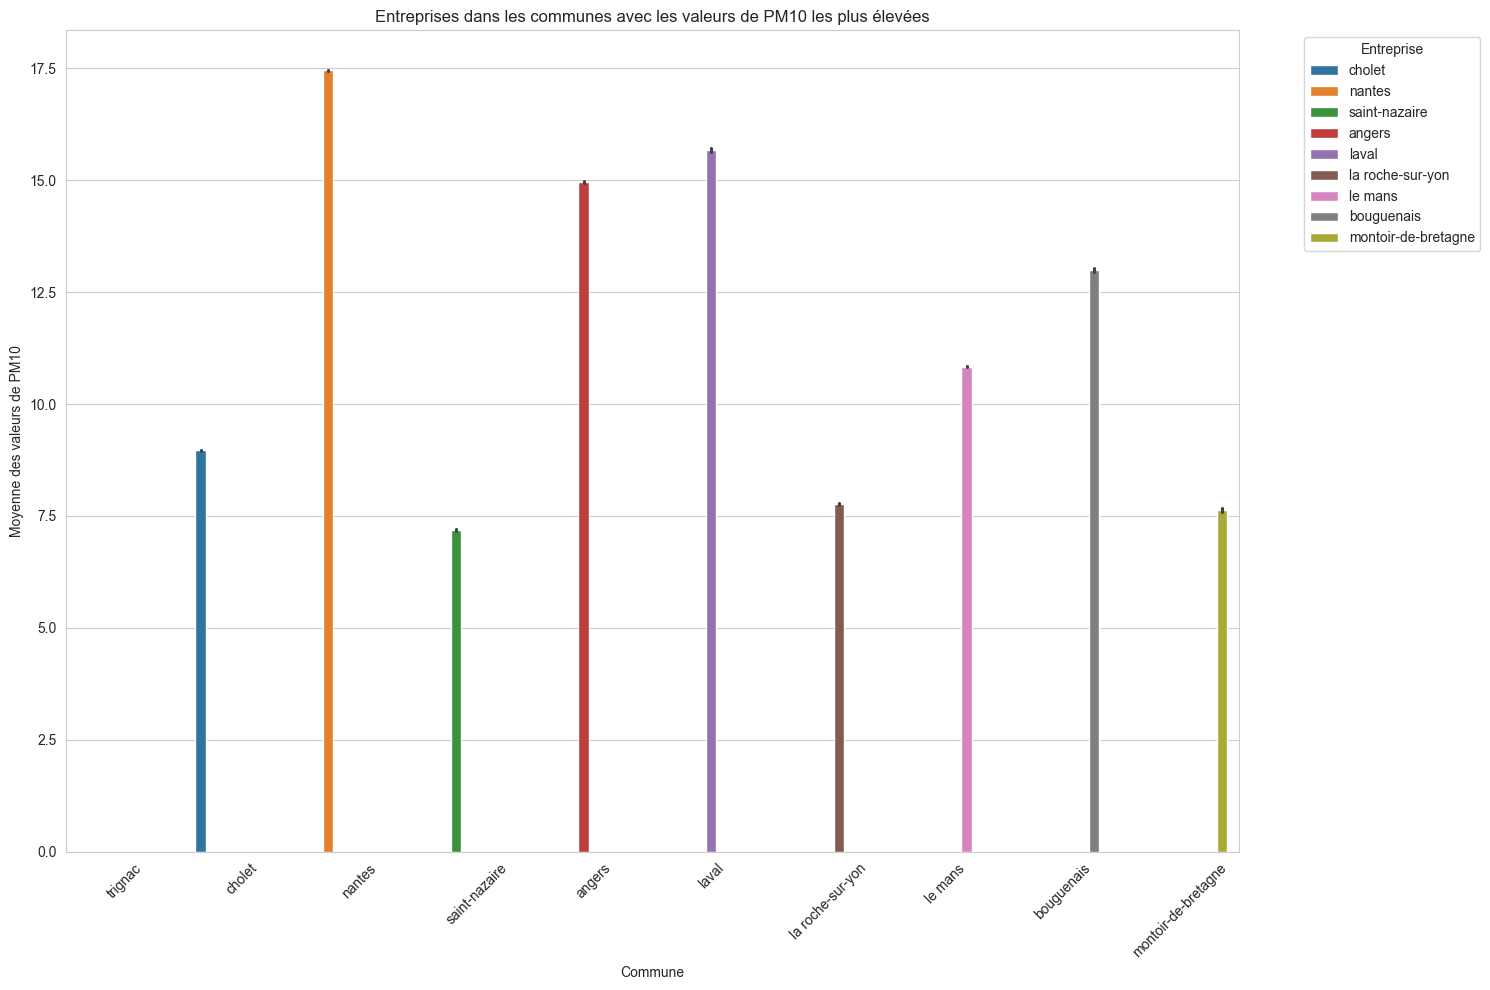

In [27]:
# Calculer les moyennes des valeurs de PM10 par commune
average_no2_by_commune = dfNO2_mensuel.groupby('nom_commune')['valeur'].mean().reset_index()

# Trier les communes par les moyennes de PM10
top_no2_communes = average_no2_by_commune.sort_values(by='valeur', ascending=False).head(10)

# Filtrer dfPM10_mensuel pour ne garder que les communes avec les PM10 les plus élevées
top_no2_merged = dfNO2_mensuel[dfNO2_mensuel['nom_commune'].isin(top_no2_communes['nom_commune'])]

# Vérifier les colonnes disponibles
print("Colonnes disponibles dans top_pm10_merged:", top_no2_merged.columns)

# Créer le graphique
plt.figure(figsize=(15, 10))
sns.barplot(x='nom_commune', y='valeur', data=top_no2_merged, hue='libellecommuneetablissement')
plt.title('Entreprises dans les communes avec les valeurs de PM10 les plus élevées')
plt.xlabel('Commune')
plt.ylabel('Moyenne des valeurs de PM10')
plt.xticks(rotation=45)

# Ajouter manuellement la légende si nécessaire
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(title='Entreprise', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    print("Aucune légende trouvée à afficher.")

plt.tight_layout()

# Afficher le graphique
plt.show()


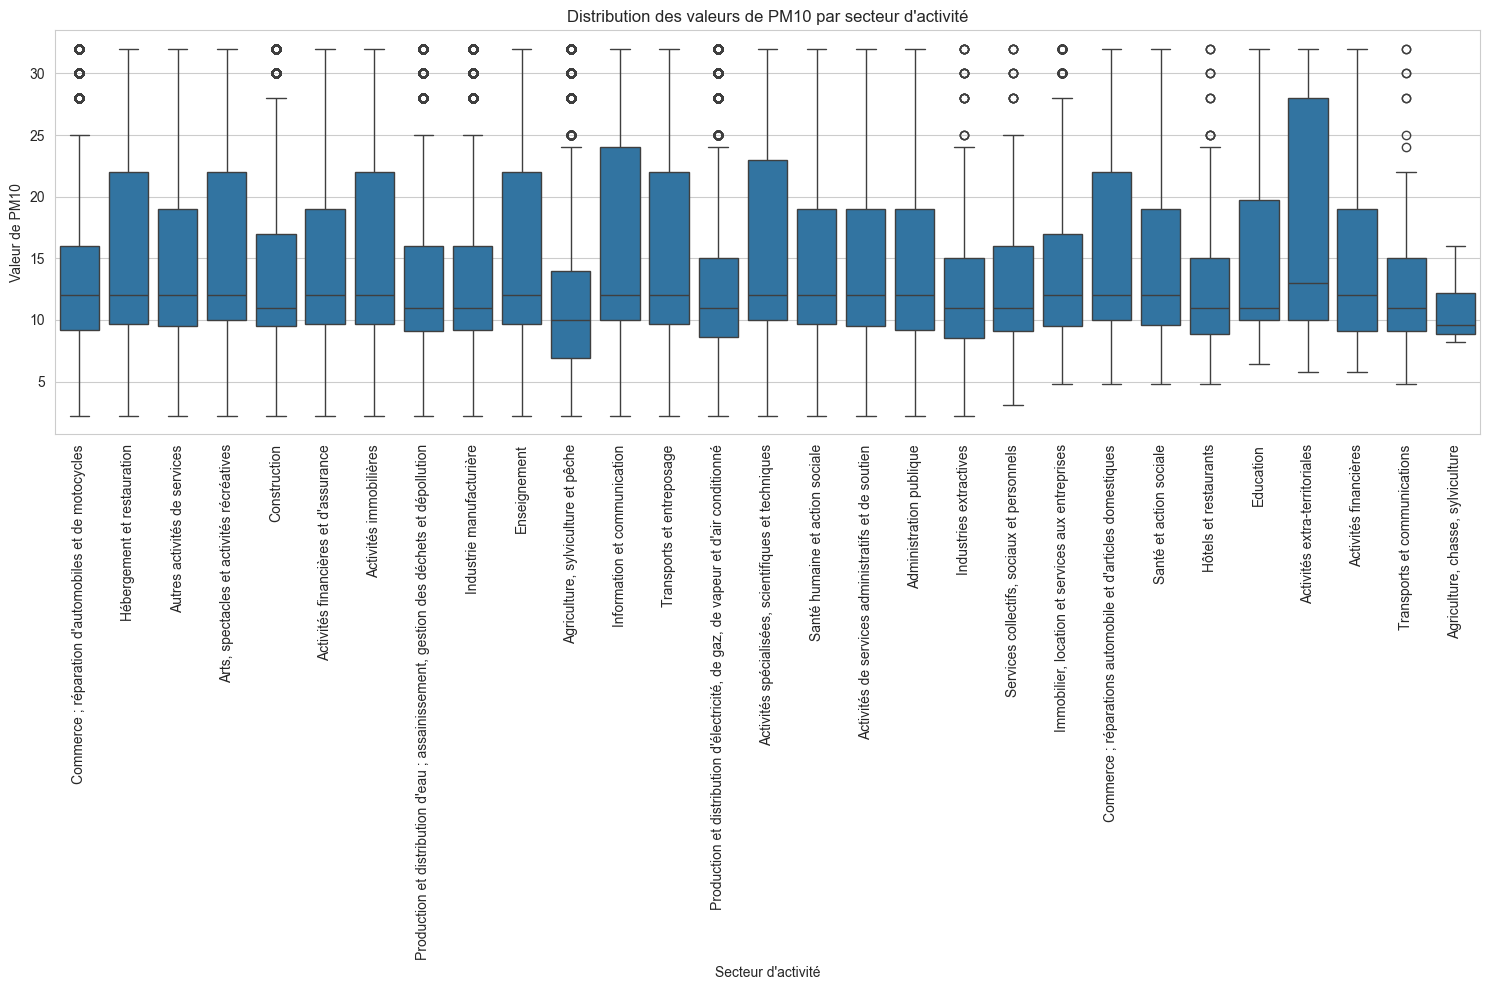

In [28]:
# Filtrer les lignes avec des valeurs nulles dans 'valeur' ou 'sectionetablissement'
dfNO2_mensuel = dfNO2_mensuel.dropna(subset=['valeur', 'sectionetablissement'])

# Créer le graphique box plot
plt.figure(figsize=(15, 10))
sns.boxplot(x='sectionetablissement', y='valeur', data=dfMerged)
plt.title('Distribution des valeurs de PM10 par secteur d\'activité')
plt.xlabel('Secteur d\'activité')
plt.ylabel('Valeur de PM10')
plt.xticks(rotation=90)
plt.tight_layout()

# Afficher le graphique
plt.show()

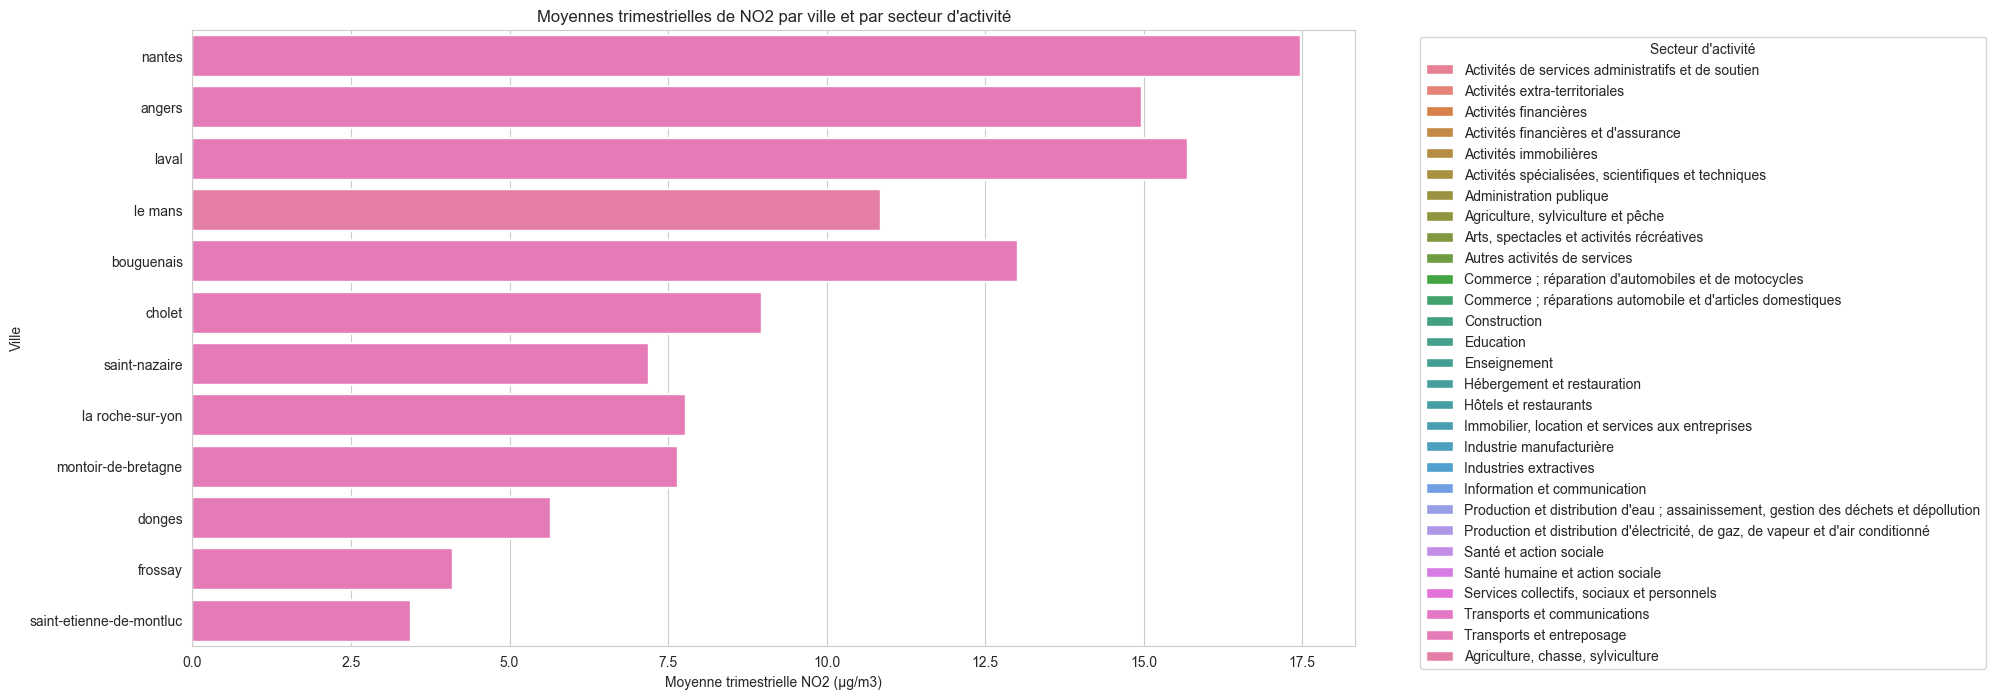

In [29]:
# Calculer la moyenne trimestrielle de PM10 pour chaque ville et chaque secteur d'activité
sector_city_means = dfNO2_mensuel.groupby(['nom_commune', 'sectionetablissement'])['valeur'].mean().reset_index()

# Trier les villes par la moyenne trimestrielle totale de NO2
total_city_means = sector_city_means.groupby('nom_commune')['valeur'].sum().sort_values(ascending=False).index

# Trier les secteurs d'activité pour chaque ville
sector_city_means['nom_commune'] = pd.Categorical(sector_city_means['nom_commune'], categories=total_city_means, ordered=True)
sector_city_means = sector_city_means.sort_values(by=['nom_commune', 'valeur'], ascending=[True, False])

# Créer un graphique en barres empilées pour les villes et les secteurs d'activité
plt.figure(figsize=(15, 8))
sns.barplot(data=sector_city_means, x='valeur', y='nom_commune', hue='sectionetablissement', dodge=False)

plt.xlabel('Moyenne trimestrielle NO2 (µg/m3)')
plt.ylabel('Ville')
plt.title('Moyennes trimestrielles de NO2 par ville et par secteur d\'activité')
plt.legend(title='Secteur d\'activité', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()